In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [4]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [14]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [15]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [16]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.06853882018293751+0.008227527944967184j)|2 2 0 1>
(-0.15487815250169742-0.01859186260241223j)|2 2 0 0>
(0.2804117615955391+0.033661151424359236j)|2 1 1 1>
(-0.07488854407553901-0.00898976065673218j)|2 1 0 1>
(-0.06853882018293746-0.0082275279449672j)|2 1 0 0>
(0.2804117615955392+0.03366115142435911j)|1 1 1 2>
(-0.7702533829695715-0.09246265424722531j)|1 1 1 1>
(0.28041176159553916+0.03366115142435924j)|1 1 0 1>
(-0.06853882018293753-0.008227527944967233j)|1 0 2 2>
(-0.07488854407553906-0.008989760656732085j)|1 0 1 2>
(0.28041176159553893+0.033661151424359166j)|1 0 1 1>
(-0.15487815250169745-0.0185918626024122j)|0 0 2 2>
(0.06853882018293753+0.00822752794496725j)|0 0 1 2>



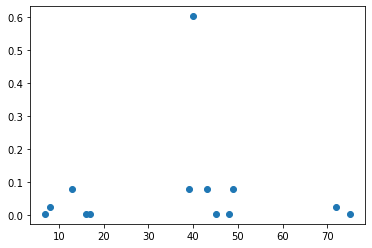

In [17]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [57]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 0.2/np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [58]:
def func(x):
    if x>=0.9:
        return (0.9-x)
    if x<0.9:
        return 0

In [59]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [60]:
import optuna
n_iter = 3500
theta = np.zeros(5*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+"+str(0), -4*np.pi, 4*np.pi)
        for j in range(1,5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)

        
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var
        #psi_var = ms_gate_global(theta[5*i+0])@psi_var
        
    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-16 13:40:46,631] A new study created in memory with name: no-name-c7febc3c-f61a-4f2d-93d9-ccb9167b5f57
[I 2022-05-16 13:40:46,785] Trial 0 finished with value: 4.012525554295352 and parameters: {'5*0+0': 8.441941138986959, '5*0+1': -4.843781966387245, '5*0+2': 2.2367187803495288, '5*0+3': 2.7602307078499244, '5*0+4': -5.847413304261204, '5*1+0': 0.04242439851209667, '5*1+1': -3.4760525411479786, '5*1+2': -0.8180290919207742, '5*1+3': 0.9084698035310819, '5*1+4': 4.949323172535408, '5*2+0': 3.238126549082157, '5*2+1': 5.301035711451382, '5*2+2': -0.5985802109250518, '5*2+3': 0.8203704243319416, '5*2+4': 3.0642153551074927, '5*3+0': 7.932566873679036, '5*3+1': 4.6259921124054735, '5*3+2': -5.000423415727829, '5*3+3': 4.166620182648995, '5*3+4': -2.339566304315677}. Best is trial 0 with value: 4.012525554295352.
[I 2022-05-16 13:40:46,899] Trial 1 finished with value: 2.078099231465246 and parameters: {'5*0+0': -1.132639663231719, '5*0+1': -0.2121254192004748, '5*0+2': 1.296037

[I 2022-05-16 13:40:47,993] Trial 11 finished with value: 1.6463361333608546 and parameters: {'5*0+0': 0.9591984588411526, '5*0+1': -0.36158202227662284, '5*0+2': -1.1203101990815663, '5*0+3': -0.30825306706962324, '5*0+4': -2.5993872072173145, '5*1+0': 0.8800077496170075, '5*1+1': 0.972506877882241, '5*1+2': 1.9309214931063203, '5*1+3': -0.6883217595501523, '5*1+4': 1.3690086946320519, '5*2+0': 1.4051709833517398, '5*2+1': 0.265181479654563, '5*2+2': -1.3015554519191779, '5*2+3': -1.2969808360105919, '5*2+4': -1.1703860611362074, '5*3+0': 2.1766333440920826, '5*3+1': -5.467225591344695, '5*3+2': -3.0616822812951567, '5*3+3': 0.2877658981336683, '5*3+4': -2.1047691803355577}. Best is trial 11 with value: 1.6463361333608546.
[I 2022-05-16 13:40:48,101] Trial 12 finished with value: 3.589313456574157 and parameters: {'5*0+0': 1.4450075269463, '5*0+1': 4.635962919678602, '5*0+2': -0.5816489860525151, '5*0+3': -1.2359791907660902, '5*0+4': 0.591791463605471, '5*1+0': -1.6616280523014224, '

[I 2022-05-16 13:40:49,357] Trial 22 finished with value: 3.3950698331688227 and parameters: {'5*0+0': 0.9372456206561091, '5*0+1': -2.1239232107065793, '5*0+2': -0.30413250861362273, '5*0+3': 0.4496184319482881, '5*0+4': -1.2884520358493288, '5*1+0': 1.2261740802849306, '5*1+1': 0.18610584046752177, '5*1+2': 2.1836313414475788, '5*1+3': -1.2324613563045508, '5*1+4': 1.8200541476770782, '5*2+0': 0.329003704074055, '5*2+1': -1.432632440820883, '5*2+2': 0.4443252823439138, '5*2+3': 0.20243955988125018, '5*2+4': 1.4640710320604589, '5*3+0': -1.1772431913552874, '5*3+1': 0.10019206385006285, '5*3+2': -0.8994264214233526, '5*3+3': 1.1997462840606992, '5*3+4': -2.339842190558975}. Best is trial 20 with value: 1.500806286977158.
[I 2022-05-16 13:40:49,501] Trial 23 finished with value: 2.3574692838952513 and parameters: {'5*0+0': 0.9799503992060529, '5*0+1': 3.0077869292564015, '5*0+2': -1.9687029981107118, '5*0+3': -0.22880384347402405, '5*0+4': -2.2981282124961857, '5*1+0': 1.92679136959580

[I 2022-05-16 13:40:50,851] Trial 34 finished with value: 3.174572372124307 and parameters: {'5*0+0': -0.22048473076255648, '5*0+1': -3.2124731942443296, '5*0+2': -1.6210503830603538, '5*0+3': -3.6384622797689374, '5*0+4': -3.748873495164046, '5*1+0': 0.8574766075237308, '5*1+1': -2.749185061514316, '5*1+2': 2.0062276912923074, '5*1+3': -1.7631425030944836, '5*1+4': -1.007326675067309, '5*2+0': 4.1253153380474075, '5*2+1': 1.1901973266770423, '5*2+2': -1.4916184849490637, '5*2+3': -1.4760073250468464, '5*2+4': -2.683058069096438, '5*3+0': -0.565343129194281, '5*3+1': -2.5009051184823488, '5*3+2': -1.7021132568186192, '5*3+3': -2.505225573026053, '5*3+4': -0.7177116819757684}. Best is trial 20 with value: 1.500806286977158.
[I 2022-05-16 13:40:50,971] Trial 35 finished with value: 4.264773090925155 and parameters: {'5*0+0': 0.18358254195264023, '5*0+1': -2.674219163508603, '5*0+2': -0.9221916526925762, '5*0+3': -0.6931249998973672, '5*0+4': -4.805978565131913, '5*1+0': 1.910526199728460

[I 2022-05-16 13:40:52,225] Trial 46 finished with value: 3.3855954745839787 and parameters: {'5*0+0': -1.6777486142092153, '5*0+1': -0.9399456621530126, '5*0+2': -1.715267304309657, '5*0+3': -0.7518448506758545, '5*0+4': -4.66180120432093, '5*1+0': 0.281184786774696, '5*1+1': 1.9213154076663677, '5*1+2': 1.6112627214622888, '5*1+3': -0.0738769073443093, '5*1+4': 0.740087573756901, '5*2+0': 2.5826049904852906, '5*2+1': 1.7382284096288447, '5*2+2': -1.2291047376671325, '5*2+3': -4.62693364155953, '5*2+4': -1.2588973980373195, '5*3+0': -0.2644697517818472, '5*3+1': -1.330199481356267, '5*3+2': -1.3287223830577015, '5*3+3': 0.5533660455686584, '5*3+4': -2.261806597814728}. Best is trial 20 with value: 1.500806286977158.
[I 2022-05-16 13:40:52,346] Trial 47 finished with value: 4.240887149081493 and parameters: {'5*0+0': -2.698014284033054, '5*0+1': -1.0221388986585151, '5*0+2': -1.6215389974595622, '5*0+3': -0.4562900966143675, '5*0+4': -2.4297181636758243, '5*1+0': -0.4221715093642726, '

[I 2022-05-16 13:40:53,540] Trial 58 finished with value: 5.263478546310862 and parameters: {'5*0+0': -4.798814708135583, '5*0+1': -1.5334975011702356, '5*0+2': 0.692066873775401, '5*0+3': 1.5858505431295358, '5*0+4': -4.506220989079795, '5*1+0': 1.762519776464765, '5*1+1': -3.3014992443973923, '5*1+2': 0.628797201789628, '5*1+3': -0.38152673204440146, '5*1+4': -1.6062916958875002, '5*2+0': -1.2932541264723674, '5*2+1': 1.899115498552805, '5*2+2': 0.1320666984776231, '5*2+3': -0.8454260267351874, '5*2+4': -1.2011129001590595, '5*3+0': 2.7251481136296034, '5*3+1': -2.134625971013805, '5*3+2': -0.767187806178131, '5*3+3': -0.9389416161553807, '5*3+4': -1.5971170004351007}. Best is trial 20 with value: 1.500806286977158.
[I 2022-05-16 13:40:53,644] Trial 59 finished with value: 3.934620185619914 and parameters: {'5*0+0': -2.7151049701306276, '5*0+1': 0.2457753363266941, '5*0+2': -0.8191497770902822, '5*0+3': -0.3052832601245039, '5*0+4': -5.427445941466083, '5*1+0': 0.9720789709164175, '5

[I 2022-05-16 13:40:54,822] Trial 70 finished with value: 6.434187064771859 and parameters: {'5*0+0': -2.418693302717846, '5*0+1': 2.700675972957269, '5*0+2': -0.7988472754772364, '5*0+3': 1.4503912946913717, '5*0+4': -3.435762761749719, '5*1+0': 0.47239353977782694, '5*1+1': 1.015108697860104, '5*1+2': -1.9243107825822183, '5*1+3': -0.4730020983248209, '5*1+4': -0.6404384404506254, '5*2+0': 0.6633358141095493, '5*2+1': 1.783733304129355, '5*2+2': 0.5072492035902004, '5*2+3': -2.152955091109159, '5*2+4': -1.9504580597095356, '5*3+0': -0.8517093364109249, '5*3+1': 2.085804069114676, '5*3+2': -2.7326089950996835, '5*3+3': 1.2982249619981634, '5*3+4': 2.936217668327285}. Best is trial 20 with value: 1.500806286977158.
[I 2022-05-16 13:40:54,929] Trial 71 finished with value: 2.081073786561034 and parameters: {'5*0+0': -0.9861370849224518, '5*0+1': -1.6317076605729934, '5*0+2': -3.1210557146631874, '5*0+3': 0.6221147242004526, '5*0+4': -5.55176078873061, '5*1+0': 0.46473692562640356, '5*1+

[I 2022-05-16 13:40:56,093] Trial 82 finished with value: 6.56392972416558 and parameters: {'5*0+0': -1.379208927114512, '5*0+1': -0.6097294671389846, '5*0+2': -2.905712057720506, '5*0+3': 3.2079321321897254, '5*0+4': -4.018278743989983, '5*1+0': 0.7246567621652051, '5*1+1': -0.29566063260124414, '5*1+2': -0.007766090808285497, '5*1+3': 2.0329046139054263, '5*1+4': 2.302204670001325, '5*2+0': 0.8246210806676133, '5*2+1': 0.7646397384556948, '5*2+2': 0.4982801712804299, '5*2+3': 0.07971314955386832, '5*2+4': -3.193826165011988, '5*3+0': 1.6289573604865328, '5*3+1': -4.268275345077264, '5*3+2': 0.3114236961478149, '5*3+3': 1.3982594946647044, '5*3+4': 2.3053238284118414}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:40:56,198] Trial 83 finished with value: 2.268483667678392 and parameters: {'5*0+0': 1.256438813348097, '5*0+1': -1.9989420817536645, '5*0+2': -0.9442692142167214, '5*0+3': 0.18039277154018696, '5*0+4': -3.3887021031420907, '5*1+0': -1.228321387287954, '5

[I 2022-05-16 13:40:57,289] Trial 93 finished with value: 4.904466694449447 and parameters: {'5*0+0': -1.1174294767887767, '5*0+1': -3.910691023706276, '5*0+2': -2.312194297746467, '5*0+3': -0.554877394515815, '5*0+4': -2.5047778930252824, '5*1+0': -0.030398995100831036, '5*1+1': -0.9415118179294846, '5*1+2': -2.075587397985092, '5*1+3': 1.5991357216491706, '5*1+4': 0.7891672135407678, '5*2+0': 0.8901470182476657, '5*2+1': 1.6012966906551653, '5*2+2': -1.3828485119429388, '5*2+3': -4.266245114220345, '5*2+4': -2.5788320362770287, '5*3+0': -0.8098993831507126, '5*3+1': -0.039846352242634, '5*3+2': 1.3025247243793538, '5*3+3': 0.6543076747739831, '5*3+4': -0.43795351108518055}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:40:57,391] Trial 94 finished with value: 3.1224647118842204 and parameters: {'5*0+0': -1.0860608139597903, '5*0+1': -1.3227743145227646, '5*0+2': -0.01064891777256588, '5*0+3': -0.5275983432263405, '5*0+4': 0.28359045008247197, '5*1+0': 0.5359151483

[I 2022-05-16 13:40:58,504] Trial 104 finished with value: 6.934240065387785 and parameters: {'5*0+0': -3.030381421596462, '5*0+1': -2.3956567313744443, '5*0+2': -1.0917064365419242, '5*0+3': -2.667761006440919, '5*0+4': -2.7284839963787464, '5*1+0': -0.876563211497153, '5*1+1': 0.1279167936959541, '5*1+2': -3.0170754466671044, '5*1+3': 1.0704231549688532, '5*1+4': -1.045278490879283, '5*2+0': -1.3702347805553106, '5*2+1': 1.3881340391463493, '5*2+2': -0.36351963726385933, '5*2+3': -0.27228777283670613, '5*2+4': 0.15618418962428748, '5*3+0': 2.5085602654123846, '5*3+1': -1.9882727556379933, '5*3+2': 1.9581688688340593, '5*3+3': 0.46659920117993314, '5*3+4': 1.6773360509574327}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:40:58,610] Trial 105 finished with value: 2.0717351732197953 and parameters: {'5*0+0': -0.0030016859177748323, '5*0+1': 0.36761270283043856, '5*0+2': 0.916359988792256, '5*0+3': 2.6868744456569624, '5*0+4': -1.8880155517238073, '5*1+0': 0.83858613

[I 2022-05-16 13:40:59,666] Trial 115 finished with value: 3.2574233919323827 and parameters: {'5*0+0': 1.2868232214781075, '5*0+1': -0.581380889281071, '5*0+2': 1.3919691768478764, '5*0+3': 2.138983496830976, '5*0+4': -5.631107794976286, '5*1+0': -4.237501330670277, '5*1+1': 0.2868262641967688, '5*1+2': -2.6974179720493474, '5*1+3': -1.0185386801109106, '5*1+4': 0.6877460207440171, '5*2+0': 2.7996195604058043, '5*2+1': 3.371064845493345, '5*2+2': -0.5365943396600716, '5*2+3': -2.5691808135474017, '5*2+4': 2.6350654136055915, '5*3+0': 1.8699695641534577, '5*3+1': -1.1714926903181726, '5*3+2': -1.540464780982398, '5*3+3': 0.0713055719690987, '5*3+4': 0.4427128683140611}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:40:59,811] Trial 116 finished with value: 3.811895726903577 and parameters: {'5*0+0': 1.2568424739942632, '5*0+1': -2.1686813901465642, '5*0+2': 0.6160250909854654, '5*0+3': 1.6451417678686342, '5*0+4': -4.600658087651387, '5*1+0': -2.2394746648820627, '5

[I 2022-05-16 13:41:01,014] Trial 127 finished with value: 3.3124207167726425 and parameters: {'5*0+0': 0.20914003314846114, '5*0+1': -0.3279355607625498, '5*0+2': -0.37653165669427924, '5*0+3': 3.8418578823870257, '5*0+4': -3.7100380883698607, '5*1+0': -3.3300699473594864, '5*1+1': 1.356754666806681, '5*1+2': -1.3323746322568277, '5*1+3': -0.9708362676350497, '5*1+4': 0.5116189555391011, '5*2+0': -0.55931089699253, '5*2+1': 2.924394567473045, '5*2+2': -1.3424726305181476, '5*2+3': -1.6460862025057552, '5*2+4': 0.29151890636290695, '5*3+0': 1.5895712365737094, '5*3+1': -2.4311890931964775, '5*3+2': 1.4445513872824538, '5*3+3': -1.8844246387076968, '5*3+4': -3.3896064051294275}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:41:01,120] Trial 128 finished with value: 6.948657206452979 and parameters: {'5*0+0': 0.8729749231171644, '5*0+1': -1.8620196669275026, '5*0+2': 0.7159294123407722, '5*0+3': 3.11762602053386, '5*0+4': -4.777538830271711, '5*1+0': -1.09984629023414

[I 2022-05-16 13:41:02,281] Trial 139 finished with value: 3.383325677718541 and parameters: {'5*0+0': 1.791823877860823, '5*0+1': 1.3004499401007614, '5*0+2': -3.2420155353826354, '5*0+3': 2.8451578066930967, '5*0+4': -0.12326802769902923, '5*1+0': -3.7239039622037233, '5*1+1': -2.372014464787209, '5*1+2': -1.2210069980782698, '5*1+3': -2.938159188411955, '5*1+4': -2.5142465195300665, '5*2+0': -0.6753623100919004, '5*2+1': 0.58463097872099, '5*2+2': -0.5547482084976987, '5*2+3': -2.3500492506004926, '5*2+4': -0.3977044324676299, '5*3+0': 2.7773463594464216, '5*3+1': -4.65057715697812, '5*3+2': 0.9551075311115367, '5*3+3': -1.973289595356645, '5*3+4': -4.132996378508923}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:41:02,382] Trial 140 finished with value: 2.7223791625433083 and parameters: {'5*0+0': -1.964227344325858, '5*0+1': 1.0574849033910119, '5*0+2': -2.769022784696102, '5*0+3': 0.13783644820203866, '5*0+4': -1.841990985100701, '5*1+0': -3.3415469427920614,

[I 2022-05-16 13:41:03,442] Trial 150 finished with value: 3.7576471025095004 and parameters: {'5*0+0': 1.4855110504890012, '5*0+1': -0.8715896011264942, '5*0+2': -3.1450033626370084, '5*0+3': 2.674547712666461, '5*0+4': -3.547745367557149, '5*1+0': -6.786928210171073, '5*1+1': -0.3075828332348639, '5*1+2': -0.18463762122090088, '5*1+3': -1.2253586591141095, '5*1+4': -0.10254822174934641, '5*2+0': 0.24243340009477438, '5*2+1': 0.4624188001375211, '5*2+2': -0.42754119939501045, '5*2+3': -1.9968904438313433, '5*2+4': -2.682214009369381, '5*3+0': 3.6327759621245295, '5*3+1': -4.135158257113545, '5*3+2': -2.0989527006317528, '5*3+3': -2.579444956662556, '5*3+4': -3.177837159405035}. Best is trial 79 with value: 1.4779201725554363.
[I 2022-05-16 13:41:03,553] Trial 151 finished with value: 4.0257691761259 and parameters: {'5*0+0': 0.2965334389688429, '5*0+1': -0.9942619356907824, '5*0+2': -4.5997867152897465, '5*0+3': 4.785560255620717, '5*0+4': -5.227394303354945, '5*1+0': -2.0248631488703

[I 2022-05-16 13:41:04,729] Trial 162 finished with value: 5.9547566733624695 and parameters: {'5*0+0': 2.7780151406180202, '5*0+1': -0.5674781597746823, '5*0+2': -3.150932862642661, '5*0+3': 4.100740447595095, '5*0+4': -4.064727516933217, '5*1+0': -1.4843503213390834, '5*1+1': -2.209686306837116, '5*1+2': -1.1186458817140268, '5*1+3': -1.9050126743225082, '5*1+4': 2.6468401365278895, '5*2+0': 1.6364275913253075, '5*2+1': 3.8984524807609473, '5*2+2': -1.5308521885439679, '5*2+3': -2.288813654285281, '5*2+4': -0.8046728209483412, '5*3+0': 0.8590363038348916, '5*3+1': -2.27303617465448, '5*3+2': -0.12157162734915383, '5*3+3': 0.07040674000870323, '5*3+4': 0.9306717076763902}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:04,832] Trial 163 finished with value: 4.841602423388658 and parameters: {'5*0+0': -0.32118825798373885, '5*0+1': 0.3974045371966861, '5*0+2': -4.115854853172703, '5*0+3': 2.9459940928557673, '5*0+4': -2.8938915152496523, '5*1+0': -3.30726240664185

[I 2022-05-16 13:41:05,896] Trial 173 finished with value: 2.7102832964221593 and parameters: {'5*0+0': 0.6287172168178374, '5*0+1': 0.10716711253863218, '5*0+2': -1.85111217082051, '5*0+3': 3.890359603159359, '5*0+4': -0.6612342746479826, '5*1+0': -5.937775131270989, '5*1+1': -3.1563849375772692, '5*1+2': 2.6351257011491196, '5*1+3': -1.8967666018079663, '5*1+4': -0.5644101105882867, '5*2+0': 0.9949171168097883, '5*2+1': 1.9701868507134535, '5*2+2': -1.0669392908413284, '5*2+3': -3.4788950672325627, '5*2+4': -0.8283494577677488, '5*3+0': 1.6557643500823822, '5*3+1': -2.3294440198451967, '5*3+2': 1.121836708693627, '5*3+3': -0.04932841282119782, '5*3+4': -1.1598241408827545}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:06,001] Trial 174 finished with value: 2.769086427587975 and parameters: {'5*0+0': 1.084119947187395, '5*0+1': 1.716163053339313, '5*0+2': -2.2529322679713966, '5*0+3': 2.275819068128264, '5*0+4': -0.9847119906626394, '5*1+0': -2.714739645192939,

[I 2022-05-16 13:41:07,152] Trial 185 finished with value: 2.15279236161383 and parameters: {'5*0+0': 1.3723442735764964, '5*0+1': -0.6414285313457952, '5*0+2': -0.8495106879798253, '5*0+3': 1.846247627739632, '5*0+4': -1.0475259388906633, '5*1+0': -3.6883829662320653, '5*1+1': -0.7665258898977315, '5*1+2': -1.2351486135792495, '5*1+3': -2.1782520523337947, '5*1+4': -1.3544300561901526, '5*2+0': 0.3071651323445532, '5*2+1': 2.292782187105204, '5*2+2': 1.4916200067479046, '5*2+3': -3.154260004835006, '5*2+4': 0.9875270604871454, '5*3+0': -0.6841511051429303, '5*3+1': -1.3122717455920339, '5*3+2': 0.8923399876948452, '5*3+3': -1.776760433913247, '5*3+4': -3.7611210949096883}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:07,256] Trial 186 finished with value: 4.618996794669734 and parameters: {'5*0+0': 1.9960469492554336, '5*0+1': 1.4750214070481966, '5*0+2': -0.17733895593925397, '5*0+3': 0.9093547412347283, '5*0+4': 2.80330332745441, '5*1+0': -3.7910711176781096,

[I 2022-05-16 13:41:08,389] Trial 197 finished with value: 3.6355383366705007 and parameters: {'5*0+0': 2.2718295229986096, '5*0+1': -0.021231461111877237, '5*0+2': -1.783955275153199, '5*0+3': 1.2937418599269583, '5*0+4': -3.6772976192752047, '5*1+0': -4.737910354328852, '5*1+1': -2.6119038677518303, '5*1+2': -0.005202234340393519, '5*1+3': 0.059889544070914624, '5*1+4': -0.5666912219896398, '5*2+0': 2.001692067301537, '5*2+1': 1.6527860765306162, '5*2+2': 1.067766945531916, '5*2+3': -3.716232099864124, '5*2+4': 1.6471329788173108, '5*3+0': 1.7056152461100622, '5*3+1': -1.546959633482469, '5*3+2': 1.3807155279493515, '5*3+3': -2.1331643462798597, '5*3+4': -3.4672828012011805}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:08,490] Trial 198 finished with value: 4.068547296371066 and parameters: {'5*0+0': 4.257314432913874, '5*0+1': -0.16070394083485806, '5*0+2': -1.5291820464372499, '5*0+3': 0.8283257162098763, '5*0+4': 0.41050630119546816, '5*1+0': -3.8294171920

[I 2022-05-16 13:41:09,625] Trial 209 finished with value: 2.3658641410192547 and parameters: {'5*0+0': 2.5497567322530075, '5*0+1': 1.6559476217180642, '5*0+2': -2.1475607440861118, '5*0+3': 2.382916193628423, '5*0+4': 0.27987858237979, '5*1+0': -4.928156126113545, '5*1+1': -1.7975981940889416, '5*1+2': -0.5311494949088604, '5*1+3': -3.9744986179195374, '5*1+4': -1.9874805847315429, '5*2+0': 4.201265747447366, '5*2+1': 5.672062606312701, '5*2+2': 0.37900589592089645, '5*2+3': -2.292325242913896, '5*2+4': -2.478705766199981, '5*3+0': 0.7919519503421162, '5*3+1': -0.10667092974855966, '5*3+2': -0.39333220221749476, '5*3+3': 1.123496506606642, '5*3+4': -2.1162324699855986}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:09,727] Trial 210 finished with value: 2.7877215217202886 and parameters: {'5*0+0': 2.3022828457485676, '5*0+1': -0.027802745275920193, '5*0+2': -1.8375295536235239, '5*0+3': 2.309470483258319, '5*0+4': -2.2046976375220355, '5*1+0': -2.51036446730808

[I 2022-05-16 13:41:10,754] Trial 220 finished with value: 4.13023467181475 and parameters: {'5*0+0': 2.225484136773493, '5*0+1': -0.2756381371331099, '5*0+2': -1.7265373068375423, '5*0+3': 2.0759342702520343, '5*0+4': -1.5327361069764867, '5*1+0': -2.579681918975738, '5*1+1': -0.13042365522726604, '5*1+2': -0.8806128428694208, '5*1+3': -0.4517837066722721, '5*1+4': -0.32825283960138574, '5*2+0': 1.3018597628065487, '5*2+1': 3.3540822664427954, '5*2+2': -0.046616563376755016, '5*2+3': -0.6206449528179421, '5*2+4': 0.3712225578901194, '5*3+0': 0.16405612737513486, '5*3+1': -0.15489570739351377, '5*3+2': 2.0947372602200214, '5*3+3': 0.5459109437185681, '5*3+4': 1.8307257150963812}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:10,857] Trial 221 finished with value: 4.01608880722542 and parameters: {'5*0+0': 4.545712873605652, '5*0+1': 1.9585889031304449, '5*0+2': 1.1258929313436021, '5*0+3': 2.038936407633678, '5*0+4': -0.7630595812346399, '5*1+0': -3.3270823749135

[I 2022-05-16 13:41:11,905] Trial 231 finished with value: 4.783537644324218 and parameters: {'5*0+0': 1.4866264493313928, '5*0+1': 2.137995934347586, '5*0+2': -1.4709797982244797, '5*0+3': -0.8087222943057675, '5*0+4': -0.9437914282362507, '5*1+0': -1.8408545574712327, '5*1+1': -0.7517798285624888, '5*1+2': -2.029542961927076, '5*1+3': -2.811105458408687, '5*1+4': -0.7572264293876592, '5*2+0': -0.19717367860909407, '5*2+1': 4.338419883999063, '5*2+2': 0.7943238874332985, '5*2+3': -0.6851788544385835, '5*2+4': 1.8467270136534224, '5*3+0': 2.539849822082515, '5*3+1': -1.5006941174464838, '5*3+2': -0.038134004950571176, '5*3+3': -1.9192489924064544, '5*3+4': -0.6564718945960788}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:12,007] Trial 232 finished with value: 5.9907428759378245 and parameters: {'5*0+0': 0.9465055669310869, '5*0+1': 0.7596741816672158, '5*0+2': -2.197232185865563, '5*0+3': 3.0668695249303566, '5*0+4': -1.7238681754775431, '5*1+0': -1.39064279419

[I 2022-05-16 13:41:13,096] Trial 242 finished with value: 3.7587926058515198 and parameters: {'5*0+0': 1.5779800364853054, '5*0+1': 2.042031569495186, '5*0+2': -3.562587937272818, '5*0+3': 1.519122107542472, '5*0+4': 1.5923592068763885, '5*1+0': -3.4436186515925886, '5*1+1': 1.6807993789220501, '5*1+2': 0.4673532715430372, '5*1+3': -2.1880891814904158, '5*1+4': -2.432889281583669, '5*2+0': 0.23744813837628875, '5*2+1': 3.5982925378978443, '5*2+2': -0.6482016193029096, '5*2+3': -0.2507114990226249, '5*2+4': 3.374233377137247, '5*3+0': 0.9330169198243381, '5*3+1': 1.6897227894788078, '5*3+2': 1.8531764870368512, '5*3+3': -0.16424721983025437, '5*3+4': -0.07691895771729418}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:13,198] Trial 243 finished with value: 5.539488461611386 and parameters: {'5*0+0': 2.4618686328853574, '5*0+1': 1.2721840156092652, '5*0+2': -3.2347569558947358, '5*0+3': 1.2101709465351975, '5*0+4': -0.23688291439361486, '5*1+0': -2.770447985467824

[I 2022-05-16 13:41:14,321] Trial 253 finished with value: 2.727915451486874 and parameters: {'5*0+0': 2.5083094004737636, '5*0+1': 3.426771404504551, '5*0+2': -1.1374214271208083, '5*0+3': 2.0107779857898587, '5*0+4': -1.4023948270749806, '5*1+0': -2.936447260945859, '5*1+1': 1.9320715278904161, '5*1+2': 0.42745749566546243, '5*1+3': -2.627354254119064, '5*1+4': -1.6590698526411733, '5*2+0': -0.7439460610472128, '5*2+1': 2.260559078631889, '5*2+2': 0.36172084982387126, '5*2+3': -1.3325397456500871, '5*2+4': 3.0404885510383974, '5*3+0': -0.2243216721377747, '5*3+1': -0.2509250575320401, '5*3+2': -0.23854866025892174, '5*3+3': -1.516463819311426, '5*3+4': -4.066100140245741}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:14,437] Trial 254 finished with value: 2.95670867405449 and parameters: {'5*0+0': 1.4285766015745307, '5*0+1': 1.5941184941991746, '5*0+2': -1.0764289425758915, '5*0+3': 1.5545299945524327, '5*0+4': -1.0356524703050605, '5*1+0': -3.1457864194761, 

[I 2022-05-16 13:41:15,734] Trial 265 finished with value: 3.010034246491916 and parameters: {'5*0+0': 1.7782920723706859, '5*0+1': 2.405155572253025, '5*0+2': -1.5243676170070226, '5*0+3': 2.3548385446122735, '5*0+4': -1.1448402287188955, '5*1+0': -4.225318348931436, '5*1+1': 0.19711459609264326, '5*1+2': 0.6543541719784899, '5*1+3': -2.5288093454487206, '5*1+4': -1.766455284085771, '5*2+0': 0.08889229836124124, '5*2+1': 1.594743802786265, '5*2+2': -0.06504350430562089, '5*2+3': -3.2438474972728786, '5*2+4': 1.27828702261745, '5*3+0': -0.7272162515963457, '5*3+1': -1.557130453647257, '5*3+2': 4.625523581229967, '5*3+3': 0.4603500637280715, '5*3+4': -0.760465182956656}. Best is trial 159 with value: 0.850277144720624.
[I 2022-05-16 13:41:15,850] Trial 266 finished with value: 3.937485793380673 and parameters: {'5*0+0': 3.307779041635075, '5*0+1': 0.06636897803356612, '5*0+2': -2.4090242322264044, '5*0+3': 1.2229304192495778, '5*0+4': 0.20520868463984399, '5*1+0': -3.6123712613618926, '

[I 2022-05-16 13:41:17,157] Trial 277 finished with value: 4.873522611985976 and parameters: {'5*0+0': 0.22399122252827808, '5*0+1': 2.0530912389622817, '5*0+2': -0.8808570930331965, '5*0+3': 3.4399645103973002, '5*0+4': -1.0092800305727676, '5*1+0': -0.8844023046944648, '5*1+1': 1.2983834774991003, '5*1+2': -0.3339082530771915, '5*1+3': -1.465387082497607, '5*1+4': -0.7923310942387278, '5*2+0': 0.23800681159063747, '5*2+1': 2.9796561996879967, '5*2+2': 0.9550598651444171, '5*2+3': -1.7695482749193996, '5*2+4': 5.165148690090426, '5*3+0': 1.108039618465317, '5*3+1': -2.1713136955567687, '5*3+2': 2.0787240785048176, '5*3+3': 1.0870283636267348, '5*3+4': -0.9509585944022008}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:17,272] Trial 278 finished with value: 2.364565315717197 and parameters: {'5*0+0': 1.558246742319136, '5*0+1': 0.06831978106664383, '5*0+2': 0.14803681746993247, '5*0+3': 2.5538414391366215, '5*0+4': 0.16894200277758173, '5*1+0': -2.58900102088486

[I 2022-05-16 13:41:18,576] Trial 289 finished with value: 8.664150953064809 and parameters: {'5*0+0': 2.7929960095631583, '5*0+1': 2.769060322214188, '5*0+2': -1.854354888605914, '5*0+3': 3.0047750786075658, '5*0+4': -0.11915076493381677, '5*1+0': -1.4956627541324563, '5*1+1': 0.3715866642832666, '5*1+2': 0.23964569963162413, '5*1+3': -2.5386112667240086, '5*1+4': -0.6666989456316924, '5*2+0': 0.7739592913193969, '5*2+1': 0.6646552033198745, '5*2+2': 0.4370249085013522, '5*2+3': -3.3731075970073396, '5*2+4': 4.209746240980565, '5*3+0': -0.1467246955042391, '5*3+1': -2.6872745397545623, '5*3+2': 2.3070935576438467, '5*3+3': -0.8050106041718916, '5*3+4': -1.3815036700568932}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:18,696] Trial 290 finished with value: 2.004854989480392 and parameters: {'5*0+0': 0.06540348771406246, '5*0+1': 2.578943923833584, '5*0+2': 0.9157902040491454, '5*0+3': 1.7482688454130564, '5*0+4': 0.4939110332797382, '5*1+0': 0.4202876301277498

[I 2022-05-16 13:41:19,874] Trial 301 finished with value: 3.353484374354231 and parameters: {'5*0+0': 2.0567527428570123, '5*0+1': 1.996454593209101, '5*0+2': 0.07616083228676632, '5*0+3': 1.3280947868245678, '5*0+4': 1.1640277319157735, '5*1+0': -2.037251903347709, '5*1+1': 1.1285747421109433, '5*1+2': 0.4280381476660343, '5*1+3': -4.872332891953325, '5*1+4': -0.6008907838349846, '5*2+0': -2.8244573067173304, '5*2+1': 2.910285350699932, '5*2+2': 0.8422201938041564, '5*2+3': -2.3232986541397294, '5*2+4': 4.224128742614737, '5*3+0': 0.3111591309258368, '5*3+1': -0.7759239381551719, '5*3+2': 2.8172292945245028, '5*3+3': -2.3111534641957325, '5*3+4': -3.1387516416799417}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:19,979] Trial 302 finished with value: 2.2414050102158622 and parameters: {'5*0+0': 1.5560540014065969, '5*0+1': 1.5016380625143488, '5*0+2': -0.7609977277484962, '5*0+3': 2.9602404879353545, '5*0+4': -0.7219013777930674, '5*1+0': -1.1330756254438188,

[I 2022-05-16 13:41:21,021] Trial 312 finished with value: 1.8307278549911077 and parameters: {'5*0+0': 2.463041151604246, '5*0+1': 0.22023615363030635, '5*0+2': -1.2065585561630983, '5*0+3': 3.576914846745068, '5*0+4': 0.881423466662754, '5*1+0': -0.7826152872041681, '5*1+1': 0.5462877319603938, '5*1+2': -0.549913748830806, '5*1+3': -2.7365277686015834, '5*1+4': -2.4248676323305114, '5*2+0': -2.57808981962929, '5*2+1': 1.5537323916855623, '5*2+2': 0.561221332089037, '5*2+3': -1.009264098064351, '5*2+4': 3.8919424235629414, '5*3+0': 0.7362618731860344, '5*3+1': -0.30395047963268107, '5*3+2': 3.491986848121889, '5*3+3': -0.15910342044536174, '5*3+4': -1.9749113628217607}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:21,127] Trial 313 finished with value: 2.7333311805475513 and parameters: {'5*0+0': 1.6861170037645077, '5*0+1': 0.5595329056913496, '5*0+2': -1.2411036525226056, '5*0+3': 3.515815250229377, '5*0+4': 1.9777233248632415, '5*1+0': -1.062678096464826, '

[I 2022-05-16 13:41:22,279] Trial 324 finished with value: 2.6235818068729113 and parameters: {'5*0+0': 2.076885136608466, '5*0+1': 2.468168333710088, '5*0+2': -0.4359825893931403, '5*0+3': 2.6204748614674274, '5*0+4': 2.1900680644519923, '5*1+0': -0.5450065603847343, '5*1+1': 1.2467519784002334, '5*1+2': -0.02809020275660029, '5*1+3': -1.9591353344234137, '5*1+4': -0.6718773195108387, '5*2+0': -4.884635805368404, '5*2+1': 4.309913105971797, '5*2+2': 1.6730730225918016, '5*2+3': -3.866241151589361, '5*2+4': 5.465159552964055, '5*3+0': -0.18458355464270615, '5*3+1': -0.927824856416264, '5*3+2': 1.977721068595407, '5*3+3': -1.9492054350060135, '5*3+4': 1.3644248946504345}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:22,386] Trial 325 finished with value: 3.9263971082127016 and parameters: {'5*0+0': 1.6463934383259518, '5*0+1': 0.4049959630627902, '5*0+2': -1.0349529832864397, '5*0+3': 0.6926951461165937, '5*0+4': -0.20165061868076173, '5*1+0': -1.575380729801974

[I 2022-05-16 13:41:23,555] Trial 336 finished with value: 3.0304426127159614 and parameters: {'5*0+0': 3.760522300585129, '5*0+1': 2.030126386400178, '5*0+2': -0.36115717792386776, '5*0+3': 0.20593705979594645, '5*0+4': 1.2299661409395528, '5*1+0': -0.4734112087942181, '5*1+1': 0.9838220570871514, '5*1+2': 2.0062799552728103, '5*1+3': -2.6903239470713953, '5*1+4': -0.6028173532200296, '5*2+0': -3.2277280682948, '5*2+1': 3.2346206463461984, '5*2+2': -0.6312410838352553, '5*2+3': -2.9618527503766865, '5*2+4': 3.563773385369923, '5*3+0': 0.9514513026024844, '5*3+1': -2.646346022002142, '5*3+2': -0.6766485329070178, '5*3+3': 1.9877239462976015, '5*3+4': -0.3706441696933459}. Best is trial 273 with value: 0.8005476516326449.
[I 2022-05-16 13:41:23,672] Trial 337 finished with value: 0.7384725000110126 and parameters: {'5*0+0': 0.22696040508877235, '5*0+1': 1.5094482085312142, '5*0+2': -0.11314934716713462, '5*0+3': 0.883028375472544, '5*0+4': 0.5986502728514634, '5*1+0': 0.5179991655590563

[I 2022-05-16 13:41:24,888] Trial 348 finished with value: 5.78950654175639 and parameters: {'5*0+0': 0.8003899408386391, '5*0+1': 0.8022535916878574, '5*0+2': 1.9687698285738673, '5*0+3': 2.070437664508793, '5*0+4': 3.029423852012612, '5*1+0': 0.41398688521327426, '5*1+1': 2.19498685964824, '5*1+2': 0.7776096705071125, '5*1+3': -1.8480597760104474, '5*1+4': -0.8438236804393889, '5*2+0': -3.16259179964539, '5*2+1': 1.3966382016846965, '5*2+2': 0.7334484981836817, '5*2+3': -1.7584432465204012, '5*2+4': 4.431822114809408, '5*3+0': 1.2571151739503998, '5*3+1': -1.0696566856794931, '5*3+2': 3.8569435090560877, '5*3+3': 0.7003375024059003, '5*3+4': 0.7982729616338134}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:24,994] Trial 349 finished with value: 3.6045767796714934 and parameters: {'5*0+0': -0.2067532953270672, '5*0+1': 0.7802868027974494, '5*0+2': 1.542703875736724, '5*0+3': 1.7972357835986252, '5*0+4': -0.6021801947846364, '5*1+0': 1.6542975195531489, '5*1+1'

[I 2022-05-16 13:41:26,137] Trial 360 finished with value: 2.7250803824425365 and parameters: {'5*0+0': 1.380490880166193, '5*0+1': 1.5091326664635896, '5*0+2': 0.16565639012371086, '5*0+3': 0.5177334990825401, '5*0+4': 1.1270094610953394, '5*1+0': -1.263464299759709, '5*1+1': -0.0042671196417234936, '5*1+2': -0.44397455820392817, '5*1+3': 0.3632068703269792, '5*1+4': -0.6188266622936329, '5*2+0': -5.7380124365657075, '5*2+1': 3.195281016814004, '5*2+2': -2.972132912047254, '5*2+3': -0.6748404581507115, '5*2+4': 4.5592952291939675, '5*3+0': -1.20244091624778, '5*3+1': -3.3945528238882425, '5*3+2': 0.9724307116076021, '5*3+3': -1.1341420638669975, '5*3+4': 1.8563442215043096}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:26,245] Trial 361 finished with value: 2.723187363615512 and parameters: {'5*0+0': 2.2682833867727394, '5*0+1': 1.9503168010313814, '5*0+2': -0.3883670527542147, '5*0+3': 1.1283869948434302, '5*0+4': 0.6065906979337269, '5*1+0': -1.0327194671664

[I 2022-05-16 13:41:27,405] Trial 372 finished with value: 2.7720130231011773 and parameters: {'5*0+0': 2.461598317731314, '5*0+1': 1.9583327077444896, '5*0+2': -0.10813034471687133, '5*0+3': -1.6674300034185707, '5*0+4': 0.4425718868935434, '5*1+0': 0.38604661422354347, '5*1+1': -0.8629304840090206, '5*1+2': 2.1763228896961446, '5*1+3': -0.6260073334272342, '5*1+4': 0.6345701438968666, '5*2+0': -2.990935771595412, '5*2+1': 3.246745227311459, '5*2+2': 0.05461165409310931, '5*2+3': -1.4539100453072957, '5*2+4': 3.504356942929484, '5*3+0': -1.620522729019661, '5*3+1': -0.19224338464124013, '5*3+2': 2.3950832941492735, '5*3+3': 0.24391652927593904, '5*3+4': -0.2570384245630577}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:27,510] Trial 373 finished with value: 3.7601621053365957 and parameters: {'5*0+0': 2.3698875980002745, '5*0+1': 0.04215851252431424, '5*0+2': -0.4028739160524981, '5*0+3': 0.912198965368328, '5*0+4': -0.24746804847070997, '5*1+0': -1.4768200255

[I 2022-05-16 13:41:28,679] Trial 384 finished with value: 4.0106607429687955 and parameters: {'5*0+0': 2.1703822505294967, '5*0+1': 0.9461673361168191, '5*0+2': 0.5626776804323873, '5*0+3': 0.22165845975686113, '5*0+4': 0.7586028380582702, '5*1+0': -0.9696296878276471, '5*1+1': 1.4976043275339783, '5*1+2': 0.0038712969053644186, '5*1+3': -0.5578298628507106, '5*1+4': 2.3258229343699446, '5*2+0': -2.5686000247216225, '5*2+1': 3.356237301782735, '5*2+2': -0.3181217474166833, '5*2+3': -2.656367260525741, '5*2+4': 3.841596090751506, '5*3+0': -0.9177689622892731, '5*3+1': -3.2033720109282613, '5*3+2': 2.457596379796298, '5*3+3': -1.4369226441221061, '5*3+4': -1.0952133389511902}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:28,783] Trial 385 finished with value: 1.8566775816706496 and parameters: {'5*0+0': 3.2133867531445346, '5*0+1': 0.5712860854693307, '5*0+2': 1.024754890157357, '5*0+3': 2.0022349863572817, '5*0+4': 0.5424032871136977, '5*1+0': 0.652898158019743

[I 2022-05-16 13:41:29,953] Trial 396 finished with value: 3.855417095390945 and parameters: {'5*0+0': 0.9990179821735168, '5*0+1': 3.0355664202494803, '5*0+2': 0.7820508173555585, '5*0+3': 0.5937173806031442, '5*0+4': -3.008713808127995, '5*1+0': 2.1855677885665337, '5*1+1': -0.5921982250522196, '5*1+2': 0.8969138004293187, '5*1+3': 1.7750783111440112, '5*1+4': -1.9720215288768472, '5*2+0': -2.8678826569649516, '5*2+1': 3.278704595126963, '5*2+2': -1.8714101586128513, '5*2+3': -0.12643205576234046, '5*2+4': 2.9619270123171244, '5*3+0': 1.3169110154929666, '5*3+1': -2.6522017300522824, '5*3+2': 2.199556456732861, '5*3+3': 2.0543297958643105, '5*3+4': -0.4229716862243713}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:30,057] Trial 397 finished with value: 3.623095973728742 and parameters: {'5*0+0': 3.0667606173149684, '5*0+1': 1.740185523587388, '5*0+2': 0.8615318833433014, '5*0+3': -0.55299696404746, '5*0+4': 1.8234907566813963, '5*1+0': 1.1911859690845126, '5*

[I 2022-05-16 13:41:31,233] Trial 408 finished with value: 2.954701091615285 and parameters: {'5*0+0': 5.5161607713520935, '5*0+1': 4.339398951992513, '5*0+2': 1.5399379001140245, '5*0+3': -0.7825630412526914, '5*0+4': 0.5107394687321767, '5*1+0': -0.7350160580706562, '5*1+1': -0.7792930011958, '5*1+2': -1.762080972745226, '5*1+3': -0.7680242618400015, '5*1+4': 0.6451699050722862, '5*2+0': -1.1672464668882934, '5*2+1': 5.875764260959157, '5*2+2': -0.5361529541543123, '5*2+3': 1.6176028342847322, '5*2+4': 3.4688262243887023, '5*3+0': -3.3551136940875383, '5*3+1': -2.803346799556563, '5*3+2': 1.2708787839367481, '5*3+3': 0.9638325531771451, '5*3+4': -2.0086116003693157}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:31,337] Trial 409 finished with value: 5.430393799025142 and parameters: {'5*0+0': 4.3372125811608635, '5*0+1': 1.2773611381579844, '5*0+2': 3.676511386941284, '5*0+3': -1.184874147135611, '5*0+4': -1.4123711165166621, '5*1+0': -0.1211376978055167, '5*

[I 2022-05-16 13:41:32,516] Trial 420 finished with value: 2.4218032876865228 and parameters: {'5*0+0': 3.578358969367177, '5*0+1': 1.0531761219918372, '5*0+2': 3.004178947402062, '5*0+3': -0.5518557955331536, '5*0+4': 1.2455537490941122, '5*1+0': 1.4219876521577042, '5*1+1': -0.15550669006065293, '5*1+2': -1.3753581140989464, '5*1+3': -1.1827294988905688, '5*1+4': 1.7012234823300012, '5*2+0': -4.240071176210448, '5*2+1': 5.101065098459426, '5*2+2': 0.8150282206834094, '5*2+3': -0.2147023527789732, '5*2+4': 5.66089797682747, '5*3+0': -0.8049248559925486, '5*3+1': -3.3345402572651954, '5*3+2': 3.6860507001191887, '5*3+3': -0.021461953206053305, '5*3+4': 3.2285693187623297}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:32,623] Trial 421 finished with value: 2.0412238978741244 and parameters: {'5*0+0': 4.874025671393631, '5*0+1': 1.0145145638675268, '5*0+2': 1.3867522940459267, '5*0+3': 0.9903125764729527, '5*0+4': 1.5603022296043427, '5*1+0': 1.661260757758297, '

[I 2022-05-16 13:41:33,789] Trial 432 finished with value: 2.370567858524052 and parameters: {'5*0+0': 5.248590941265202, '5*0+1': 1.974180982558028, '5*0+2': 1.065173973045286, '5*0+3': 0.10882575740285777, '5*0+4': 2.4847493938710596, '5*1+0': 0.12334258636452514, '5*1+1': -0.5569630613197041, '5*1+2': -0.6054910549104763, '5*1+3': -0.37919854551597726, '5*1+4': -0.6967086782743341, '5*2+0': -2.441547913077715, '5*2+1': 4.7793308137201, '5*2+2': -0.36236932469854344, '5*2+3': -0.023057017362774546, '5*2+4': 5.147171995341388, '5*3+0': -3.0437039514200346, '5*3+1': -5.126878576420393, '5*3+2': 3.996541047165334, '5*3+3': -1.4767001813196732, '5*3+4': 1.8961488135685245}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:33,929] Trial 433 finished with value: 1.7716109517682523 and parameters: {'5*0+0': 4.086704451769058, '5*0+1': 1.0999169632506454, '5*0+2': 0.6154133217481689, '5*0+3': -0.00861739745515596, '5*0+4': 0.88823796538877, '5*1+0': 0.12054106209400739, 

[I 2022-05-16 13:41:35,091] Trial 444 finished with value: 2.4399292938579276 and parameters: {'5*0+0': 5.226662452570494, '5*0+1': -0.2207811723448332, '5*0+2': 0.457464279363353, '5*0+3': 1.5091688183720506, '5*0+4': 0.41257760495376794, '5*1+0': -0.8936648826690866, '5*1+1': -1.6243974548237685, '5*1+2': 0.12696892650455235, '5*1+3': 0.40189985165875486, '5*1+4': -0.5804085554596575, '5*2+0': -1.7161561037411128, '5*2+1': 3.0943504701806437, '5*2+2': 0.2852251263315836, '5*2+3': 0.13029889975461728, '5*2+4': 4.938951235278685, '5*3+0': -3.409398419414833, '5*3+1': -1.7512410550485673, '5*3+2': 2.772356995753428, '5*3+3': -0.2157882510530792, '5*3+4': 0.8820942453565811}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:35,201] Trial 445 finished with value: 2.7157536959621185 and parameters: {'5*0+0': 4.737695503913969, '5*0+1': 1.178264332226575, '5*0+2': -1.5512399757680972, '5*0+3': 0.19309297256038072, '5*0+4': 2.925664308578494, '5*1+0': 0.06457924563760786

[I 2022-05-16 13:41:36,379] Trial 456 finished with value: 1.5562924431301144 and parameters: {'5*0+0': 5.878866377170967, '5*0+1': 1.3159670833039245, '5*0+2': 1.26254256259054, '5*0+3': -0.06278888112390724, '5*0+4': 1.6181202675132789, '5*1+0': 0.6165846797996706, '5*1+1': 1.4949028346785977, '5*1+2': -1.2810913626686955, '5*1+3': -0.928638885084593, '5*1+4': 0.6511815090401015, '5*2+0': -1.7775556674874773, '5*2+1': 3.221159764333524, '5*2+2': -1.1050400761396495, '5*2+3': -0.8315668695895555, '5*2+4': 3.580848604992884, '5*3+0': -0.26403449072716256, '5*3+1': -4.117045538425562, '5*3+2': 4.6296071620573755, '5*3+3': -0.7229257754804288, '5*3+4': 3.5254219649263856}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:36,484] Trial 457 finished with value: 1.7310601395335334 and parameters: {'5*0+0': 3.4453598452290195, '5*0+1': 1.241974603848936, '5*0+2': 0.3516067399804039, '5*0+3': -0.04148111948449107, '5*0+4': -0.560728437633248, '5*1+0': 1.2131135182837895, 

[I 2022-05-16 13:41:37,640] Trial 468 finished with value: 4.029484095145183 and parameters: {'5*0+0': 5.44096007046325, '5*0+1': 1.186045421683784, '5*0+2': 1.6135721849819964, '5*0+3': -1.0994634060090593, '5*0+4': 0.6607894096532011, '5*1+0': -1.7928888657746747, '5*1+1': 0.6553538607636059, '5*1+2': -1.2580962721798818, '5*1+3': 1.7626075059090025, '5*1+4': 1.151506204204017, '5*2+0': -2.3109071776831005, '5*2+1': 3.7554123961627965, '5*2+2': -1.44463268114579, '5*2+3': -0.7505166859793422, '5*2+4': 3.464031444684406, '5*3+0': -2.487891967111152, '5*3+1': -3.8676513252422584, '5*3+2': 2.5244605700346447, '5*3+3': -0.1682811483775697, '5*3+4': 1.0759452089697352}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:37,747] Trial 469 finished with value: 5.487261949106075 and parameters: {'5*0+0': 7.283701206551572, '5*0+1': 0.257784703346428, '5*0+2': 1.135851071077373, '5*0+3': 0.3762539940558431, '5*0+4': 1.3996655483911917, '5*1+0': -0.30698890162015646, '5*1+1'

[I 2022-05-16 13:41:39,011] Trial 480 finished with value: 1.3183720907054148 and parameters: {'5*0+0': 6.194998681589485, '5*0+1': 0.47312749652439906, '5*0+2': 1.87550525266357, '5*0+3': -1.5628939830206625, '5*0+4': 1.1735769687495181, '5*1+0': 0.24837328002054, '5*1+1': 0.6172571488011596, '5*1+2': -0.43485261512654627, '5*1+3': -0.3130657342092763, '5*1+4': -0.532772568012213, '5*2+0': -0.7127595612860684, '5*2+1': 1.3705113997182146, '5*2+2': -0.37821907179644954, '5*2+3': 0.17471368123731384, '5*2+4': 3.6193597558762796, '5*3+0': -0.7160207156684609, '5*3+1': -3.5971801341831893, '5*3+2': 4.049314240450869, '5*3+3': -0.7530822605542344, '5*3+4': 1.4909955084895872}. Best is trial 337 with value: 0.7384725000110126.
[I 2022-05-16 13:41:39,134] Trial 481 finished with value: 2.2767266639902655 and parameters: {'5*0+0': 5.306921948972981, '5*0+1': -0.21841058131053037, '5*0+2': 0.15858749062782862, '5*0+3': -0.6898999193849708, '5*0+4': -0.6686023267059402, '5*1+0': 2.6699728755504

[I 2022-05-16 13:41:40,472] Trial 491 finished with value: 4.1873929004174695 and parameters: {'5*0+0': 3.8559935473728078, '5*0+1': -0.5099143895726433, '5*0+2': 2.9223131247100924, '5*0+3': -0.7113563760611892, '5*0+4': -1.9214704199647092, '5*1+0': 0.6051019294310928, '5*1+1': 1.4376812742391396, '5*1+2': -0.9289603860692317, '5*1+3': 0.7486303457761767, '5*1+4': -0.9525420202162882, '5*2+0': -0.17687685969490108, '5*2+1': 3.1501680240324186, '5*2+2': 0.20641591759500566, '5*2+3': -0.7484444974830999, '5*2+4': 1.2257003015899888, '5*3+0': -0.788894614407062, '5*3+1': -2.5998322286782964, '5*3+2': 5.758709629128839, '5*3+3': -1.9262348515431527, '5*3+4': 1.887795685558686}. Best is trial 490 with value: 0.40865395920448105.
[I 2022-05-16 13:41:40,604] Trial 492 finished with value: 3.012638177277231 and parameters: {'5*0+0': 5.838574594679192, '5*0+1': 2.174401922821591, '5*0+2': 1.8435357397273524, '5*0+3': -1.4377350543599101, '5*0+4': 1.6829769590031902, '5*1+0': 0.344548585260602

[I 2022-05-16 13:41:41,909] Trial 502 finished with value: 2.208416972068502 and parameters: {'5*0+0': 5.070572819415366, '5*0+1': 0.9651086181476128, '5*0+2': 1.4515045308970327, '5*0+3': 0.8822276940706921, '5*0+4': 0.6303821559380727, '5*1+0': 1.536151824284147, '5*1+1': -0.6980157221675247, '5*1+2': -1.161497982305062, '5*1+3': 0.867574646550969, '5*1+4': 0.6934028896989792, '5*2+0': -0.972829778644363, '5*2+1': 1.795712901853662, '5*2+2': 0.3879754086342507, '5*2+3': 0.5970048018328161, '5*2+4': 2.8954130441026287, '5*3+0': -0.8645626739556483, '5*3+1': -3.131334447032467, '5*3+2': 4.234322015122321, '5*3+3': -0.20406739124662587, '5*3+4': 1.856571087222893}. Best is trial 490 with value: 0.40865395920448105.
[I 2022-05-16 13:41:42,046] Trial 503 finished with value: 4.1552761656366926 and parameters: {'5*0+0': 3.1775596839278615, '5*0+1': 1.0649725589260406, '5*0+2': 0.9898547906047128, '5*0+3': -0.659993308021765, '5*0+4': 0.14499102104884154, '5*1+0': 0.6337321667155027, '5*1+1

[I 2022-05-16 13:41:43,334] Trial 513 finished with value: 2.6256058545949523 and parameters: {'5*0+0': 3.791913371036434, '5*0+1': -0.16231310287085443, '5*0+2': 0.790977024804989, '5*0+3': -1.57788977634995, '5*0+4': -0.056363614550710484, '5*1+0': 2.0717381940045314, '5*1+1': 0.47367973838075983, '5*1+2': -1.0187875747903827, '5*1+3': -1.3489786589912294, '5*1+4': 0.1479070610334201, '5*2+0': -0.6047415429391083, '5*2+1': 1.7947098625453692, '5*2+2': -0.7942845504668901, '5*2+3': 0.7767774267808154, '5*2+4': 3.586641266264569, '5*3+0': 0.6916782330488351, '5*3+1': -3.1919936250990784, '5*3+2': 3.2646197096634353, '5*3+3': -1.741281183474744, '5*3+4': -0.506397131210687}. Best is trial 490 with value: 0.40865395920448105.
[I 2022-05-16 13:41:43,463] Trial 514 finished with value: 1.8758466667417686 and parameters: {'5*0+0': 4.264016210094038, '5*0+1': 1.038228427841597, '5*0+2': 3.2976305069209344, '5*0+3': -2.096270461103224, '5*0+4': 0.23672712862127004, '5*1+0': 0.6414922720072941

[I 2022-05-16 13:41:44,748] Trial 524 finished with value: 1.5259170115871359 and parameters: {'5*0+0': 5.036776071897345, '5*0+1': 1.2521149652707366, '5*0+2': 0.014782153901000461, '5*0+3': -0.4767412635345148, '5*0+4': 1.4047474806147067, '5*1+0': 1.8789131371842518, '5*1+1': 0.02161203545393947, '5*1+2': -1.4512980338262456, '5*1+3': -1.0435904336611694, '5*1+4': -0.08699066578659165, '5*2+0': -2.1814246771525916, '5*2+1': 2.286806563682663, '5*2+2': -0.12496322871636323, '5*2+3': -1.1889842520496718, '5*2+4': 2.2220466558826177, '5*3+0': -0.19371093592494815, '5*3+1': -3.2848713525895503, '5*3+2': 4.354634899725672, '5*3+3': -0.37204157936584215, '5*3+4': -1.0867272363715117}. Best is trial 490 with value: 0.40865395920448105.
[I 2022-05-16 13:41:44,874] Trial 525 finished with value: 1.020026769405174 and parameters: {'5*0+0': 6.39009968239848, '5*0+1': 0.9648484102255372, '5*0+2': 1.007641682308925, '5*0+3': -1.6009211730460509, '5*0+4': -0.34828846172367567, '5*1+0': 1.92718251

[I 2022-05-16 13:41:46,193] Trial 535 finished with value: 3.7963721147671974 and parameters: {'5*0+0': 4.292653805469591, '5*0+1': 0.4856624628729255, '5*0+2': 0.4999907215626205, '5*0+3': -1.4456148601090517, '5*0+4': 0.30090399049244954, '5*1+0': -0.6827539806542207, '5*1+1': -0.4378205615390492, '5*1+2': -0.9047090312576165, '5*1+3': -0.7245639857211839, '5*1+4': 1.2913627494147335, '5*2+0': -1.6328458538001436, '5*2+1': 1.9398181108558337, '5*2+2': 0.519175246539963, '5*2+3': 0.6786926250971539, '5*2+4': 2.7285590458153455, '5*3+0': -0.4974230707038491, '5*3+1': -3.7271925925969196, '5*3+2': 4.395163320116388, '5*3+3': -0.7835606013167455, '5*3+4': 0.14020376127331977}. Best is trial 490 with value: 0.40865395920448105.
[I 2022-05-16 13:41:46,319] Trial 536 finished with value: 2.480296183123431 and parameters: {'5*0+0': 3.476854251535975, '5*0+1': -0.4478774108648181, '5*0+2': 2.5288710758111215, '5*0+3': -0.6015488335646226, '5*0+4': 0.7318857815875274, '5*1+0': 1.26290983262319

[I 2022-05-16 13:41:47,584] Trial 546 finished with value: 3.7114310867617273 and parameters: {'5*0+0': 4.9570709775444595, '5*0+1': -1.0191661579980245, '5*0+2': 0.3913013174868084, '5*0+3': -1.215465941264304, '5*0+4': 1.9738603637478191, '5*1+0': 0.31380522718875087, '5*1+1': -0.981888697733547, '5*1+2': -0.1738484568466978, '5*1+3': -1.311487562965418, '5*1+4': 0.6488232184270777, '5*2+0': -2.0883611452859814, '5*2+1': 3.0579098332027153, '5*2+2': 0.2943108048130721, '5*2+3': -0.3460912754916959, '5*2+4': 1.2627338517875075, '5*3+0': -0.047565062914611156, '5*3+1': -3.1297796772087842, '5*3+2': 4.515955350811477, '5*3+3': -0.15443872930061175, '5*3+4': -0.05239298547862831}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:47,711] Trial 547 finished with value: 1.285930435125529 and parameters: {'5*0+0': 3.5339148456552048, '5*0+1': -0.41372938148744026, '5*0+2': 1.4276835755076167, '5*0+3': -0.18836686367015443, '5*0+4': 1.1035537869767962, '5*1+0': 1.41854

[I 2022-05-16 13:41:48,948] Trial 557 finished with value: 4.883265573777974 and parameters: {'5*0+0': 2.418590856285212, '5*0+1': 0.9272685311464861, '5*0+2': 0.6511358496683987, '5*0+3': -0.014856284109986406, '5*0+4': 0.08447433467993753, '5*1+0': 0.9050915396035742, '5*1+1': 0.5920054441023751, '5*1+2': -2.2155225224505544, '5*1+3': 0.1870901444678432, '5*1+4': 0.32050788318500334, '5*2+0': -2.229492263858302, '5*2+1': 1.6831041808141953, '5*2+2': 1.4160630290265912, '5*2+3': 0.9006705810500166, '5*2+4': 0.6733746396189624, '5*3+0': -1.1032826789340178, '5*3+1': -3.502236428092328, '5*3+2': 4.821865016406401, '5*3+3': -0.9430884981699063, '5*3+4': -0.5337432026425444}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:49,083] Trial 558 finished with value: 3.7425007815206097 and parameters: {'5*0+0': 2.8015896110741494, '5*0+1': -0.5632088951777374, '5*0+2': 1.327441046096568, '5*0+3': -1.5939798325679355, '5*0+4': 0.6364110911207235, '5*1+0': 0.2237822638545

[I 2022-05-16 13:41:50,411] Trial 568 finished with value: 1.060946544790252 and parameters: {'5*0+0': 3.585597375312588, '5*0+1': 1.4945236501156365, '5*0+2': 1.7636968373655373, '5*0+3': -0.8153880107497974, '5*0+4': -0.11107167804919409, '5*1+0': 2.289045794698132, '5*1+1': 0.7947836426959454, '5*1+2': -2.4542241746771696, '5*1+3': -0.869738946560674, '5*1+4': 0.3810053556882049, '5*2+0': -3.915249065269149, '5*2+1': 3.4213855650294214, '5*2+2': 2.1757478967534922, '5*2+3': -0.060616956261653886, '5*2+4': 1.311198376088534, '5*3+0': -1.5440021039320546, '5*3+1': -3.1079199575176806, '5*3+2': 5.765784642627797, '5*3+3': 0.3444664327110879, '5*3+4': -0.546596509690851}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:50,535] Trial 569 finished with value: 0.6514856891274384 and parameters: {'5*0+0': 4.076621072356596, '5*0+1': 1.143891211405693, '5*0+2': 1.0860979084427207, '5*0+3': 0.8376563328058653, '5*0+4': 0.0426716036627111, '5*1+0': 0.500097060210758, '

[I 2022-05-16 13:41:51,884] Trial 580 finished with value: 0.6009302863885628 and parameters: {'5*0+0': 5.886527524517538, '5*0+1': 1.5019268832538615, '5*0+2': 1.7341949799510508, '5*0+3': 0.8903208537617417, '5*0+4': 0.7420284775245631, '5*1+0': 1.9626649235892621, '5*1+1': 0.22690060689856695, '5*1+2': 0.1903415649025043, '5*1+3': -0.24992209562607995, '5*1+4': 0.3463983740738974, '5*2+0': -3.4249007093358586, '5*2+1': 2.614620723148283, '5*2+2': 0.37734415252784176, '5*2+3': -0.04119167819546468, '5*2+4': 1.5421575086226156, '5*3+0': -1.9990571891481064, '5*3+1': -4.430891637031696, '5*3+2': 5.5746371296183455, '5*3+3': 0.29393482274292004, '5*3+4': 0.40015389675395263}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:52,007] Trial 581 finished with value: 1.831822062913257 and parameters: {'5*0+0': 3.5622018558319537, '5*0+1': 0.07764898189093716, '5*0+2': 1.3771610130106309, '5*0+3': 0.24453592588099077, '5*0+4': -0.15913529536367796, '5*1+0': 2.735911511

[I 2022-05-16 13:41:53,241] Trial 591 finished with value: 1.502278934479936 and parameters: {'5*0+0': 5.758219867490455, '5*0+1': 1.2301688982043042, '5*0+2': 1.2377498273199166, '5*0+3': 0.10230478421720662, '5*0+4': 0.5768181907574285, '5*1+0': 0.7025262446281861, '5*1+1': 0.3812169024956086, '5*1+2': -0.24455738088173384, '5*1+3': -1.1051038944404339, '5*1+4': 0.330067821498732, '5*2+0': -2.916431834197351, '5*2+1': 3.8232052309963414, '5*2+2': 0.6024922444973481, '5*2+3': 0.6380304584371856, '5*2+4': 2.3079917497955194, '5*3+0': -2.1001054700395674, '5*3+1': -3.674742582420248, '5*3+2': 4.992965760138627, '5*3+3': 0.9878044142910865, '5*3+4': 0.299498269162884}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:53,366] Trial 592 finished with value: 1.5260048169284715 and parameters: {'5*0+0': 4.560851716230002, '5*0+1': 0.8642559557492906, '5*0+2': 1.0024824334407478, '5*0+3': 0.09132009894749077, '5*0+4': 0.7448580109646658, '5*1+0': 1.7237587242389112, '5

[I 2022-05-16 13:41:54,660] Trial 602 finished with value: 1.2098150459974564 and parameters: {'5*0+0': 5.377202813946206, '5*0+1': 0.9291316823318597, '5*0+2': 2.415205733516449, '5*0+3': 1.3857152529621881, '5*0+4': 0.09435765987804312, '5*1+0': 0.8631345852396936, '5*1+1': 0.2252470884190001, '5*1+2': -0.847293767517421, '5*1+3': -0.03237178311867191, '5*1+4': 0.8907800407307525, '5*2+0': -2.7303756923204094, '5*2+1': 3.157689265038726, '5*2+2': 0.5179150437959764, '5*2+3': 0.560031859604379, '5*2+4': 2.216988773476709, '5*3+0': -2.7630842052481217, '5*3+1': -3.168388184186753, '5*3+2': 4.662657585312472, '5*3+3': 0.681966602635055, '5*3+4': -0.01075850241609444}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:54,782] Trial 603 finished with value: 1.6234874647115782 and parameters: {'5*0+0': 5.174284974799149, '5*0+1': -0.19589669725630054, '5*0+2': 2.208815853864558, '5*0+3': -0.19250112226525593, '5*0+4': 2.65932794921809, '5*1+0': 2.679432797415628, '5*

[I 2022-05-16 13:41:56,130] Trial 614 finished with value: 2.6454309353781715 and parameters: {'5*0+0': 4.84611487032322, '5*0+1': 0.12994510502757317, '5*0+2': 2.269203845482663, '5*0+3': -0.06561233866511076, '5*0+4': 0.20801837496224562, '5*1+0': 1.5507788055810041, '5*1+1': -0.0908425486143487, '5*1+2': 0.29970911174380177, '5*1+3': 0.0739821215617693, '5*1+4': 0.7610595925259186, '5*2+0': -3.040352701130587, '5*2+1': 3.5064531043068197, '5*2+2': 0.13992129250820606, '5*2+3': 0.7396143308542034, '5*2+4': 2.2971741774698433, '5*3+0': -2.0148419641870468, '5*3+1': -5.022217346975018, '5*3+2': 5.406712432276075, '5*3+3': -0.10028454706453455, '5*3+4': 2.3688204571610174}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:56,257] Trial 615 finished with value: 0.423098474763144 and parameters: {'5*0+0': 6.2784928513839375, '5*0+1': 0.6648937623468862, '5*0+2': 1.9181838270105729, '5*0+3': -0.2582560228394747, '5*0+4': 0.8636671279115813, '5*1+0': 2.40863659121898

[I 2022-05-16 13:41:57,609] Trial 626 finished with value: 0.24760096360051947 and parameters: {'5*0+0': 5.091543871311151, '5*0+1': 0.4843415014075738, '5*0+2': 2.236824076672887, '5*0+3': 0.24389194622576574, '5*0+4': 0.6467011871079057, '5*1+0': 2.010892429967708, '5*1+1': -0.5020117796371429, '5*1+2': 0.043415184394630935, '5*1+3': -0.18230133710290777, '5*1+4': 1.0083455105614831, '5*2+0': -3.498011440007936, '5*2+1': 1.8329119286685687, '5*2+2': 0.5055607243340383, '5*2+3': 0.549170151860652, '5*2+4': 2.9310239272152305, '5*3+0': -2.539728540035942, '5*3+1': -3.520376785446302, '5*3+2': 4.691659652420238, '5*3+3': -0.9318046284281509, '5*3+4': 1.3885748436942957}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:57,733] Trial 627 finished with value: 1.9757950182322555 and parameters: {'5*0+0': 4.297222160213473, '5*0+1': -0.04343914899007362, '5*0+2': 1.6477032090819317, '5*0+3': 0.23144298656963166, '5*0+4': 0.9040726650226533, '5*1+0': 1.964462172867625

[I 2022-05-16 13:41:58,947] Trial 637 finished with value: 0.8980878320340708 and parameters: {'5*0+0': 5.412702907177492, '5*0+1': 1.1046281948697918, '5*0+2': 1.7649507709994365, '5*0+3': 0.5411044361880321, '5*0+4': 1.1111586492151926, '5*1+0': 1.430885778039234, '5*1+1': 0.04292143742426807, '5*1+2': 0.344371443514677, '5*1+3': -0.06874117543762834, '5*1+4': 1.2659985663146653, '5*2+0': -3.527268372180682, '5*2+1': 1.8375283004149998, '5*2+2': 0.7689606946474333, '5*2+3': 0.392158011843585, '5*2+4': 3.5586049557455537, '5*3+0': -2.3769613935047507, '5*3+1': -3.800096413188719, '5*3+2': 4.748301768404697, '5*3+3': 1.1366026212183726, '5*3+4': 0.08230340523532842}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:41:59,068] Trial 638 finished with value: 0.639980985257292 and parameters: {'5*0+0': 5.578494876749637, '5*0+1': 0.5080428742181451, '5*0+2': 2.1398846798513533, '5*0+3': 0.0616698547942358, '5*0+4': 1.3407566587434872, '5*1+0': 2.5940462202174546, '5*1

[I 2022-05-16 13:42:00,284] Trial 648 finished with value: 0.6424511030246347 and parameters: {'5*0+0': 6.426905640097058, '5*0+1': 0.8151023398426316, '5*0+2': 1.2712428967136191, '5*0+3': 0.7414889803845018, '5*0+4': 1.4810809842921295, '5*1+0': 1.9148909991758813, '5*1+1': -1.14978857099903, '5*1+2': -0.39699223168416503, '5*1+3': -0.13768146162862724, '5*1+4': 0.9796550739873203, '5*2+0': -3.643576425895004, '5*2+1': 1.2667664494172275, '5*2+2': 0.6114486452700105, '5*2+3': 0.25746585933762756, '5*2+4': 1.3964216748681764, '5*3+0': -1.8898349698500763, '5*3+1': -2.8373803249233416, '5*3+2': 5.026158905617176, '5*3+3': 0.016155219276818768, '5*3+4': 1.6952759885178605}. Best is trial 543 with value: -0.028778060797227667.
[I 2022-05-16 13:42:00,409] Trial 649 finished with value: 2.0935391235315337 and parameters: {'5*0+0': 5.352339971618729, '5*0+1': 1.400790317625463, '5*0+2': 1.0265166561955092, '5*0+3': 0.6638682443320387, '5*0+4': 1.7324909900521348, '5*1+0': 0.7991862127201357

[I 2022-05-16 13:42:01,760] Trial 660 finished with value: 0.30531090256763127 and parameters: {'5*0+0': 5.459370292287791, '5*0+1': 0.18284038506217354, '5*0+2': 1.1436158269201058, '5*0+3': -0.37363765676618593, '5*0+4': 2.0074968674969345, '5*1+0': 1.7524981611526327, '5*1+1': -0.6286168793514108, '5*1+2': 0.8559886094637776, '5*1+3': -0.8294102610587899, '5*1+4': 1.3313383733300272, '5*2+0': -3.4254775296469284, '5*2+1': 1.7707864106932012, '5*2+2': 0.1301916730459161, '5*2+3': 0.20755565991529284, '5*2+4': 2.0702344815109837, '5*3+0': -2.4915283418500977, '5*3+1': -4.453449694986845, '5*3+2': 4.537830288681903, '5*3+3': 0.7511904984352687, '5*3+4': 0.5586364528711285}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:01,882] Trial 661 finished with value: 0.9506088461442515 and parameters: {'5*0+0': 5.466193120418799, '5*0+1': 1.3965319848759776, '5*0+2': 0.9897224990653987, '5*0+3': -0.23311210871339091, '5*0+4': 1.6908480116313194, '5*1+0': 1.8981102710265

[I 2022-05-16 13:42:03,236] Trial 672 finished with value: 1.0659175730492152 and parameters: {'5*0+0': 6.4544554639815805, '5*0+1': 0.7265129045478951, '5*0+2': 1.2342436824711338, '5*0+3': 0.34170701896269046, '5*0+4': 2.296657044102616, '5*1+0': 1.4183821023488072, '5*1+1': 0.5229654793041736, '5*1+2': 0.3335485946514099, '5*1+3': -1.230307359689099, '5*1+4': 1.536797943991981, '5*2+0': -3.094210724825899, '5*2+1': 2.114411577265028, '5*2+2': 1.6789541970722597, '5*2+3': 0.45501214371161197, '5*2+4': 2.731953640987914, '5*3+0': -3.0310397509023534, '5*3+1': -4.128706924835656, '5*3+2': 5.891299700268567, '5*3+3': 0.3494003733145487, '5*3+4': 1.568072811002641}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:03,375] Trial 673 finished with value: 1.4188714562583702 and parameters: {'5*0+0': 5.250296662122527, '5*0+1': -0.031012183978569974, '5*0+2': 0.7557662260868481, '5*0+3': 0.23982478693060652, '5*0+4': 2.5452876038170054, '5*1+0': 0.9564812810707652, '5*

[I 2022-05-16 13:42:04,781] Trial 684 finished with value: 0.6276786105722859 and parameters: {'5*0+0': 6.292823591865902, '5*0+1': 0.11499264330675496, '5*0+2': 1.9630166263052582, '5*0+3': -0.13880550976869116, '5*0+4': 2.3030635015587295, '5*1+0': 2.4874451446221544, '5*1+1': -0.5462059328968195, '5*1+2': 0.4817238245729443, '5*1+3': -0.213994253812802, '5*1+4': 1.804630143770628, '5*2+0': -3.1646986132252106, '5*2+1': 1.9709425083518428, '5*2+2': 0.2655883300667576, '5*2+3': 0.5857648410732674, '5*2+4': 3.239473316138196, '5*3+0': -2.371900183312317, '5*3+1': -4.324677325993488, '5*3+2': 6.172307017346835, '5*3+3': 0.9648768015111905, '5*3+4': 2.121424271170367}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:04,903] Trial 685 finished with value: 1.1392310319215522 and parameters: {'5*0+0': 4.906838071931131, '5*0+1': 0.4459285932621251, '5*0+2': 0.6739608007074633, '5*0+3': 0.2509203723291724, '5*0+4': 1.3808963746592504, '5*1+0': 1.7479397255785365, '5*1

[I 2022-05-16 13:42:06,272] Trial 696 finished with value: 2.8407243338829513 and parameters: {'5*0+0': 4.903903223287195, '5*0+1': 1.0565343391648017, '5*0+2': 1.8623173924874694, '5*0+3': -0.118133891725127, '5*0+4': 0.2258329013583522, '5*1+0': 0.4520497852053098, '5*1+1': -0.165698808773329, '5*1+2': 0.08804347538813379, '5*1+3': -0.7502001736006572, '5*1+4': 1.977764977805341, '5*2+0': -3.078640970654545, '5*2+1': 2.1374693147463066, '5*2+2': 0.6795103998450287, '5*2+3': -0.041582682220608166, '5*2+4': 2.6712856763352066, '5*3+0': -1.7403465442951505, '5*3+1': -3.1454149383255974, '5*3+2': 5.194769588945715, '5*3+3': 0.5270177364362505, '5*3+4': 1.132176616439894}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:06,394] Trial 697 finished with value: 0.7541605219786369 and parameters: {'5*0+0': 5.075640292951389, '5*0+1': -0.010016906585096463, '5*0+2': -0.0382849024967844, '5*0+3': 0.20684262808646128, '5*0+4': 1.3421590296270232, '5*1+0': 1.20896745845042

[I 2022-05-16 13:42:07,740] Trial 708 finished with value: 2.444540534992708 and parameters: {'5*0+0': 5.855983804261538, '5*0+1': 0.19487925069532913, '5*0+2': 1.120352684409738, '5*0+3': 0.2804897928092617, '5*0+4': 1.5265821741606558, '5*1+0': 1.3080420402091546, '5*1+1': -0.22525597544841056, '5*1+2': -0.11688536346940293, '5*1+3': 0.17486839980549795, '5*1+4': 0.5562712320822386, '5*2+0': -3.405900165202203, '5*2+1': 2.131043621182951, '5*2+2': 0.4181148756280342, '5*2+3': -0.48432745567687635, '5*2+4': 3.0298498323997856, '5*3+0': -1.3457569137331247, '5*3+1': -4.998405712991087, '5*3+2': 5.37163621264026, '5*3+3': 0.32646069035353803, '5*3+4': 1.2931489125881948}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:07,872] Trial 709 finished with value: 1.4924514305270566 and parameters: {'5*0+0': 5.287500842707438, '5*0+1': 0.7743803286907732, '5*0+2': 1.5456629489215397, '5*0+3': -0.0647914489439361, '5*0+4': 1.9717662167349397, '5*1+0': 1.419541191976592, 

[I 2022-05-16 13:42:09,242] Trial 720 finished with value: 0.4062429750906559 and parameters: {'5*0+0': 5.842580388883268, '5*0+1': 1.1706049756193664, '5*0+2': 1.7057960941849384, '5*0+3': 0.5262264798630647, '5*0+4': 1.1507437612483093, '5*1+0': 1.6719569465770976, '5*1+1': -0.5330688818016911, '5*1+2': 0.23552798097687974, '5*1+3': -0.9263294264570241, '5*1+4': 1.209468168385523, '5*2+0': -3.383349178005153, '5*2+1': 1.4298168193894063, '5*2+2': 0.5472084528169381, '5*2+3': -0.10699267681510319, '5*2+4': 3.088559987057509, '5*3+0': -2.4377518457943825, '5*3+1': -4.3790956361634406, '5*3+2': 5.820886298612369, '5*3+3': 0.7876454626254176, '5*3+4': 1.9349386207408927}. Best is trial 652 with value: -0.05007786975088646.
[I 2022-05-16 13:42:09,374] Trial 721 finished with value: 1.1449551378685778 and parameters: {'5*0+0': 6.173007578419779, '5*0+1': 0.8636205847396698, '5*0+2': 1.5239384479712803, '5*0+3': 0.052140211453264584, '5*0+4': 2.179495188964724, '5*1+0': 1.604611362031381, '

[I 2022-05-16 13:42:10,744] Trial 732 finished with value: 1.2990433049705412 and parameters: {'5*0+0': 5.5612686558625, '5*0+1': 0.2815698410810906, '5*0+2': 1.7617877250629448, '5*0+3': 0.7131777245571207, '5*0+4': 1.389615190672953, '5*1+0': 1.8773248710262465, '5*1+1': -0.8888907487207202, '5*1+2': 0.8664360454286735, '5*1+3': -1.1874546454204715, '5*1+4': 0.8443371981335275, '5*2+0': -2.85595768033508, '5*2+1': 2.281123632497437, '5*2+2': 0.4137170369172316, '5*2+3': 0.13041348101180375, '5*2+4': 2.983140907195253, '5*3+0': -3.002256783627425, '5*3+1': -4.263185958849847, '5*3+2': 5.68583248380779, '5*3+3': 0.7747171553172714, '5*3+4': 1.2471540137765569}. Best is trial 722 with value: -0.13653092900493174.
[I 2022-05-16 13:42:10,869] Trial 733 finished with value: 1.1816962789818923 and parameters: {'5*0+0': 6.196141643825642, '5*0+1': -0.030209951302993088, '5*0+2': 1.2332633674177704, '5*0+3': 0.43889430129590445, '5*0+4': 1.9947416698632818, '5*1+0': 2.2169062002746465, '5*1+1

[I 2022-05-16 13:42:12,231] Trial 744 finished with value: 1.785115168513926 and parameters: {'5*0+0': 5.794550685119062, '5*0+1': 1.2094922147578702, '5*0+2': 1.4703431607806836, '5*0+3': 1.555209315269849, '5*0+4': 2.2654340571402196, '5*1+0': 1.238324430394285, '5*1+1': -1.2859283880799106, '5*1+2': 0.9612453738372555, '5*1+3': -1.0983503181555543, '5*1+4': 0.26136577286032847, '5*2+0': -3.460031046570178, '5*2+1': 2.3917065600118796, '5*2+2': 0.751591530707006, '5*2+3': -0.892291627475531, '5*2+4': 3.648700324647961, '5*3+0': -2.425948423134712, '5*3+1': -3.9979130090831325, '5*3+2': 5.104775627514928, '5*3+3': 1.1264266714104028, '5*3+4': 0.7488723958616399}. Best is trial 738 with value: -0.24841714099713022.
[I 2022-05-16 13:42:12,360] Trial 745 finished with value: 2.305287885172092 and parameters: {'5*0+0': 5.301382483703169, '5*0+1': 0.34771381642528565, '5*0+2': 1.749406948523071, '5*0+3': 0.24852230324019772, '5*0+4': 2.09028458815282, '5*1+0': 0.9848485896442408, '5*1+1': 

[I 2022-05-16 13:42:13,714] Trial 756 finished with value: 0.5355352315034714 and parameters: {'5*0+0': 5.193143214830978, '5*0+1': 0.8009686323172466, '5*0+2': 1.5535912764432314, '5*0+3': 0.8468317596106012, '5*0+4': 1.745201778090665, '5*1+0': 1.745370523599483, '5*1+1': -0.6931731288713494, '5*1+2': 0.1617135865774828, '5*1+3': -1.078976343248743, '5*1+4': 0.3505185703181056, '5*2+0': -3.3837105598132275, '5*2+1': 1.3361132405770808, '5*2+2': 0.5915992725008069, '5*2+3': -0.38548833869716437, '5*2+4': 3.657510346195034, '5*3+0': -2.60398005915836, '5*3+1': -4.749771723432087, '5*3+2': 5.54540546933537, '5*3+3': -0.24172007168714382, '5*3+4': 2.156312771069917}. Best is trial 755 with value: -0.26250147736030655.
[I 2022-05-16 13:42:13,837] Trial 757 finished with value: 0.4830838447297337 and parameters: {'5*0+0': 4.487281221481674, '5*0+1': 0.9974072400256438, '5*0+2': 1.3046346918424585, '5*0+3': 0.8501622619084416, '5*0+4': 1.161889561427606, '5*1+0': 2.187009974898951, '5*1+1':

[I 2022-05-16 13:42:15,180] Trial 768 finished with value: 0.7029573498317822 and parameters: {'5*0+0': 4.33850162544108, '5*0+1': 1.2314867862798562, '5*0+2': 0.2832169353875773, '5*0+3': 1.0977053527872602, '5*0+4': 1.125332047932281, '5*1+0': 1.125798709217559, '5*1+1': -0.4833838971430586, '5*1+2': 0.10628855152056998, '5*1+3': -0.9947541706479066, '5*1+4': 0.76955408627032, '5*2+0': -2.8281806926522606, '5*2+1': 1.0952921325685518, '5*2+2': 1.2340712588677007, '5*2+3': -0.24492412074049935, '5*2+4': 3.5539604363545902, '5*3+0': -2.091713361366095, '5*3+1': -3.8956363225081194, '5*3+2': 6.008084217423727, '5*3+3': 1.032530165384859, '5*3+4': 1.3761275826292036}. Best is trial 755 with value: -0.26250147736030655.
[I 2022-05-16 13:42:15,303] Trial 769 finished with value: 0.17350863767381675 and parameters: {'5*0+0': 5.4128793538614595, '5*0+1': 1.1521356921826313, '5*0+2': 1.5526431600741166, '5*0+3': 1.0267265026711694, '5*0+4': 1.7196049101483717, '5*1+0': 1.0047880486693963, '5*

[I 2022-05-16 13:42:16,672] Trial 780 finished with value: 0.6514020270181615 and parameters: {'5*0+0': 4.509611193379959, '5*0+1': 0.7445925881465926, '5*0+2': 1.3228877974780218, '5*0+3': 1.343178797982402, '5*0+4': 2.037848002746165, '5*1+0': 1.8862704696872725, '5*1+1': -0.6655779223456337, '5*1+2': 0.18190624551503565, '5*1+3': -0.46080198818718865, '5*1+4': 0.9449591011467986, '5*2+0': -3.0915031955121375, '5*2+1': 1.327041318496931, '5*2+2': 1.067864231964524, '5*2+3': -0.3158103309281497, '5*2+4': 2.510868311852335, '5*3+0': -2.4282224227676816, '5*3+1': -4.481901909336403, '5*3+2': 5.6270758000246355, '5*3+3': 0.5833823531364505, '5*3+4': 1.7476160333906996}. Best is trial 755 with value: -0.26250147736030655.
[I 2022-05-16 13:42:16,809] Trial 781 finished with value: 0.41282040941277154 and parameters: {'5*0+0': 4.70620998716884, '5*0+1': 0.6382778192877475, '5*0+2': 1.2596132518059948, '5*0+3': 1.21089472974665, '5*0+4': 1.5201528727678497, '5*1+0': 1.050533571614974, '5*1+1

[I 2022-05-16 13:42:18,165] Trial 792 finished with value: 0.3261799828945615 and parameters: {'5*0+0': 4.959084544052842, '5*0+1': 0.9307743347582498, '5*0+2': 0.7117159372751002, '5*0+3': 0.9898608833684709, '5*0+4': 1.2299036425170482, '5*1+0': 0.8888539462488039, '5*1+1': -0.2480653981838363, '5*1+2': -0.7293211411522367, '5*1+3': -0.6593774299771236, '5*1+4': 0.49416835430181394, '5*2+0': -2.8067141306491274, '5*2+1': 1.748198892776613, '5*2+2': 0.8809186594827222, '5*2+3': -0.1601537361701668, '5*2+4': 3.3440257200403805, '5*3+0': -1.7141334974065856, '5*3+1': -4.873566939950799, '5*3+2': 5.212670005466715, '5*3+3': 0.9551989458202301, '5*3+4': 1.0275371472559165}. Best is trial 755 with value: -0.26250147736030655.
[I 2022-05-16 13:42:18,291] Trial 793 finished with value: -0.153761287825961 and parameters: {'5*0+0': 4.956780846602776, '5*0+1': 1.113974554647576, '5*0+2': 1.1620863064978173, '5*0+3': 0.7714704246111235, '5*0+4': 1.4683443072961713, '5*1+0': 1.8922933931722272, '

[I 2022-05-16 13:42:19,645] Trial 804 finished with value: 0.05116673453980425 and parameters: {'5*0+0': 4.925972958723531, '5*0+1': 0.8485735454506886, '5*0+2': 0.4314529776143107, '5*0+3': 0.7376154663577843, '5*0+4': 1.6218047581189408, '5*1+0': 1.3186749332652306, '5*1+1': -0.49452697855654837, '5*1+2': 0.13005436972073808, '5*1+3': -0.6193034946659681, '5*1+4': 0.6885564273484908, '5*2+0': -3.161869544351033, '5*2+1': 1.038805776976114, '5*2+2': 0.4627268528561709, '5*2+3': 0.4421175233271032, '5*2+4': 2.843701281288767, '5*3+0': -2.7515587598095124, '5*3+1': -4.687120578132446, '5*3+2': 5.4414426940751355, '5*3+3': 0.599338634888374, '5*3+4': 1.700670678872163}. Best is trial 755 with value: -0.26250147736030655.
[I 2022-05-16 13:42:19,768] Trial 805 finished with value: -0.17528609542768497 and parameters: {'5*0+0': 4.826409605357484, '5*0+1': 1.2994264889489853, '5*0+2': 0.6599591818031308, '5*0+3': 0.8597992936153623, '5*0+4': 1.825406995838267, '5*1+0': 1.8266817757597038, '5

[I 2022-05-16 13:42:21,128] Trial 816 finished with value: 0.011115083000607665 and parameters: {'5*0+0': 4.7728147125782865, '5*0+1': 1.041792883047083, '5*0+2': 0.7005463114008653, '5*0+3': 1.4636922766137237, '5*0+4': 2.0096879180040563, '5*1+0': 0.8805252498043045, '5*1+1': -0.2351273847375663, '5*1+2': -0.1225623872334711, '5*1+3': -0.7602443435016603, '5*1+4': 0.21114087021495886, '5*2+0': -2.3250953051322756, '5*2+1': 1.2899730203023643, '5*2+2': 0.47729455627450185, '5*2+3': 0.5918296641401724, '5*2+4': 2.782311952012039, '5*3+0': -2.13931059055974, '5*3+1': -4.881190552644561, '5*3+2': 5.125478722735556, '5*3+3': 0.9052706242314101, '5*3+4': 0.9535493235780251}. Best is trial 811 with value: -0.26902806165671256.
[I 2022-05-16 13:42:21,250] Trial 817 finished with value: -0.27613958738123306 and parameters: {'5*0+0': 4.816174452261576, '5*0+1': 1.169218634615106, '5*0+2': 0.8737398835969957, '5*0+3': 0.3778330369144221, '5*0+4': 1.8389193346725363, '5*1+0': 1.4104897559664835,

[I 2022-05-16 13:42:22,630] Trial 828 finished with value: -0.16789171504744943 and parameters: {'5*0+0': 5.15380192975837, '5*0+1': 1.1888479074758476, '5*0+2': 0.5020714017003058, '5*0+3': 1.0096016092190805, '5*0+4': 2.1161419608019436, '5*1+0': 1.445838654890618, '5*1+1': -0.14256278217822532, '5*1+2': 0.34948051836305827, '5*1+3': -0.8446378818291322, '5*1+4': 1.1248721313690249, '5*2+0': -3.5198819174340774, '5*2+1': 1.0646553308167317, '5*2+2': 1.0935968960964195, '5*2+3': 0.07263009782672102, '5*2+4': 3.358015906037549, '5*3+0': -1.8425104275763782, '5*3+1': -5.214868647996922, '5*3+2': 5.735156953873623, '5*3+3': 1.1481133903060912, '5*3+4': 1.281111454830555}. Best is trial 824 with value: -0.2835480494462914.
[I 2022-05-16 13:42:22,752] Trial 829 finished with value: -0.31786845615276055 and parameters: {'5*0+0': 4.890239153850628, '5*0+1': 0.9155451625449968, '5*0+2': 0.6979316657806749, '5*0+3': 0.6015377033195879, '5*0+4': 1.8859112237548588, '5*1+0': 1.5448675495429127, 

[I 2022-05-16 13:42:24,105] Trial 840 finished with value: 0.4536669668289788 and parameters: {'5*0+0': 4.590355201390988, '5*0+1': 1.5230278187122939, '5*0+2': 0.7924855720193565, '5*0+3': 0.7518206782113581, '5*0+4': 1.4062392720164278, '5*1+0': 1.6894769725259986, '5*1+1': 0.14369973769620908, '5*1+2': -0.24359424563202184, '5*1+3': -0.4448114177716037, '5*1+4': 0.8924233262308574, '5*2+0': -3.1937761354087377, '5*2+1': 0.4821393473304523, '5*2+2': 0.7437826221461551, '5*2+3': -0.388995072162054, '5*2+4': 2.6289305297530126, '5*3+0': -2.365730085161689, '5*3+1': -5.266782489428549, '5*3+2': 5.2110667949823535, '5*3+3': 0.35562246873200587, '5*3+4': 1.270356709912779}. Best is trial 829 with value: -0.31786845615276055.
[I 2022-05-16 13:42:24,228] Trial 841 finished with value: -0.004977306582761062 and parameters: {'5*0+0': 5.538431302561234, '5*0+1': 1.1833737024121127, '5*0+2': 0.2938504161061221, '5*0+3': 0.7072694372918799, '5*0+4': 1.8239588525956525, '5*1+0': 1.914463491914693

[I 2022-05-16 13:42:25,593] Trial 852 finished with value: 0.31308842285762256 and parameters: {'5*0+0': 4.681753810652253, '5*0+1': 0.7416359916534447, '5*0+2': 0.7824024698996429, '5*0+3': 0.8436422728243252, '5*0+4': 2.213377199130067, '5*1+0': 1.7116113296367437, '5*1+1': -0.4428562008037443, '5*1+2': -0.24248365545840603, '5*1+3': -0.1689601592715667, '5*1+4': 1.194957838876363, '5*2+0': -3.1376977655224523, '5*2+1': 0.8194277329207484, '5*2+2': 0.8660506450332672, '5*2+3': 0.09152139185591333, '5*2+4': 3.0432459462845904, '5*3+0': -2.1986277742871625, '5*3+1': -5.546256667295631, '5*3+2': 4.902566503182672, '5*3+3': 0.37670512056196453, '5*3+4': 0.3976052741054155}. Best is trial 850 with value: -0.3915568906160747.
[I 2022-05-16 13:42:25,716] Trial 853 finished with value: -0.35533501150322605 and parameters: {'5*0+0': 4.736436577361014, '5*0+1': 0.8557630277358347, '5*0+2': 0.905971952534997, '5*0+3': 0.3170316275119661, '5*0+4': 2.3027645560655925, '5*1+0': 1.8367065051188876,

[I 2022-05-16 13:42:27,125] Trial 864 finished with value: 0.07324934857757243 and parameters: {'5*0+0': 5.163154888592143, '5*0+1': 0.43973212636014025, '5*0+2': 1.0961900107008276, '5*0+3': 0.5577596311006124, '5*0+4': 2.0731468791621537, '5*1+0': 1.6427039059290651, '5*1+1': 0.24744812671390426, '5*1+2': -0.4680441602241991, '5*1+3': 0.19726328708871319, '5*1+4': 1.817494008073234, '5*2+0': -3.3259964092165815, '5*2+1': 1.0734843565307113, '5*2+2': 1.4251659108831365, '5*2+3': 0.6053498770452845, '5*2+4': 2.92893420230091, '5*3+0': -2.62698968467615, '5*3+1': -5.135468081469319, '5*3+2': 5.8519588995554805, '5*3+3': 1.1222068633245443, '5*3+4': 1.0405453959179545}. Best is trial 859 with value: -0.4503184778763336.
[I 2022-05-16 13:42:27,251] Trial 865 finished with value: 1.0976205737840168 and parameters: {'5*0+0': 4.957529924848449, '5*0+1': 1.5308013160358178, '5*0+2': 0.5489315554509612, '5*0+3': 0.6723750264524441, '5*0+4': 2.3178147331423142, '5*1+0': 1.9865821619373387, '5*1

[I 2022-05-16 13:42:28,620] Trial 876 finished with value: -0.12985015925115032 and parameters: {'5*0+0': 5.331214177000557, '5*0+1': 1.45468681256457, '5*0+2': 0.7507342516390966, '5*0+3': 0.43277486100820894, '5*0+4': 2.904837067990744, '5*1+0': 2.2564084508311133, '5*1+1': -0.028529900653516252, '5*1+2': 0.1386951746771576, '5*1+3': -0.2004083045213955, '5*1+4': 0.9091071978107774, '5*2+0': -3.5258443915290214, '5*2+1': 0.9709123810886459, '5*2+2': 1.0898070555729897, '5*2+3': 0.04966168705580179, '5*2+4': 3.900163234727316, '5*3+0': -2.1210895270100827, '5*3+1': -5.0096611557895825, '5*3+2': 5.722605556995087, '5*3+3': 0.44736613471143805, '5*3+4': 1.4835758045847838}. Best is trial 859 with value: -0.4503184778763336.
[I 2022-05-16 13:42:28,742] Trial 877 finished with value: 0.06373695294959242 and parameters: {'5*0+0': 4.91206896646621, '5*0+1': 1.0980912764297763, '5*0+2': 0.5035846951286622, '5*0+3': 0.8962411516983717, '5*0+4': 2.769215596618766, '5*1+0': 2.1405801615699414, 

[I 2022-05-16 13:42:30,131] Trial 888 finished with value: -0.1681147340122054 and parameters: {'5*0+0': 5.517470919823223, '5*0+1': 0.6498979752069164, '5*0+2': 0.5301500310520517, '5*0+3': 0.5102642143884437, '5*0+4': 2.3261598462481405, '5*1+0': 1.4764681946306448, '5*1+1': -0.14058211465132384, '5*1+2': 0.03492849655289604, '5*1+3': -0.3505998547145913, '5*1+4': 0.6999273592022388, '5*2+0': -3.55529063933925, '5*2+1': 0.7883840643506321, '5*2+2': 1.6255647267017275, '5*2+3': 0.028516466107235995, '5*2+4': 3.0193319655945325, '5*3+0': -2.3672701308398985, '5*3+1': -5.0930344789062785, '5*3+2': 6.116071745238628, '5*3+3': 0.475960145939314, '5*3+4': 0.6675249002527907}. Best is trial 859 with value: -0.4503184778763336.
[I 2022-05-16 13:42:30,255] Trial 889 finished with value: -0.16840112243040056 and parameters: {'5*0+0': 4.766494571538355, '5*0+1': 0.8372608569063552, '5*0+2': 0.9201604918170346, '5*0+3': 0.8304671058213355, '5*0+4': 2.5529642631396747, '5*1+0': 2.4253775760145846

[I 2022-05-16 13:42:31,625] Trial 900 finished with value: -0.19007198313398083 and parameters: {'5*0+0': 4.861559695707137, '5*0+1': 0.868411066127007, '5*0+2': 0.7542485162364986, '5*0+3': 0.710949590225268, '5*0+4': 2.9156139738736937, '5*1+0': 2.168147735647274, '5*1+1': -0.40274644922642766, '5*1+2': 0.02561798712525848, '5*1+3': -0.5819179435836865, '5*1+4': 1.0412420251149321, '5*2+0': -3.588708193218164, '5*2+1': 0.7776930438785699, '5*2+2': 1.1223756017380353, '5*2+3': 0.02880602389258076, '5*2+4': 3.404758338052578, '5*3+0': -2.295585478854389, '5*3+1': -5.2224268598698504, '5*3+2': 5.53092705561294, '5*3+3': -0.1600818907148892, '5*3+4': 0.8794420992892751}. Best is trial 859 with value: -0.4503184778763336.
[I 2022-05-16 13:42:31,746] Trial 901 finished with value: 0.3320396489949381 and parameters: {'5*0+0': 5.17443949480588, '5*0+1': 1.0054461490886213, '5*0+2': 0.8077171177078452, '5*0+3': 0.6230095980966202, '5*0+4': 2.974822064848105, '5*1+0': 1.707517839225868, '5*1+1

[I 2022-05-16 13:42:33,105] Trial 912 finished with value: -0.020970215460529462 and parameters: {'5*0+0': 5.313302316520087, '5*0+1': 1.1536463470837004, '5*0+2': 0.5523233551995359, '5*0+3': 0.29030221122292516, '5*0+4': 2.860263697609686, '5*1+0': 2.006367392101427, '5*1+1': -0.24564303659706765, '5*1+2': 0.6087260467734326, '5*1+3': -0.6964532441432645, '5*1+4': 0.808164574277324, '5*2+0': -3.238814990702766, '5*2+1': 0.9564022303454783, '5*2+2': 1.0840230753135898, '5*2+3': -0.013283727834358966, '5*2+4': 3.708607636881787, '5*3+0': -2.076763295988952, '5*3+1': -4.960122329007438, '5*3+2': 5.830063972300864, '5*3+3': 0.10993156754179256, '5*3+4': 0.5618343201696876}. Best is trial 859 with value: -0.4503184778763336.
[I 2022-05-16 13:42:33,228] Trial 913 finished with value: -0.08520658919513793 and parameters: {'5*0+0': 5.0296377305285045, '5*0+1': 0.5904177937188333, '5*0+2': 0.8217963020656551, '5*0+3': 0.9889049334474672, '5*0+4': 2.8604581137359006, '5*1+0': 2.097465000703265

[I 2022-05-16 13:42:34,571] Trial 924 finished with value: -0.1791268895575812 and parameters: {'5*0+0': 4.9774002127837935, '5*0+1': 1.0093331564019619, '5*0+2': 0.7825195104516354, '5*0+3': 0.9994581442177137, '5*0+4': 3.8817717830894045, '5*1+0': 2.1727320574909736, '5*1+1': 0.4553378326647181, '5*1+2': 0.16380381370741268, '5*1+3': -0.20689258456297543, '5*1+4': 1.02004068683751, '5*2+0': -3.444306774558078, '5*2+1': 0.4370175609982553, '5*2+2': 0.8322932653826858, '5*2+3': 0.30531750365778965, '5*2+4': 3.8550940820476445, '5*3+0': -2.371409855281436, '5*3+1': -5.13886357625979, '5*3+2': 6.090984517353671, '5*3+3': 0.11465181414570091, '5*3+4': 1.0040440304126739}. Best is trial 919 with value: -0.528636287850147.
[I 2022-05-16 13:42:34,698] Trial 925 finished with value: 0.16932468016763869 and parameters: {'5*0+0': 5.066004196686999, '5*0+1': 0.67719811160823, '5*0+2': 0.9652735521639199, '5*0+3': 0.4864963307426406, '5*0+4': 3.0774579054357636, '5*1+0': 1.9981536703548963, '5*1+

[I 2022-05-16 13:42:36,095] Trial 936 finished with value: -0.04286345309742087 and parameters: {'5*0+0': 4.569876959432138, '5*0+1': 0.8412841348462796, '5*0+2': 0.9855785102233808, '5*0+3': 0.49708937375488876, '5*0+4': 3.293271307352321, '5*1+0': 2.147267901037233, '5*1+1': 0.2696816057322189, '5*1+2': -0.005446745922832924, '5*1+3': -0.6708736577389147, '5*1+4': 0.9110993664291852, '5*2+0': -3.8198802391625577, '5*2+1': 0.4616352667822644, '5*2+2': 0.9109076952896813, '5*2+3': 0.3863734514795945, '5*2+4': 3.312592410359956, '5*3+0': -2.4180937792483324, '5*3+1': -5.214217539189673, '5*3+2': 5.792106549567297, '5*3+3': 0.41592144313178636, '5*3+4': 1.377113115922596}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:36,216] Trial 937 finished with value: -0.1381902926626355 and parameters: {'5*0+0': 4.674773540320007, '5*0+1': 0.6905078050050855, '5*0+2': 0.5323411949173475, '5*0+3': 0.25737788155971936, '5*0+4': 2.8092138956337327, '5*1+0': 2.1639999175571645, 

[I 2022-05-16 13:42:37,570] Trial 948 finished with value: 0.12230042192573631 and parameters: {'5*0+0': 5.087172374153375, '5*0+1': 1.0620112580573555, '5*0+2': 0.788313036217555, '5*0+3': 0.8728639320471194, '5*0+4': 3.070799121869693, '5*1+0': 2.085149239655561, '5*1+1': -0.3297421845219769, '5*1+2': 0.25487499664849156, '5*1+3': -0.5632197410812907, '5*1+4': 0.9210258054660042, '5*2+0': -3.329053330819358, '5*2+1': 0.16762089722047452, '5*2+2': 1.1237841221811242, '5*2+3': 0.3532283255500429, '5*2+4': 3.8686772590401324, '5*3+0': -2.1079706726942846, '5*3+1': -4.995363136506069, '5*3+2': 5.620361665539403, '5*3+3': 0.039702455664472086, '5*3+4': 1.8269956751621028}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:37,699] Trial 949 finished with value: -0.004757067890198002 and parameters: {'5*0+0': 4.993576713545684, '5*0+1': 0.6269117173680042, '5*0+2': 0.8592169177612637, '5*0+3': 0.9753020595020712, '5*0+4': 2.9696281552245747, '5*1+0': 2.0253940802430215, 

[I 2022-05-16 13:42:39,057] Trial 960 finished with value: -0.2439237789471912 and parameters: {'5*0+0': 5.047959853217507, '5*0+1': 0.6576663308763866, '5*0+2': 0.6130472404322638, '5*0+3': 0.5706570990841829, '5*0+4': 2.65492257629008, '5*1+0': 1.9253777776019327, '5*1+1': -0.09591208832644929, '5*1+2': 0.4901173972256613, '5*1+3': -0.2185227680381242, '5*1+4': 0.8496534860483094, '5*2+0': -3.68701378388215, '5*2+1': 0.6926860524191911, '5*2+2': 1.1156978097612387, '5*2+3': 0.5786884687317296, '5*2+4': 2.68562092238749, '5*3+0': -2.4512415623188915, '5*3+1': -5.2419174292597575, '5*3+2': 5.852730073625359, '5*3+3': 0.06421780751574396, '5*3+4': 1.7228617846947987}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:39,181] Trial 961 finished with value: -0.43977066839852674 and parameters: {'5*0+0': 4.908422735024385, '5*0+1': 0.879115418623939, '5*0+2': 1.203669493508721, '5*0+3': 0.6387345816843665, '5*0+4': 3.125588121493451, '5*1+0': 2.475088914896369, '5*1+1':

[I 2022-05-16 13:42:40,535] Trial 972 finished with value: -0.17849401154492928 and parameters: {'5*0+0': 5.265083587822988, '5*0+1': 0.9409117639739457, '5*0+2': 0.9761452326629575, '5*0+3': 0.33305507827821457, '5*0+4': 3.2074927656437935, '5*1+0': 1.8221874753253982, '5*1+1': -0.28831429411641446, '5*1+2': 0.5460847150221828, '5*1+3': -0.7058583373556316, '5*1+4': 1.0733273252387614, '5*2+0': -3.4413899269925854, '5*2+1': 0.3016375131692031, '5*2+2': 1.0537421021944757, '5*2+3': 0.22519667343273952, '5*2+4': 3.386541015640907, '5*3+0': -1.9930037726053043, '5*3+1': -4.900452209963847, '5*3+2': 5.618012889728344, '5*3+3': 0.16756040452314525, '5*3+4': 1.6372898929170634}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:40,658] Trial 973 finished with value: -0.20523209590434016 and parameters: {'5*0+0': 5.142401781128673, '5*0+1': 0.8398044633724353, '5*0+2': 1.1520037229734847, '5*0+3': 0.5400475650017589, '5*0+4': 3.356426071050798, '5*1+0': 1.8759806207592236

[I 2022-05-16 13:42:42,026] Trial 984 finished with value: -0.06919538145068596 and parameters: {'5*0+0': 4.68386421594087, '5*0+1': 0.6236662532682746, '5*0+2': 1.7831661599836655, '5*0+3': 0.542503965957313, '5*0+4': 2.9297942384389577, '5*1+0': 2.1700228096053884, '5*1+1': -0.1899471095262428, '5*1+2': 0.10375544995709718, '5*1+3': -0.7048462075154756, '5*1+4': 1.206854912195757, '5*2+0': -3.4298224545218696, '5*2+1': 0.43702042491079135, '5*2+2': 0.9922955989204842, '5*2+3': 0.07268346399735628, '5*2+4': 3.3889992760525662, '5*3+0': -2.259665193466393, '5*3+1': -4.896484502918898, '5*3+2': 5.627777372375425, '5*3+3': 0.6048735720156644, '5*3+4': 1.52646371123899}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:42,148] Trial 985 finished with value: 0.09118272882027004 and parameters: {'5*0+0': 4.405991784398502, '5*0+1': 0.6906361048303253, '5*0+2': 0.8996363478310969, '5*0+3': 0.5349023527353656, '5*0+4': 2.481148286706213, '5*1+0': 1.9958113202364935, '5*1+

[I 2022-05-16 13:42:43,513] Trial 996 finished with value: -0.3304971765359457 and parameters: {'5*0+0': 4.362402925430377, '5*0+1': 0.8836329975592272, '5*0+2': 0.6089908194214886, '5*0+3': 0.6793725592141273, '5*0+4': 2.756488378659603, '5*1+0': 2.035883568353694, '5*1+1': -0.1276225779010071, '5*1+2': 0.6425256065292619, '5*1+3': -0.36799920613337084, '5*1+4': 1.6637568040501676, '5*2+0': -3.4328020397112002, '5*2+1': -0.0202250247291203, '5*2+2': 0.5828935546315485, '5*2+3': 0.38734386460273207, '5*2+4': 3.464579949451059, '5*3+0': -2.2150287868006555, '5*3+1': -4.988115544717388, '5*3+2': 5.341247858538188, '5*3+3': 0.5210441607918144, '5*3+4': 1.4747237972445473}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:43,639] Trial 997 finished with value: 0.3617613667878185 and parameters: {'5*0+0': 4.9061142266769915, '5*0+1': 0.6791904886091624, '5*0+2': 0.6614491274355533, '5*0+3': 0.3718336905989903, '5*0+4': 2.5300107814802946, '5*1+0': 1.7987027502614688, '5

[I 2022-05-16 13:42:45,077] Trial 1008 finished with value: -0.2762367222045313 and parameters: {'5*0+0': 5.106092950800052, '5*0+1': 1.181087687328481, '5*0+2': 0.7296553495281983, '5*0+3': 0.7898363604781565, '5*0+4': 2.158078511496356, '5*1+0': 2.038223663567275, '5*1+1': 0.113476535603685, '5*1+2': 0.276198835985335, '5*1+3': -0.3014104285300149, '5*1+4': 0.9616099564353991, '5*2+0': -3.66079155340612, '5*2+1': 0.3556430156072259, '5*2+2': 0.3555868198174801, '5*2+3': 0.42058810483256454, '5*2+4': 2.798321143645458, '5*3+0': -2.2021040495050226, '5*3+1': -4.828705933108994, '5*3+2': 5.072373516796829, '5*3+3': 0.6416937471934574, '5*3+4': 1.4002055218388207}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:45,199] Trial 1009 finished with value: -0.3818468789573802 and parameters: {'5*0+0': 4.7977217892963075, '5*0+1': 0.6826893124702991, '5*0+2': 0.6955552091983168, '5*0+3': 0.43617679634161116, '5*0+4': 2.514167254103553, '5*1+0': 1.942154378131417, '5*1+1':

[I 2022-05-16 13:42:46,554] Trial 1020 finished with value: -0.23275553360100337 and parameters: {'5*0+0': 4.789415774034678, '5*0+1': 1.14029192745675, '5*0+2': 0.8618639156902714, '5*0+3': 0.4384166444102648, '5*0+4': 2.7875361785814103, '5*1+0': 1.738849043347468, '5*1+1': 0.018579558944024077, '5*1+2': 0.3956539900374002, '5*1+3': -0.14301270784170747, '5*1+4': 1.0231700826944907, '5*2+0': -3.438764199188658, '5*2+1': 0.06939524990885487, '5*2+2': 0.5879684356137735, '5*2+3': 0.17596608800906188, '5*2+4': 3.416741800102182, '5*3+0': -1.8116472418525178, '5*3+1': -4.622578192828311, '5*3+2': 5.501147377859495, '5*3+3': 0.3546361509297872, '5*3+4': 1.664569728260248}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:46,677] Trial 1021 finished with value: -0.2813194978431574 and parameters: {'5*0+0': 4.781726131571591, '5*0+1': 1.2138716052046892, '5*0+2': 0.3524844569379122, '5*0+3': 0.399492778048213, '5*0+4': 2.2145373729514293, '5*1+0': 1.7311288977531099, '5

[I 2022-05-16 13:42:48,037] Trial 1032 finished with value: -0.46699485573705934 and parameters: {'5*0+0': 5.076086871462758, '5*0+1': 1.1380498719024004, '5*0+2': 0.5606406104480218, '5*0+3': 0.5101893222232382, '5*0+4': 2.6240765603211327, '5*1+0': 1.954204427447583, '5*1+1': -0.10616773529376541, '5*1+2': 0.416043128866498, '5*1+3': -0.4538036274937046, '5*1+4': 1.078200258660152, '5*2+0': -3.355268550343021, '5*2+1': 0.17244375371960105, '5*2+2': 0.5597959842802525, '5*2+3': 0.16156029264577623, '5*2+4': 2.938082713979159, '5*3+0': -1.8615029205852547, '5*3+1': -5.0926120058258615, '5*3+2': 5.405426812033618, '5*3+3': 0.2322404630816538, '5*3+4': 1.2263525103500954}. Best is trial 926 with value: -0.549257395851291.
[I 2022-05-16 13:42:48,162] Trial 1033 finished with value: -0.46052877489882277 and parameters: {'5*0+0': 4.968738988808597, '5*0+1': 1.0063829372539304, '5*0+2': 0.6309675116010713, '5*0+3': 0.6631183472600306, '5*0+4': 2.2506240907661335, '5*1+0': 1.7202665814328935,

[I 2022-05-16 13:42:49,511] Trial 1044 finished with value: -0.4243039839448455 and parameters: {'5*0+0': 5.328636903438112, '5*0+1': 1.007945599446625, '5*0+2': 0.6249409823421179, '5*0+3': 0.6445066049114072, '5*0+4': 2.0214937610377954, '5*1+0': 2.011444070893212, '5*1+1': 0.029961538126587486, '5*1+2': 0.47765669166724684, '5*1+3': -0.13344249989749785, '5*1+4': 1.3017446484013175, '5*2+0': -3.2273286170784896, '5*2+1': 0.30991090955127176, '5*2+2': 0.3555975806055371, '5*2+3': 0.05649065173594908, '5*2+4': 2.9378889483786894, '5*3+0': -2.0136907950445098, '5*3+1': -4.894883215693388, '5*3+2': 5.25691301894196, '5*3+3': 0.30763848899786406, '5*3+4': 1.6379271799618522}. Best is trial 1042 with value: -0.5759852534294824.
[I 2022-05-16 13:42:49,635] Trial 1045 finished with value: -0.4369964862285375 and parameters: {'5*0+0': 4.822185647303812, '5*0+1': 0.9868831814576592, '5*0+2': 0.8549692732445797, '5*0+3': 0.5081165953361402, '5*0+4': 2.6083927420716613, '5*1+0': 1.7760355531859

[I 2022-05-16 13:42:50,898] Trial 1055 finished with value: -0.5353776236103528 and parameters: {'5*0+0': 4.894916999969532, '5*0+1': 1.1134674137361957, '5*0+2': 0.6011420488682546, '5*0+3': 0.7478744893503435, '5*0+4': 2.4636295848192082, '5*1+0': 1.9804620498563503, '5*1+1': 0.23120474482622302, '5*1+2': 0.29250296456782954, '5*1+3': -0.40968602108761143, '5*1+4': 0.8848580015904235, '5*2+0': -3.605192385236845, '5*2+1': 0.5201582458474115, '5*2+2': 0.7026645747778296, '5*2+3': -0.04715655691318241, '5*2+4': 2.8131610330253443, '5*3+0': -2.04316135914271, '5*3+1': -5.066362913310496, '5*3+2': 5.391827882246145, '5*3+3': 0.26137832371664477, '5*3+4': 1.3737666484224031}. Best is trial 1042 with value: -0.5759852534294824.
[I 2022-05-16 13:42:51,038] Trial 1056 finished with value: -0.5676939511744091 and parameters: {'5*0+0': 4.578371324280149, '5*0+1': 0.9592025520157794, '5*0+2': 0.6886147364752279, '5*0+3': 0.7135400711843232, '5*0+4': 2.2296259080771725, '5*1+0': 1.72265738199994

[I 2022-05-16 13:42:52,267] Trial 1066 finished with value: -0.4703832318904681 and parameters: {'5*0+0': 5.077086565872102, '5*0+1': 0.9361536469745223, '5*0+2': 0.5001363629463694, '5*0+3': 0.5547003476430109, '5*0+4': 2.7744408546035135, '5*1+0': 1.690002157294185, '5*1+1': 0.021113716397219054, '5*1+2': 0.5199081437618327, '5*1+3': -0.5821945061539889, '5*1+4': 0.9671600665358673, '5*2+0': -3.610928776838759, '5*2+1': 0.2504382127269739, '5*2+2': 1.044008280040233, '5*2+3': -0.05779612770963916, '5*2+4': 3.133232114746343, '5*3+0': -1.8475751133770362, '5*3+1': -5.238167175445595, '5*3+2': 5.8617752742343345, '5*3+3': 0.354840914067596, '5*3+4': 1.1674657798512862}. Best is trial 1042 with value: -0.5759852534294824.
[I 2022-05-16 13:42:52,390] Trial 1067 finished with value: -0.2927792599748222 and parameters: {'5*0+0': 4.913250787922378, '5*0+1': 1.2962848420462656, '5*0+2': 0.6344359972084916, '5*0+3': 0.7736975278814311, '5*0+4': 2.6981373897334815, '5*1+0': 1.6978378244854446,

[I 2022-05-16 13:42:53,622] Trial 1077 finished with value: -0.41182195214923156 and parameters: {'5*0+0': 5.0283056098253684, '5*0+1': 0.8092007464342622, '5*0+2': 0.6865294524020698, '5*0+3': 0.6276959644874731, '5*0+4': 2.199103148420228, '5*1+0': 1.773046535052111, '5*1+1': -0.060126872934814626, '5*1+2': 0.19300432857294358, '5*1+3': -0.5545753144567824, '5*1+4': 0.8606947525391001, '5*2+0': -3.53073693922091, '5*2+1': 0.5457416847243927, '5*2+2': 0.8476247765921562, '5*2+3': 0.06420821079844515, '5*2+4': 2.9804548387244574, '5*3+0': -1.9267751154901702, '5*3+1': -5.003284161488909, '5*3+2': 5.423346797004497, '5*3+3': 0.06141849818032863, '5*3+4': 1.4465527856981337}. Best is trial 1075 with value: -0.6069696353004548.
[I 2022-05-16 13:42:53,745] Trial 1078 finished with value: -0.10701713819176305 and parameters: {'5*0+0': 5.032480160647986, '5*0+1': 0.7459986696517407, '5*0+2': 0.5481249436124193, '5*0+3': 0.44527955231639627, '5*0+4': 2.48319301758071, '5*1+0': 2.1114204062855

[I 2022-05-16 13:42:54,967] Trial 1088 finished with value: -0.40346910522288665 and parameters: {'5*0+0': 5.080616911981601, '5*0+1': 1.0305045827341506, '5*0+2': 0.4792689687363213, '5*0+3': 0.30767761322724557, '5*0+4': 2.4483770109142906, '5*1+0': 1.7133421033132599, '5*1+1': 0.21021751575130565, '5*1+2': 0.3161620863917018, '5*1+3': -0.5150130117041175, '5*1+4': 0.6309687879985257, '5*2+0': -3.6509495752640473, '5*2+1': 0.26380146277649275, '5*2+2': 1.0252685807305726, '5*2+3': -0.19130915938199308, '5*2+4': 2.8380082498951094, '5*3+0': -2.0922856680188016, '5*3+1': -5.307685145982605, '5*3+2': 5.275155052207654, '5*3+3': 0.18642645974319036, '5*3+4': 1.1471356777852473}. Best is trial 1075 with value: -0.6069696353004548.
[I 2022-05-16 13:42:55,090] Trial 1089 finished with value: -0.2944466704341975 and parameters: {'5*0+0': 4.793175306195238, '5*0+1': 1.1096716750055324, '5*0+2': 0.6390733825246111, '5*0+3': 0.4429484792136619, '5*0+4': 2.186728852829454, '5*1+0': 1.61628234515

[I 2022-05-16 13:42:56,334] Trial 1099 finished with value: -0.4770549800139551 and parameters: {'5*0+0': 5.1475549764220325, '5*0+1': 1.0917592652570007, '5*0+2': 0.5823741211966774, '5*0+3': 0.4177177013448813, '5*0+4': 2.3968460162471583, '5*1+0': 1.6815918860685688, '5*1+1': -0.048541719309992536, '5*1+2': 0.4257847319798045, '5*1+3': -0.6156577547251627, '5*1+4': 1.118166827784431, '5*2+0': -3.5089702250845507, '5*2+1': 0.29785092484377584, '5*2+2': 1.1228274656140151, '5*2+3': 0.11861424567414695, '5*2+4': 2.9263244314347308, '5*3+0': -2.096840236716316, '5*3+1': -5.355062209301815, '5*3+2': 5.5315392654954465, '5*3+3': 0.2651304867008831, '5*3+4': 1.4731769049508991}. Best is trial 1075 with value: -0.6069696353004548.
[I 2022-05-16 13:42:56,458] Trial 1100 finished with value: -0.24790064148907098 and parameters: {'5*0+0': 4.928322936875297, '5*0+1': 0.8299197286635773, '5*0+2': 0.7851612376843515, '5*0+3': 0.210249697022728, '5*0+4': 2.9567317358014495, '5*1+0': 1.591563906567

[I 2022-05-16 13:42:57,692] Trial 1110 finished with value: -0.5986888252215447 and parameters: {'5*0+0': 5.1100201690551135, '5*0+1': 1.1260306938556532, '5*0+2': 0.8537838036044613, '5*0+3': 0.43523017710732137, '5*0+4': 2.572156385300276, '5*1+0': 1.8362274476129223, '5*1+1': -0.04213666998147323, '5*1+2': 0.3848668218828589, '5*1+3': -0.40989234492303506, '5*1+4': 1.0046400485853368, '5*2+0': -3.570429158713268, '5*2+1': 0.44039316935383144, '5*2+2': 1.1173261386869189, '5*2+3': 0.068023659445007, '5*2+4': 2.9584751749112868, '5*3+0': -2.05975823180527, '5*3+1': -5.313915864649793, '5*3+2': 5.34333743930479, '5*3+3': 0.25794362050214786, '5*3+4': 1.5549127779471434}. Best is trial 1075 with value: -0.6069696353004548.
[I 2022-05-16 13:42:57,812] Trial 1111 finished with value: -0.6156200688833442 and parameters: {'5*0+0': 4.9367068195726125, '5*0+1': 0.7445007299655237, '5*0+2': 0.8806963164965426, '5*0+3': 0.6269298363399398, '5*0+4': 2.7347910040892973, '5*1+0': 1.796653617432305

[I 2022-05-16 13:42:59,044] Trial 1121 finished with value: -0.19285667463424958 and parameters: {'5*0+0': 5.008373910807282, '5*0+1': 1.1502951367118455, '5*0+2': 0.8106580433582952, '5*0+3': 0.5809023436938145, '5*0+4': 2.7288582393470575, '5*1+0': 1.8388190027224383, '5*1+1': -0.14174460733617295, '5*1+2': 0.32666874215693464, '5*1+3': -0.6239362210116206, '5*1+4': 0.8937435804514169, '5*2+0': -3.7432289986181253, '5*2+1': 0.26185051145038063, '5*2+2': 0.9172013950485256, '5*2+3': -0.005011321015386792, '5*2+4': 2.9652684199110517, '5*3+0': -2.192865905669672, '5*3+1': -5.2432455464203365, '5*3+2': 5.214539977427652, '5*3+3': 0.1997218779140711, '5*3+4': 1.241040985017127}. Best is trial 1120 with value: -0.6227238908542427.
[I 2022-05-16 13:42:59,173] Trial 1122 finished with value: -0.5789313954817383 and parameters: {'5*0+0': 5.061141670516298, '5*0+1': 1.0383786950646388, '5*0+2': 0.8551942778304726, '5*0+3': 0.515113225403991, '5*0+4': 2.4854600182340474, '5*1+0': 1.96788230753

[I 2022-05-16 13:43:00,419] Trial 1132 finished with value: -0.5015204195242211 and parameters: {'5*0+0': 4.674784743175186, '5*0+1': 0.7765836519375244, '5*0+2': 0.9072236467337772, '5*0+3': 0.5056311856458987, '5*0+4': 2.72396727623478, '5*1+0': 1.978188126932445, '5*1+1': 0.09708098648309128, '5*1+2': 0.46271259335470816, '5*1+3': -0.6432898128338759, '5*1+4': 0.9439919611258059, '5*2+0': -3.7002212719210985, '5*2+1': 0.20588686611160406, '5*2+2': 1.1602200505132523, '5*2+3': -0.10325231668610715, '5*2+4': 3.20271293342422, '5*3+0': -1.8149546354202128, '5*3+1': -5.262274823899432, '5*3+2': 5.4721981612977375, '5*3+3': 0.44307179140712033, '5*3+4': 1.3529191549554027}. Best is trial 1127 with value: -0.6519107002294271.
[I 2022-05-16 13:43:00,542] Trial 1133 finished with value: -0.5837130333808134 and parameters: {'5*0+0': 5.067409375511928, '5*0+1': 0.8859226659342643, '5*0+2': 0.991656084807924, '5*0+3': 0.4061923956445302, '5*0+4': 2.5423785350394317, '5*1+0': 1.9330874254542536

[I 2022-05-16 13:43:01,777] Trial 1143 finished with value: -0.5524604676038306 and parameters: {'5*0+0': 4.8353945938519685, '5*0+1': 0.8165322473689041, '5*0+2': 1.230398032398613, '5*0+3': 0.6295621513574714, '5*0+4': 2.5981600501250566, '5*1+0': 2.0275444162124887, '5*1+1': -0.25365053162885465, '5*1+2': 0.2506916604211193, '5*1+3': -0.2714738556851454, '5*1+4': 0.997425224992919, '5*2+0': -3.723927103585164, '5*2+1': 0.2885188557377299, '5*2+2': 1.196351367208824, '5*2+3': -0.0897588134443272, '5*2+4': 3.2664130561147995, '5*3+0': -2.0324860933691418, '5*3+1': -5.247733889319228, '5*3+2': 5.3400886523703965, '5*3+3': 0.22321203598787603, '5*3+4': 1.7366576122702693}. Best is trial 1127 with value: -0.6519107002294271.
[I 2022-05-16 13:43:01,897] Trial 1144 finished with value: -0.6154472936192404 and parameters: {'5*0+0': 4.9815557550975305, '5*0+1': 0.845750287502012, '5*0+2': 0.9516868874391287, '5*0+3': 0.3411818116066957, '5*0+4': 2.76192412032612, '5*1+0': 1.8554458978109434,

[I 2022-05-16 13:43:03,132] Trial 1154 finished with value: -0.5859982534994678 and parameters: {'5*0+0': 4.671350056231389, '5*0+1': 0.7456273400744442, '5*0+2': 0.9461009813741402, '5*0+3': 0.4815734454413336, '5*0+4': 2.4096281981041683, '5*1+0': 1.9514584661416352, '5*1+1': 0.17533426492747453, '5*1+2': 0.03594458593102093, '5*1+3': -0.2008058819437234, '5*1+4': 1.119448932187928, '5*2+0': -3.6634369411980408, '5*2+1': 0.5304088806455487, '5*2+2': 1.1576886234645678, '5*2+3': 0.052238239220695946, '5*2+4': 3.2155927699232896, '5*3+0': -2.020632049686055, '5*3+1': -5.36812826400604, '5*3+2': 5.608271095485762, '5*3+3': 0.2960330051717446, '5*3+4': 1.3975539183173398}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:03,257] Trial 1155 finished with value: -0.4894414992661992 and parameters: {'5*0+0': 4.882722407633292, '5*0+1': 0.7549516521108838, '5*0+2': 0.8956284100533464, '5*0+3': 0.6879291193590908, '5*0+4': 2.557278166559033, '5*1+0': 1.8578227308896211,

[I 2022-05-16 13:43:04,603] Trial 1165 finished with value: -0.5103514576595508 and parameters: {'5*0+0': 4.694910800779161, '5*0+1': 0.8750258663748961, '5*0+2': 0.912490236990229, '5*0+3': 0.362623638423124, '5*0+4': 2.8468541210925573, '5*1+0': 2.0902668199318115, '5*1+1': 0.36110202165099214, '5*1+2': 0.015381342063722103, '5*1+3': -0.4446982808791268, '5*1+4': 0.9449479118043631, '5*2+0': -3.640542742885659, '5*2+1': 0.25000734993977114, '5*2+2': 1.2897648779135853, '5*2+3': 0.123296447063672, '5*2+4': 3.2654268994008064, '5*3+0': -2.1985152128763104, '5*3+1': -5.3392788934541615, '5*3+2': 5.671528616614624, '5*3+3': 0.28555746648538893, '5*3+4': 1.5565309146380202}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:04,740] Trial 1166 finished with value: -0.5370918180384792 and parameters: {'5*0+0': 4.799470464776633, '5*0+1': 0.9477448229418446, '5*0+2': 0.9850290455310232, '5*0+3': 0.5382256305623124, '5*0+4': 2.8302210906250163, '5*1+0': 2.389116380313007

[I 2022-05-16 13:43:06,124] Trial 1176 finished with value: -0.6214807114956332 and parameters: {'5*0+0': 4.518074954396405, '5*0+1': 0.9360609292723873, '5*0+2': 0.5263785338837577, '5*0+3': 0.4985230955487815, '5*0+4': 2.64581961960993, '5*1+0': 2.1284165424377317, '5*1+1': 0.2161314865718214, '5*1+2': 0.2728063366849042, '5*1+3': -0.2743237896688695, '5*1+4': 0.8548439228888455, '5*2+0': -3.6800586879503854, '5*2+1': 0.48244402947734466, '5*2+2': 1.2672776433015054, '5*2+3': 0.2511236100478559, '5*2+4': 3.1171286288576785, '5*3+0': -2.2553802780119963, '5*3+1': -5.342495348904255, '5*3+2': 5.2461447403628565, '5*3+3': 0.17597936284917173, '5*3+4': 1.6262858722725728}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:06,265] Trial 1177 finished with value: -0.46768090341780316 and parameters: {'5*0+0': 4.639873417531209, '5*0+1': 1.0242735999521286, '5*0+2': 0.8620730339725525, '5*0+3': 0.5245256181836675, '5*0+4': 2.6876888471798392, '5*1+0': 2.015258259800244

[I 2022-05-16 13:43:07,643] Trial 1187 finished with value: -0.5399960586028396 and parameters: {'5*0+0': 4.59790456817505, '5*0+1': 0.8073185197439416, '5*0+2': 0.602205010126286, '5*0+3': 0.42549400657956893, '5*0+4': 2.3888838015268887, '5*1+0': 2.0336754191359208, '5*1+1': -0.06996519116212735, '5*1+2': -0.030850519820806943, '5*1+3': -0.32442646621399085, '5*1+4': 0.9839461784450875, '5*2+0': -3.6392924316397433, '5*2+1': 0.5302488922682141, '5*2+2': 1.4178256879883577, '5*2+3': 0.12335786529830854, '5*2+4': 3.2860401116492106, '5*3+0': -2.1083384897105457, '5*3+1': -5.425900589575038, '5*3+2': 5.511362297716372, '5*3+3': 0.17640558554875668, '5*3+4': 1.793662231639927}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:07,781] Trial 1188 finished with value: -0.5014865402367458 and parameters: {'5*0+0': 4.62353507820759, '5*0+1': 0.8140243650027821, '5*0+2': 0.8047788171577951, '5*0+3': 0.34080537188008386, '5*0+4': 2.4972212280841313, '5*1+0': 2.00512935891

[I 2022-05-16 13:43:09,023] Trial 1198 finished with value: -0.6271467792491494 and parameters: {'5*0+0': 4.733217425953591, '5*0+1': 0.9802678123942219, '5*0+2': 0.8807777168130855, '5*0+3': 0.5503026883450495, '5*0+4': 2.7809842452500537, '5*1+0': 2.0903955951405506, '5*1+1': 0.16025890217218947, '5*1+2': 0.21422249068659158, '5*1+3': -0.19663812620041565, '5*1+4': 1.0565863546650363, '5*2+0': -3.799165187893742, '5*2+1': 0.23170153881343875, '5*2+2': 1.193900926397469, '5*2+3': 0.04701746188732603, '5*2+4': 2.910443253630499, '5*3+0': -1.9625500015980974, '5*3+1': -5.439751883919445, '5*3+2': 5.200333536497013, '5*3+3': 0.1617625750917922, '5*3+4': 1.6002003810181242}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:09,151] Trial 1199 finished with value: -0.5331114853350789 and parameters: {'5*0+0': 4.530359167656542, '5*0+1': 0.9454699307121442, '5*0+2': 0.6882960973022771, '5*0+3': 0.6221230684804656, '5*0+4': 2.716473977197928, '5*1+0': 2.211019702934095,

[I 2022-05-16 13:43:10,507] Trial 1210 finished with value: -0.6037657212824098 and parameters: {'5*0+0': 4.41418096259239, '5*0+1': 1.1577522084951783, '5*0+2': 0.735446533857184, '5*0+3': 0.2864713204924596, '5*0+4': 2.706436718179277, '5*1+0': 2.052664760466483, '5*1+1': 0.37169040803932984, '5*1+2': 0.2749566348248149, '5*1+3': -0.20447648325508833, '5*1+4': 1.1389485741760517, '5*2+0': -3.56106752206736, '5*2+1': 0.24444357065579253, '5*2+2': 1.2270924434618615, '5*2+3': 0.13080863388100167, '5*2+4': 3.0215036106193107, '5*3+0': -1.9963367063829756, '5*3+1': -5.404579171866523, '5*3+2': 5.315908319352937, '5*3+3': 0.11652292538730039, '5*3+4': 1.454324375482949}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:10,627] Trial 1211 finished with value: -0.5719198009742631 and parameters: {'5*0+0': 4.468163422344603, '5*0+1': 0.8287465694648568, '5*0+2': 0.6431986273644956, '5*0+3': 0.3603962894758561, '5*0+4': 2.573101954252767, '5*1+0': 2.342536498943327, '5*

[I 2022-05-16 13:43:11,990] Trial 1222 finished with value: -0.5906895275966406 and parameters: {'5*0+0': 4.628369128105614, '5*0+1': 0.9093118076865092, '5*0+2': 0.8511325188330013, '5*0+3': 0.3885631369564006, '5*0+4': 2.792250067846814, '5*1+0': 2.1940024014233668, '5*1+1': 0.23437656289922243, '5*1+2': 0.26188916636278653, '5*1+3': -0.2247286439758222, '5*1+4': 1.0076708761850877, '5*2+0': -3.842358505293753, '5*2+1': 0.20921135645547365, '5*2+2': 1.306799639110265, '5*2+3': 0.034864442999458095, '5*2+4': 2.9563156502724786, '5*3+0': -2.2156827225958504, '5*3+1': -5.3305638076443795, '5*3+2': 5.296000805805252, '5*3+3': -0.004307262300096426, '5*3+4': 1.5387519068429951}. Best is trial 1150 with value: -0.6576360212507941.
[I 2022-05-16 13:43:12,114] Trial 1223 finished with value: -0.5578596567549452 and parameters: {'5*0+0': 4.377263863542995, '5*0+1': 0.8251080974345336, '5*0+2': 0.7451175434495775, '5*0+3': 0.6468607001427701, '5*0+4': 2.594092269376176, '5*1+0': 2.248882807355

[I 2022-05-16 13:43:13,632] Trial 1234 finished with value: -0.6676800938231694 and parameters: {'5*0+0': 4.466575619668925, '5*0+1': 0.8968279200118818, '5*0+2': 0.7544398107695176, '5*0+3': 0.5390636219238083, '5*0+4': 2.679132989499773, '5*1+0': 2.0990017340037004, '5*1+1': 0.24832447217445364, '5*1+2': 0.07401531578911949, '5*1+3': -0.26666890112766944, '5*1+4': 1.0144654348403785, '5*2+0': -3.6973697579252285, '5*2+1': 0.3549790579716921, '5*2+2': 1.2176462158463393, '5*2+3': 0.08189552033170645, '5*2+4': 2.900653499832241, '5*3+0': -2.1220405691507063, '5*3+1': -5.403279858263039, '5*3+2': 5.301931951048513, '5*3+3': 0.13285855751658726, '5*3+4': 1.673236113299402}. Best is trial 1234 with value: -0.6676800938231694.
[I 2022-05-16 13:43:13,764] Trial 1235 finished with value: -0.6347845761073897 and parameters: {'5*0+0': 4.865098252807184, '5*0+1': 0.9871678477670599, '5*0+2': 0.6943374557132111, '5*0+3': 0.550595833344883, '5*0+4': 2.5960307718803173, '5*1+0': 2.1424764377830487

[I 2022-05-16 13:43:15,056] Trial 1245 finished with value: -0.6652019757271618 and parameters: {'5*0+0': 4.673602343704131, '5*0+1': 0.8942279310189984, '5*0+2': 0.7930302799868688, '5*0+3': 0.5533031089205481, '5*0+4': 2.702053566029939, '5*1+0': 2.1250167915600975, '5*1+1': 0.41401658109838285, '5*1+2': 0.3542771348472339, '5*1+3': -0.17440356529228124, '5*1+4': 1.0202320721897182, '5*2+0': -3.648566356175319, '5*2+1': 0.21981654632853653, '5*2+2': 1.309281995862889, '5*2+3': 0.26304337653836146, '5*2+4': 3.102586107424484, '5*3+0': -2.1404116233280037, '5*3+1': -5.62244824694503, '5*3+2': 5.293863231865904, '5*3+3': 0.23526029237331905, '5*3+4': 1.6180112420029689}. Best is trial 1234 with value: -0.6676800938231694.
[I 2022-05-16 13:43:15,186] Trial 1246 finished with value: -0.5949489733819926 and parameters: {'5*0+0': 4.656608943292832, '5*0+1': 0.8412369616670315, '5*0+2': 0.7509773725113909, '5*0+3': 0.3038206443018058, '5*0+4': 2.4840483993312032, '5*1+0': 2.372470342447234, 

[I 2022-05-16 13:43:16,443] Trial 1256 finished with value: -0.6195706083323249 and parameters: {'5*0+0': 4.5875137628821125, '5*0+1': 0.8873424482704183, '5*0+2': 0.833227173324145, '5*0+3': 0.4459060242556551, '5*0+4': 2.5230119460124416, '5*1+0': 2.150120403557837, '5*1+1': 0.2802297734257006, '5*1+2': 0.25246344072669596, '5*1+3': -0.3470135103003496, '5*1+4': 0.8539415519358025, '5*2+0': -3.704378856540179, '5*2+1': 0.22858191884832244, '5*2+2': 1.2524063955350324, '5*2+3': 0.19091802957328272, '5*2+4': 2.9546125988733793, '5*3+0': -2.03857311608893, '5*3+1': -5.340822083248927, '5*3+2': 5.230213498492294, '5*3+3': 0.08175310784338462, '5*3+4': 1.6549943075759428}. Best is trial 1247 with value: -0.6736599370871186.
[I 2022-05-16 13:43:16,566] Trial 1257 finished with value: -0.6589862467043266 and parameters: {'5*0+0': 4.647370625198276, '5*0+1': 0.8264543036474346, '5*0+2': 0.778753194701325, '5*0+3': 0.387734976754343, '5*0+4': 2.8557053808679713, '5*1+0': 2.086904949658848, '5

[I 2022-05-16 13:43:17,914] Trial 1268 finished with value: -0.6289513274024847 and parameters: {'5*0+0': 4.624032496094691, '5*0+1': 1.0138375409563163, '5*0+2': 0.978299492116111, '5*0+3': 0.3739529589747712, '5*0+4': 2.7241032682854867, '5*1+0': 1.9966972692356764, '5*1+1': 0.25355752484822874, '5*1+2': 0.38643967821620934, '5*1+3': -0.1705390836882935, '5*1+4': 1.0203307280411673, '5*2+0': -3.7793125828919854, '5*2+1': 0.2500535079059476, '5*2+2': 1.3747289257948567, '5*2+3': -0.00962852956736844, '5*2+4': 3.090286944417574, '5*3+0': -1.9143894355845683, '5*3+1': -5.591438242846031, '5*3+2': 5.2780446770518274, '5*3+3': 0.12235498038677294, '5*3+4': 1.4904357439877485}. Best is trial 1247 with value: -0.6736599370871186.
[I 2022-05-16 13:43:18,045] Trial 1269 finished with value: -0.6148316547105328 and parameters: {'5*0+0': 4.842001945159988, '5*0+1': 0.9023621455630774, '5*0+2': 0.894435774581669, '5*0+3': 0.33108166339915585, '5*0+4': 2.750631915530948, '5*1+0': 2.19122193047830

[I 2022-05-16 13:43:19,417] Trial 1280 finished with value: -0.6450546104923192 and parameters: {'5*0+0': 4.536784757002247, '5*0+1': 0.8719571259153356, '5*0+2': 1.025241691040874, '5*0+3': 0.3113689103505513, '5*0+4': 2.791955963985699, '5*1+0': 2.17893144614479, '5*1+1': 0.3157321393302138, '5*1+2': 0.13319015984589785, '5*1+3': -0.18474577474964532, '5*1+4': 1.2483048064882136, '5*2+0': -3.8231645553881086, '5*2+1': 0.21766968381513424, '5*2+2': 1.5680242118789218, '5*2+3': 0.18097384973031602, '5*2+4': 3.200722258560696, '5*3+0': -2.154403672363476, '5*3+1': -5.609030147749697, '5*3+2': 5.159608401877273, '5*3+3': 0.11356017449538175, '5*3+4': 1.3209859345660409}. Best is trial 1247 with value: -0.6736599370871186.
[I 2022-05-16 13:43:19,539] Trial 1281 finished with value: -0.6524171871749384 and parameters: {'5*0+0': 4.489200969166748, '5*0+1': 0.9200649400241141, '5*0+2': 0.9353638483700367, '5*0+3': 0.40394859089612667, '5*0+4': 2.8045356609802083, '5*1+0': 2.2392810583884657,

[I 2022-05-16 13:43:20,762] Trial 1291 finished with value: -0.6331636323157652 and parameters: {'5*0+0': 4.335319452711729, '5*0+1': 0.8402546771115393, '5*0+2': 0.8832912760743519, '5*0+3': 0.6129500185351323, '5*0+4': 2.8366532781104654, '5*1+0': 2.0949283961870195, '5*1+1': 0.2678648786396926, '5*1+2': 0.3008657747734509, '5*1+3': -0.1885174139997242, '5*1+4': 0.9460254775431319, '5*2+0': -3.5663852070236755, '5*2+1': 0.2340332916664541, '5*2+2': 1.2712255307600266, '5*2+3': 0.12613847487664587, '5*2+4': 2.9738539867401226, '5*3+0': -2.1192383707391484, '5*3+1': -5.459159174242236, '5*3+2': 5.486193819459043, '5*3+3': 0.06678267069630041, '5*3+4': 1.438437716852819}. Best is trial 1282 with value: -0.6737501756468437.
[I 2022-05-16 13:43:20,882] Trial 1292 finished with value: -0.6076170334595421 and parameters: {'5*0+0': 4.379878684785391, '5*0+1': 0.9375628587178381, '5*0+2': 0.9281102820730739, '5*0+3': 0.5121467742564452, '5*0+4': 2.8234265925624946, '5*1+0': 2.273938886019386,

[I 2022-05-16 13:43:22,099] Trial 1302 finished with value: -0.64939363017515 and parameters: {'5*0+0': 4.363501461788395, '5*0+1': 0.947842678666478, '5*0+2': 0.938184442934896, '5*0+3': 0.41509955816329525, '5*0+4': 2.8492846986663607, '5*1+0': 2.015815094275386, '5*1+1': 0.1949279763085605, '5*1+2': 0.3810184097794751, '5*1+3': -0.33748724412570197, '5*1+4': 0.7680281440177381, '5*2+0': -3.661493583330793, '5*2+1': 0.16171523081207573, '5*2+2': 1.359507242746839, '5*2+3': 0.09304083009261364, '5*2+4': 2.8884272574954695, '5*3+0': -1.9247526667640256, '5*3+1': -5.571311453043377, '5*3+2': 5.333497314546098, '5*3+3': 0.1119558701665814, '5*3+4': 1.34002710843768}. Best is trial 1301 with value: -0.682700595734668.
[I 2022-05-16 13:43:22,223] Trial 1303 finished with value: -0.6267857410683311 and parameters: {'5*0+0': 4.415892726447653, '5*0+1': 0.8524379585622808, '5*0+2': 0.9111229264087002, '5*0+3': 0.31904333236450383, '5*0+4': 2.8293274005886646, '5*1+0': 2.0826286081055754, '5*1

[I 2022-05-16 13:43:23,570] Trial 1314 finished with value: -0.6161247796710762 and parameters: {'5*0+0': 4.605077162634306, '5*0+1': 0.869187845994957, '5*0+2': 0.9135290290424504, '5*0+3': 0.33018436031984777, '5*0+4': 2.8475884054846174, '5*1+0': 2.1180419490848883, '5*1+1': 0.2191057378123265, '5*1+2': 0.3867982417719612, '5*1+3': -0.35246363474697034, '5*1+4': 0.8795617571779111, '5*2+0': -3.6553283313891365, '5*2+1': 0.08375734721874821, '5*2+2': 1.2655930041924233, '5*2+3': 0.18829309318441126, '5*2+4': 2.9552806123694206, '5*3+0': -2.1071173623871227, '5*3+1': -5.464527097869274, '5*3+2': 5.228957417192301, '5*3+3': 0.00329533221728218, '5*3+4': 1.4729229852153962}. Best is trial 1301 with value: -0.682700595734668.
[I 2022-05-16 13:43:23,693] Trial 1315 finished with value: -0.6400905191315551 and parameters: {'5*0+0': 4.477744302963994, '5*0+1': 0.8646046027438214, '5*0+2': 0.915077360370319, '5*0+3': 0.4857674170641857, '5*0+4': 2.796794107205707, '5*1+0': 2.074352733552283,

[I 2022-05-16 13:43:25,032] Trial 1326 finished with value: -0.6497832492204764 and parameters: {'5*0+0': 4.553514311986245, '5*0+1': 0.898819917222133, '5*0+2': 0.9954826482692389, '5*0+3': 0.3056132828295859, '5*0+4': 2.7998332286216177, '5*1+0': 2.211518583777027, '5*1+1': 0.21738892933447437, '5*1+2': 0.25047592050968376, '5*1+3': -0.21891786794528123, '5*1+4': 1.0280795397877358, '5*2+0': -3.5911024033367913, '5*2+1': 0.055882028361064776, '5*2+2': 1.217395408685742, '5*2+3': 0.18517767482500969, '5*2+4': 2.9169035209389627, '5*3+0': -2.1448901810016956, '5*3+1': -5.568069238440529, '5*3+2': 5.431623829621406, '5*3+3': 0.13822230741353994, '5*3+4': 1.4663637119760933}. Best is trial 1325 with value: -0.6833626659727746.
[I 2022-05-16 13:43:25,154] Trial 1327 finished with value: -0.6399156007856421 and parameters: {'5*0+0': 4.45906161078909, '5*0+1': 0.9028254781230367, '5*0+2': 1.0306960359899295, '5*0+3': 0.3835899538555652, '5*0+4': 2.589505269316704, '5*1+0': 2.263862619693454

[I 2022-05-16 13:43:26,377] Trial 1337 finished with value: -0.662395404233675 and parameters: {'5*0+0': 4.564573219329379, '5*0+1': 0.9401824995521922, '5*0+2': 0.9677688805109662, '5*0+3': 0.4238380025881724, '5*0+4': 2.6110740489837605, '5*1+0': 2.1342830654370974, '5*1+1': 0.2582931466916423, '5*1+2': 0.2193206808597769, '5*1+3': -0.1626743705939548, '5*1+4': 0.9803677798000069, '5*2+0': -3.6926317829239728, '5*2+1': 0.20624376559806074, '5*2+2': 1.3513875193169191, '5*2+3': 0.08574691000326118, '5*2+4': 2.8740458961387927, '5*3+0': -1.9891055041771555, '5*3+1': -5.407084528581876, '5*3+2': 5.489359609571483, '5*3+3': 0.02410764007256356, '5*3+4': 1.437527728070197}. Best is trial 1325 with value: -0.6833626659727746.
[I 2022-05-16 13:43:26,498] Trial 1338 finished with value: -0.6650028815156697 and parameters: {'5*0+0': 4.687807116991631, '5*0+1': 1.036410770212309, '5*0+2': 0.9976066021352552, '5*0+3': 0.3597922431258743, '5*0+4': 2.6823459524183395, '5*1+0': 2.130392039717462, 

[I 2022-05-16 13:43:27,737] Trial 1348 finished with value: -0.6666718114921266 and parameters: {'5*0+0': 4.734222996943757, '5*0+1': 0.9807673952107127, '5*0+2': 1.041622724171436, '5*0+3': 0.41583025159292053, '5*0+4': 2.752264114868353, '5*1+0': 2.1545194000743475, '5*1+1': 0.13183474469505438, '5*1+2': 0.14937949480436627, '5*1+3': -0.23106463413139244, '5*1+4': 1.1443937057345395, '5*2+0': -3.752774367981264, '5*2+1': 0.2489843159117327, '5*2+2': 1.3814772848587589, '5*2+3': 0.11905537086382684, '5*2+4': 2.907604794584669, '5*3+0': -2.2063720929380697, '5*3+1': -5.436843951741517, '5*3+2': 5.358067820060611, '5*3+3': 0.07553598398574145, '5*3+4': 1.5633455172276267}. Best is trial 1325 with value: -0.6833626659727746.
[I 2022-05-16 13:43:27,860] Trial 1349 finished with value: -0.6557582126571191 and parameters: {'5*0+0': 4.4596298404556425, '5*0+1': 0.9645337204504753, '5*0+2': 1.029716085761469, '5*0+3': 0.3238099956190385, '5*0+4': 2.8142440058556746, '5*1+0': 2.151500290996956

[I 2022-05-16 13:43:29,077] Trial 1359 finished with value: -0.6625564647453761 and parameters: {'5*0+0': 4.566108837672437, '5*0+1': 0.9412086152780725, '5*0+2': 0.9494278066871629, '5*0+3': 0.304765407311064, '5*0+4': 2.5813231569819557, '5*1+0': 2.1556240801142024, '5*1+1': 0.1924986205509678, '5*1+2': 0.16572962830754406, '5*1+3': -0.2834536681599051, '5*1+4': 1.1179788532103632, '5*2+0': -3.7367301278561955, '5*2+1': 0.1071637991870631, '5*2+2': 1.5613142755262341, '5*2+3': 0.010652601748463386, '5*2+4': 3.007513162671724, '5*3+0': -2.196777740133016, '5*3+1': -5.429021859781639, '5*3+2': 5.2879999081239975, '5*3+3': 0.03322368461188466, '5*3+4': 1.489894819082559}. Best is trial 1325 with value: -0.6833626659727746.
[I 2022-05-16 13:43:29,200] Trial 1360 finished with value: -0.6753350220671264 and parameters: {'5*0+0': 4.457234383674942, '5*0+1': 0.8940107950163947, '5*0+2': 0.9420776030655478, '5*0+3': 0.40377112182312025, '5*0+4': 2.7498584422950927, '5*1+0': 2.243686740844333

[I 2022-05-16 13:43:30,415] Trial 1370 finished with value: -0.6297869273127263 and parameters: {'5*0+0': 4.495599227740902, '5*0+1': 0.9139163376342009, '5*0+2': 0.9858222335240102, '5*0+3': 0.3372487487246641, '5*0+4': 2.8261175075119604, '5*1+0': 2.297163932580487, '5*1+1': 0.117502757822093, '5*1+2': 0.20676516576430848, '5*1+3': -0.24226623286505164, '5*1+4': 1.0636416861391207, '5*2+0': -3.837921130803606, '5*2+1': 0.30567261949327, '5*2+2': 1.4232703312647692, '5*2+3': 0.2344926787059508, '5*2+4': 3.0947219905782304, '5*3+0': -2.2617472556153055, '5*3+1': -5.539313130453328, '5*3+2': 5.550518743284001, '5*3+3': -0.02870009722938363, '5*3+4': 1.4439783903329013}. Best is trial 1325 with value: -0.6833626659727746.
[I 2022-05-16 13:43:30,538] Trial 1371 finished with value: -0.6688742610435989 and parameters: {'5*0+0': 4.275171208738188, '5*0+1': 1.0082217866039727, '5*0+2': 0.9320382929990751, '5*0+3': 0.3647069467138994, '5*0+4': 2.8372452418278207, '5*1+0': 2.3703020746786785, 

[I 2022-05-16 13:43:31,797] Trial 1381 finished with value: -0.6548805652088826 and parameters: {'5*0+0': 4.6253089920267465, '5*0+1': 1.005881862211454, '5*0+2': 0.9850006961167896, '5*0+3': 0.43909508881603315, '5*0+4': 2.813526876635221, '5*1+0': 2.250355901051301, '5*1+1': 0.252827191937534, '5*1+2': 0.18774823790286632, '5*1+3': -0.17375595706844282, '5*1+4': 1.0459628394130727, '5*2+0': -3.6590232770861064, '5*2+1': 0.26488030222546455, '5*2+2': 1.3964164523653833, '5*2+3': 0.21268964932990633, '5*2+4': 3.0448364345241683, '5*3+0': -2.1096558874985285, '5*3+1': -5.467177048250969, '5*3+2': 5.384486558436425, '5*3+3': 0.007430009875924522, '5*3+4': 1.57402441438597}. Best is trial 1373 with value: -0.684582711009811.
[I 2022-05-16 13:43:31,920] Trial 1382 finished with value: -0.6639177797817093 and parameters: {'5*0+0': 4.514162404687124, '5*0+1': 1.0345911991406411, '5*0+2': 0.920782349902286, '5*0+3': 0.46628038113846587, '5*0+4': 2.786640629471934, '5*1+0': 2.263968743235703, 

[I 2022-05-16 13:43:33,149] Trial 1392 finished with value: -0.6752942108745861 and parameters: {'5*0+0': 4.6347795096164335, '5*0+1': 0.9638827748895592, '5*0+2': 0.9979683223569251, '5*0+3': 0.40907825690248195, '5*0+4': 2.696901449194135, '5*1+0': 2.1888078748623423, '5*1+1': 0.0681283236555943, '5*1+2': 0.195885071821968, '5*1+3': -0.21261297684262986, '5*1+4': 0.9638883542877491, '5*2+0': -3.7303319772219363, '5*2+1': 0.3104435974505122, '5*2+2': 1.2856540167757613, '5*2+3': 0.09033783320074898, '5*2+4': 2.942446794278704, '5*3+0': -2.195504553418391, '5*3+1': -5.403801260274668, '5*3+2': 5.4872239898295625, '5*3+3': 0.16282495658428406, '5*3+4': 1.4798173168746678}. Best is trial 1388 with value: -0.6871840819010362.
[I 2022-05-16 13:43:33,287] Trial 1393 finished with value: -0.6521260543676237 and parameters: {'5*0+0': 4.485565090998323, '5*0+1': 0.8906917405632216, '5*0+2': 1.0191745303863273, '5*0+3': 0.273294905399577, '5*0+4': 2.7820222273189423, '5*1+0': 2.2504526068023587

[I 2022-05-16 13:43:34,513] Trial 1403 finished with value: -0.6794760065614445 and parameters: {'5*0+0': 4.399439409534942, '5*0+1': 0.9282831476525357, '5*0+2': 1.1306916224619417, '5*0+3': 0.35861124253922044, '5*0+4': 2.748610630940608, '5*1+0': 2.241763373627911, '5*1+1': 0.2075815107846783, '5*1+2': 0.23238411956662236, '5*1+3': -0.20944785886844378, '5*1+4': 1.0063461583284286, '5*2+0': -3.723641733692371, '5*2+1': 0.2553004785009554, '5*2+2': 1.394649433480667, '5*2+3': 0.15083739245975705, '5*2+4': 2.907131835304014, '5*3+0': -2.161248755211153, '5*3+1': -5.522093679753428, '5*3+2': 5.334849610799206, '5*3+3': -0.051893218910999885, '5*3+4': 1.5753307015767446}. Best is trial 1388 with value: -0.6871840819010362.
[I 2022-05-16 13:43:34,635] Trial 1404 finished with value: -0.6881643494696208 and parameters: {'5*0+0': 4.442484123400701, '5*0+1': 0.9545694674045485, '5*0+2': 1.0196758069719225, '5*0+3': 0.30736202251037914, '5*0+4': 2.7640254810493627, '5*1+0': 2.131017882656634

[I 2022-05-16 13:43:35,915] Trial 1414 finished with value: -0.6730973524976079 and parameters: {'5*0+0': 4.243263441502107, '5*0+1': 0.9868965106425861, '5*0+2': 0.9864595162638661, '5*0+3': 0.3916839583143022, '5*0+4': 2.813559328040755, '5*1+0': 2.1485984492957195, '5*1+1': 0.2502017534538175, '5*1+2': 0.18628621061757036, '5*1+3': -0.3417787320117067, '5*1+4': 0.9351795051972137, '5*2+0': -3.739554256899466, '5*2+1': 0.11864209771049404, '5*2+2': 1.3858234552096307, '5*2+3': 0.08229673741939456, '5*2+4': 2.8370763927828637, '5*3+0': -2.0837733908737004, '5*3+1': -5.497335096403011, '5*3+2': 5.389725084686428, '5*3+3': 0.00874012798476758, '5*3+4': 1.4868043891253218}. Best is trial 1404 with value: -0.6881643494696208.
[I 2022-05-16 13:43:36,052] Trial 1415 finished with value: -0.6829113773708865 and parameters: {'5*0+0': 4.6106739618547214, '5*0+1': 0.9358134988921414, '5*0+2': 0.9524691848287772, '5*0+3': 0.36245988790931166, '5*0+4': 2.6546593434986385, '5*1+0': 2.1325376925432

[I 2022-05-16 13:43:37,283] Trial 1425 finished with value: -0.6699899281407152 and parameters: {'5*0+0': 4.457910145690359, '5*0+1': 0.9629905805682427, '5*0+2': 0.9726319873693892, '5*0+3': 0.3203160818526134, '5*0+4': 2.789321878295211, '5*1+0': 2.2632387682685335, '5*1+1': 0.23185068638710893, '5*1+2': 0.25785935773207247, '5*1+3': -0.2356153890263026, '5*1+4': 0.9842803990793009, '5*2+0': -3.7096659223488238, '5*2+1': 0.18660338719103034, '5*2+2': 1.3706585629923946, '5*2+3': 0.15847483351336433, '5*2+4': 2.738681816816443, '5*3+0': -2.1851917891717, '5*3+1': -5.498513023267928, '5*3+2': 5.500105930833985, '5*3+3': 0.039247395453291346, '5*3+4': 1.2804207642498933}. Best is trial 1404 with value: -0.6881643494696208.
[I 2022-05-16 13:43:37,406] Trial 1426 finished with value: -0.6848876159687115 and parameters: {'5*0+0': 4.481282745136119, '5*0+1': 1.0123233707028507, '5*0+2': 1.080725431690239, '5*0+3': 0.39840691717264276, '5*0+4': 2.761273333936896, '5*1+0': 2.2081844670267, '5

[I 2022-05-16 13:43:38,666] Trial 1436 finished with value: -0.6864222986250745 and parameters: {'5*0+0': 4.558623137075852, '5*0+1': 0.9384712781379858, '5*0+2': 1.0860534028718904, '5*0+3': 0.4445673162572327, '5*0+4': 2.6810168124538327, '5*1+0': 2.086076028750622, '5*1+1': 0.25052058466507543, '5*1+2': 0.2191845222026829, '5*1+3': -0.2796126696079652, '5*1+4': 0.9477290849317382, '5*2+0': -3.6863580302939116, '5*2+1': 0.19594083834185436, '5*2+2': 1.2794301725347677, '5*2+3': 0.037237905300290496, '5*2+4': 2.728856493731299, '5*3+0': -2.037397997477668, '5*3+1': -5.474394694468909, '5*3+2': 5.350472366030116, '5*3+3': 0.09723424705908104, '5*3+4': 1.5469401914822345}. Best is trial 1429 with value: -0.6913441874490911.
[I 2022-05-16 13:43:38,787] Trial 1437 finished with value: -0.6752729156222049 and parameters: {'5*0+0': 4.387644688138508, '5*0+1': 1.0005449515491582, '5*0+2': 0.9390778638872859, '5*0+3': 0.4075196553408473, '5*0+4': 2.683220283358178, '5*1+0': 2.0753833461898257

[I 2022-05-16 13:43:40,140] Trial 1448 finished with value: -0.675350965446852 and parameters: {'5*0+0': 4.52837825429887, '5*0+1': 0.9524283362167438, '5*0+2': 1.0517173316309925, '5*0+3': 0.43423778961177384, '5*0+4': 2.6146771014157473, '5*1+0': 2.119278142301598, '5*1+1': 0.2502670792581584, '5*1+2': 0.2249136495814569, '5*1+3': -0.19436800546751148, '5*1+4': 0.9593850254483902, '5*2+0': -3.697242687352014, '5*2+1': 0.14484580778744824, '5*2+2': 1.4622305160210018, '5*2+3': 0.04833851905713927, '5*2+4': 2.894140074542353, '5*3+0': -2.0928699345170103, '5*3+1': -5.646145092267956, '5*3+2': 5.515051074408627, '5*3+3': 0.18743622192903064, '5*3+4': 1.5874074305515382}. Best is trial 1442 with value: -0.6941013348452351.
[I 2022-05-16 13:43:40,262] Trial 1449 finished with value: -0.683356699273192 and parameters: {'5*0+0': 4.590085939798569, '5*0+1': 0.9307658710226945, '5*0+2': 1.0524753970184342, '5*0+3': 0.3411428137002085, '5*0+4': 2.7610188546932237, '5*1+0': 2.164451535421637, '

[I 2022-05-16 13:43:41,480] Trial 1459 finished with value: -0.6898682468812191 and parameters: {'5*0+0': 4.671705430050285, '5*0+1': 0.9287523596143842, '5*0+2': 1.1377699325134691, '5*0+3': 0.3361648910685478, '5*0+4': 2.6802172434021427, '5*1+0': 2.13003739034476, '5*1+1': 0.1954191355236097, '5*1+2': 0.19545429806215034, '5*1+3': -0.2624963222599993, '5*1+4': 1.0405006437395965, '5*2+0': -3.687450989422525, '5*2+1': 0.17007652541592622, '5*2+2': 1.4720207661392235, '5*2+3': 0.0986477664343245, '5*2+4': 2.8093593875770146, '5*3+0': -2.079087418479616, '5*3+1': -5.531940449837294, '5*3+2': 5.531709923464288, '5*3+3': 0.10565102904266507, '5*3+4': 1.590248589903367}. Best is trial 1442 with value: -0.6941013348452351.
[I 2022-05-16 13:43:41,614] Trial 1460 finished with value: -0.6740774858677139 and parameters: {'5*0+0': 4.518311969789603, '5*0+1': 0.9161141279661428, '5*0+2': 1.1210880842433886, '5*0+3': 0.32730521198198037, '5*0+4': 2.7656081710947342, '5*1+0': 2.174459630591555, '

[I 2022-05-16 13:43:42,978] Trial 1470 finished with value: -0.681655963819927 and parameters: {'5*0+0': 4.458352605665153, '5*0+1': 0.8882349464780142, '5*0+2': 1.1686647348646049, '5*0+3': 0.30552428660403597, '5*0+4': 2.7063631831196426, '5*1+0': 2.0904984386659033, '5*1+1': 0.22134364944994578, '5*1+2': 0.17008900271797442, '5*1+3': -0.2537595677158051, '5*1+4': 0.9653065685357819, '5*2+0': -3.7215568233949297, '5*2+1': 0.1662215318233693, '5*2+2': 1.3941580961777011, '5*2+3': 0.12084434764126875, '5*2+4': 2.8101474819063874, '5*3+0': -2.0602036259915772, '5*3+1': -5.51790212959716, '5*3+2': 5.4856719420296125, '5*3+3': 0.0895165936625712, '5*3+4': 1.526754143656112}. Best is trial 1469 with value: -0.6952218689634152.
[I 2022-05-16 13:43:43,105] Trial 1471 finished with value: -0.6780748786990349 and parameters: {'5*0+0': 4.542466775006457, '5*0+1': 0.9070896918007075, '5*0+2': 1.1409634163068698, '5*0+3': 0.30338349543547083, '5*0+4': 2.701675652321542, '5*1+0': 2.180356526560587

[I 2022-05-16 13:43:44,418] Trial 1481 finished with value: -0.6888626358816076 and parameters: {'5*0+0': 4.432411291745455, '5*0+1': 0.9352781465589564, '5*0+2': 1.04208253431079, '5*0+3': 0.3396417464678538, '5*0+4': 2.6781961211835736, '5*1+0': 2.0707561237851264, '5*1+1': 0.24243261071314068, '5*1+2': 0.3261554171721204, '5*1+3': -0.27392385022435767, '5*1+4': 0.9864568196549981, '5*2+0': -3.591556268163363, '5*2+1': 0.17579504156441145, '5*2+2': 1.4024697667814323, '5*2+3': 0.0777924546740647, '5*2+4': 2.942133432580375, '5*3+0': -2.087880821283072, '5*3+1': -5.5056618060985185, '5*3+2': 5.42334049822221, '5*3+3': 0.13431393366136946, '5*3+4': 1.5207893852227101}. Best is trial 1469 with value: -0.6952218689634152.
[I 2022-05-16 13:43:44,542] Trial 1482 finished with value: -0.6969885281565158 and parameters: {'5*0+0': 4.640883430677788, '5*0+1': 0.9433988921334341, '5*0+2': 1.1207384934704203, '5*0+3': 0.3824759238036572, '5*0+4': 2.6576376605276084, '5*1+0': 2.0245031723877447, 

[I 2022-05-16 13:43:45,773] Trial 1492 finished with value: -0.6898100150577584 and parameters: {'5*0+0': 4.575439750740334, '5*0+1': 1.0040363014691915, '5*0+2': 1.1089416828170051, '5*0+3': 0.35577176455080695, '5*0+4': 2.6839683671617074, '5*1+0': 2.075737161241791, '5*1+1': 0.3458802773102936, '5*1+2': 0.30283329436705564, '5*1+3': -0.3338617769821263, '5*1+4': 1.0250978642892257, '5*2+0': -3.5915497068045332, '5*2+1': 0.18857152092846294, '5*2+2': 1.4418244371984348, '5*2+3': 0.05662043553198884, '5*2+4': 2.8929044321575534, '5*3+0': -2.064016592689535, '5*3+1': -5.5756158192723495, '5*3+2': 5.506796366773276, '5*3+3': 0.06186164941397557, '5*3+4': 1.6582332465795586}. Best is trial 1490 with value: -0.6972298321898088.
[I 2022-05-16 13:43:45,898] Trial 1493 finished with value: -0.6974728222551347 and parameters: {'5*0+0': 4.578782257960288, '5*0+1': 0.9325217480471213, '5*0+2': 1.0417977670679088, '5*0+3': 0.46799979817374115, '5*0+4': 2.6683515851378625, '5*1+0': 2.073159187165

[I 2022-05-16 13:43:47,125] Trial 1503 finished with value: -0.6946235999869994 and parameters: {'5*0+0': 4.615277839196484, '5*0+1': 0.9817966848839537, '5*0+2': 1.0682514516182462, '5*0+3': 0.4244568553160866, '5*0+4': 2.735424664599169, '5*1+0': 2.143172287352669, '5*1+1': 0.3598079029814227, '5*1+2': 0.2832667270951605, '5*1+3': -0.28328469780020743, '5*1+4': 1.1150745635677248, '5*2+0': -3.642082603487792, '5*2+1': 0.22535602536763358, '5*2+2': 1.4367723328569346, '5*2+3': 0.10494022792517292, '5*2+4': 2.9419949167810655, '5*3+0': -2.0750959720325337, '5*3+1': -5.5983456924699455, '5*3+2': 5.4685806062843065, '5*3+3': 0.05074521916783403, '5*3+4': 1.4944820661112281}. Best is trial 1493 with value: -0.6974728222551347.
[I 2022-05-16 13:43:47,248] Trial 1504 finished with value: -0.6914666791250705 and parameters: {'5*0+0': 4.508516773386066, '5*0+1': 0.9094095917957435, '5*0+2': 1.1905715904233258, '5*0+3': 0.43484606026252726, '5*0+4': 2.6838927820677445, '5*1+0': 2.0744263896111

[I 2022-05-16 13:43:48,488] Trial 1514 finished with value: -0.6991819842653864 and parameters: {'5*0+0': 4.502327392976582, '5*0+1': 0.9055388733453057, '5*0+2': 1.0821456399449982, '5*0+3': 0.3492966032301498, '5*0+4': 2.622539830070425, '5*1+0': 2.0275866576859563, '5*1+1': 0.3960421506748563, '5*1+2': 0.3061906891157234, '5*1+3': -0.2728881881298025, '5*1+4': 1.0552753130234644, '5*2+0': -3.598320588129233, '5*2+1': 0.27438870954007305, '5*2+2': 1.4362109158802443, '5*2+3': 0.05190751771053014, '5*2+4': 2.8682210810280733, '5*3+0': -2.0721833659901674, '5*3+1': -5.58666801199881, '5*3+2': 5.330955792198563, '5*3+3': 0.08960781267660999, '5*3+4': 1.4667801394432993}. Best is trial 1509 with value: -0.6993680014200154.
[I 2022-05-16 13:43:48,621] Trial 1515 finished with value: -0.6906483130793022 and parameters: {'5*0+0': 4.633317773462478, '5*0+1': 0.9537151406273013, '5*0+2': 1.1662278540725821, '5*0+3': 0.3575021810570401, '5*0+4': 2.7129249239768, '5*1+0': 2.060216573371787, '5*

[I 2022-05-16 13:43:49,856] Trial 1525 finished with value: -0.6899883461329952 and parameters: {'5*0+0': 4.513203145710634, '5*0+1': 0.9927801987865331, '5*0+2': 0.9762152675450532, '5*0+3': 0.35353187339463604, '5*0+4': 2.703371062687029, '5*1+0': 2.021558979213909, '5*1+1': 0.41809218162584605, '5*1+2': 0.27996638500339643, '5*1+3': -0.27345704788831027, '5*1+4': 1.0046953977883828, '5*2+0': -3.6123726874388518, '5*2+1': 0.21113580459796882, '5*2+2': 1.4663641484806973, '5*2+3': 0.07040257633284853, '5*2+4': 2.9022018397869327, '5*3+0': -2.0418425219548166, '5*3+1': -5.609150206888689, '5*3+2': 5.435609384433263, '5*3+3': 0.034868658612280834, '5*3+4': 1.386224113830955}. Best is trial 1509 with value: -0.6993680014200154.
[I 2022-05-16 13:43:49,997] Trial 1526 finished with value: -0.6920398029794879 and parameters: {'5*0+0': 4.472432303819513, '5*0+1': 0.9176559222597653, '5*0+2': 1.0532598469837215, '5*0+3': 0.32684928395654644, '5*0+4': 2.569422859244607, '5*1+0': 2.010662708878

[I 2022-05-16 13:43:51,221] Trial 1536 finished with value: -0.6945631961978105 and parameters: {'5*0+0': 4.5603916602347025, '5*0+1': 0.9441532043456271, '5*0+2': 0.993543176098767, '5*0+3': 0.38669382348683173, '5*0+4': 2.637330842864243, '5*1+0': 1.9262826465093763, '5*1+1': 0.4371449249338617, '5*1+2': 0.3111032669134509, '5*1+3': -0.3160186810682647, '5*1+4': 0.966282665889324, '5*2+0': -3.6074052819266678, '5*2+1': 0.28245451258017373, '5*2+2': 1.3604806662614632, '5*2+3': 0.040148830817135245, '5*2+4': 2.876865805845402, '5*3+0': -2.007281227258377, '5*3+1': -5.617644697827344, '5*3+2': 5.379956090278494, '5*3+3': 0.13445534900603517, '5*3+4': 1.4324012226716112}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:51,342] Trial 1537 finished with value: -0.6860441523342513 and parameters: {'5*0+0': 4.58069751256738, '5*0+1': 0.9649884861110497, '5*0+2': 1.0775815171283862, '5*0+3': 0.3851087425102534, '5*0+4': 2.6002871631489817, '5*1+0': 1.958606253294096, 

[I 2022-05-16 13:43:52,684] Trial 1548 finished with value: -0.6920317882338061 and parameters: {'5*0+0': 4.557449157536436, '5*0+1': 0.9921722489635929, '5*0+2': 1.029842032294447, '5*0+3': 0.40257692342158957, '5*0+4': 2.6592088480978746, '5*1+0': 1.9996011701285878, '5*1+1': 0.3350527687825535, '5*1+2': 0.3626891676950474, '5*1+3': -0.29174002051192677, '5*1+4': 0.9139331742810262, '5*2+0': -3.535103223198982, '5*2+1': 0.29883869333790886, '5*2+2': 1.5026761347578124, '5*2+3': 0.07393589910534987, '5*2+4': 2.8828034067888333, '5*3+0': -2.111411290195407, '5*3+1': -5.596865495519365, '5*3+2': 5.425111723030936, '5*3+3': 0.15977839829232446, '5*3+4': 1.4676441561270668}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:52,808] Trial 1549 finished with value: -0.7001317996692735 and parameters: {'5*0+0': 4.727736739092532, '5*0+1': 0.9545764679375882, '5*0+2': 0.9832215930190249, '5*0+3': 0.3993306508558149, '5*0+4': 2.551588028156559, '5*1+0': 1.991272305393343,

[I 2022-05-16 13:43:54,156] Trial 1560 finished with value: -0.6919639086563377 and parameters: {'5*0+0': 4.609289588853614, '5*0+1': 0.9781353883544578, '5*0+2': 1.0448967223731118, '5*0+3': 0.42877264247350344, '5*0+4': 2.5096053224915313, '5*1+0': 1.9560611566875192, '5*1+1': 0.37624791794317336, '5*1+2': 0.3507509014430001, '5*1+3': -0.26300294376163624, '5*1+4': 0.9943215669710999, '5*2+0': -3.5998342440568725, '5*2+1': 0.24493779189598108, '5*2+2': 1.4028336487165767, '5*2+3': 0.04867694993734113, '5*2+4': 3.0177356528072727, '5*3+0': -2.0684318265383888, '5*3+1': -5.567055493949184, '5*3+2': 5.465769376730357, '5*3+3': 0.16255227477929993, '5*3+4': 1.4200467233689757}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:54,280] Trial 1561 finished with value: -0.6864985689979728 and parameters: {'5*0+0': 4.710285538738444, '5*0+1': 1.008183969219583, '5*0+2': 1.0701402147983423, '5*0+3': 0.3742238678308486, '5*0+4': 2.456740110544335, '5*1+0': 1.9422811841292

[I 2022-05-16 13:43:55,666] Trial 1572 finished with value: -0.6858959702485188 and parameters: {'5*0+0': 4.7087132495994934, '5*0+1': 0.9745367643033924, '5*0+2': 1.15299707689932, '5*0+3': 0.38158196289925367, '5*0+4': 2.5584040880525603, '5*1+0': 1.971383727084935, '5*1+1': 0.41371642726050534, '5*1+2': 0.2742855476083908, '5*1+3': -0.22651759184082074, '5*1+4': 0.9562230173059294, '5*2+0': -3.5936646917789696, '5*2+1': 0.2397099497675853, '5*2+2': 1.3163747483223023, '5*2+3': 0.07667267282626387, '5*2+4': 2.8101849372399794, '5*3+0': -2.0117398487590075, '5*3+1': -5.527719227169036, '5*3+2': 5.463786988361239, '5*3+3': 0.1465576791776994, '5*3+4': 1.5349063039812418}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:55,789] Trial 1573 finished with value: -0.6904674460437037 and parameters: {'5*0+0': 4.797988906460717, '5*0+1': 1.0005533187411353, '5*0+2': 0.9936020815640628, '5*0+3': 0.44253198338904515, '5*0+4': 2.5252936353507467, '5*1+0': 2.03275724169671

[I 2022-05-16 13:43:57,033] Trial 1583 finished with value: -0.6633265402378793 and parameters: {'5*0+0': 4.617837547614551, '5*0+1': 1.0047576209235318, '5*0+2': 1.0365214386356307, '5*0+3': 0.3497203733375325, '5*0+4': 2.51609508346634, '5*1+0': 2.0879713485185847, '5*1+1': 0.31556047822389466, '5*1+2': 0.34236848091695077, '5*1+3': -0.22174636847368967, '5*1+4': 0.9600634963810215, '5*2+0': -3.601196085386125, '5*2+1': 0.390462794872834, '5*2+2': 1.455809359344579, '5*2+3': 0.10436095203554771, '5*2+4': 2.7328262561930963, '5*3+0': -2.0670364050869163, '5*3+1': -5.596147724429425, '5*3+2': 5.538381155555756, '5*3+3': 0.1653170379961305, '5*3+4': 1.3920402018085969}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:57,156] Trial 1584 finished with value: -0.6930084276005211 and parameters: {'5*0+0': 4.639050142293584, '5*0+1': 0.9541561028663569, '5*0+2': 0.9664817133337872, '5*0+3': 0.49138919567209033, '5*0+4': 2.5044443774116565, '5*1+0': 1.9139081860271256,

[I 2022-05-16 13:43:58,470] Trial 1594 finished with value: -0.6880567265868438 and parameters: {'5*0+0': 4.774774350111021, '5*0+1': 0.9687540529700147, '5*0+2': 0.9722672775370628, '5*0+3': 0.5135392114494559, '5*0+4': 2.5040682079626144, '5*1+0': 1.913776018535173, '5*1+1': 0.4807472037763698, '5*1+2': 0.34937089930173665, '5*1+3': -0.31332744429270115, '5*1+4': 1.0012469794779497, '5*2+0': -3.5247662550731906, '5*2+1': 0.32434226893221635, '5*2+2': 1.517420613729354, '5*2+3': -0.02914278426314598, '5*2+4': 2.832215824367998, '5*3+0': -2.034730441001235, '5*3+1': -5.641242988236583, '5*3+2': 5.605436168592341, '5*3+3': 0.2307774328424872, '5*3+4': 1.4498208700185806}. Best is trial 1532 with value: -0.7010618656589545.
[I 2022-05-16 13:43:58,610] Trial 1595 finished with value: -0.6992486382697514 and parameters: {'5*0+0': 4.707540602958811, '5*0+1': 1.0080996421244892, '5*0+2': 0.9555940706230585, '5*0+3': 0.4515210363337877, '5*0+4': 2.612730308614311, '5*1+0': 1.9023764553310643,

[I 2022-05-16 13:43:59,981] Trial 1605 finished with value: -0.6807249366573223 and parameters: {'5*0+0': 4.752961645313493, '5*0+1': 1.0378692850073488, '5*0+2': 0.9214132297919874, '5*0+3': 0.40343709465204913, '5*0+4': 2.6914786451422, '5*1+0': 1.9649010974335208, '5*1+1': 0.3153436484744977, '5*1+2': 0.3383014399591233, '5*1+3': -0.3018285394406199, '5*1+4': 0.8994329439888422, '5*2+0': -3.493152157675348, '5*2+1': 0.24746011275985264, '5*2+2': 1.4657537043869031, '5*2+3': 0.027814262088284504, '5*2+4': 2.827538796488381, '5*3+0': -2.099159597473135, '5*3+1': -5.563745993395192, '5*3+2': 5.579407697385207, '5*3+3': 0.20088350386852905, '5*3+4': 1.3523371193818516}. Best is trial 1600 with value: -0.701519056237926.
[I 2022-05-16 13:44:00,105] Trial 1606 finished with value: -0.6939121373788604 and parameters: {'5*0+0': 4.714508313103148, '5*0+1': 0.9632921213716535, '5*0+2': 0.9208732563350963, '5*0+3': 0.44309300167875504, '5*0+4': 2.6248384572103163, '5*1+0': 1.945209560853966, '

[I 2022-05-16 13:44:01,471] Trial 1617 finished with value: -0.66816228704616 and parameters: {'5*0+0': 4.689454317561841, '5*0+1': 1.015802683408643, '5*0+2': 0.9495268740623216, '5*0+3': 0.4742431101247477, '5*0+4': 2.695665923356211, '5*1+0': 1.9503726034456577, '5*1+1': 0.3310573772151249, '5*1+2': 0.32315066060019326, '5*1+3': -0.36013830429830496, '5*1+4': 0.9711672093668688, '5*2+0': -3.6366253742395345, '5*2+1': 0.21245464836364286, '5*2+2': 1.5443287196296398, '5*2+3': 0.13783434138827824, '5*2+4': 3.0091403590464108, '5*3+0': -2.0206019726441298, '5*3+1': -5.605677857607453, '5*3+2': 5.614871892138556, '5*3+3': 0.14763935558144956, '5*3+4': 1.2715820849706865}. Best is trial 1616 with value: -0.7036472479273451.
[I 2022-05-16 13:44:01,590] Trial 1618 finished with value: -0.6939338973085696 and parameters: {'5*0+0': 4.626529250472587, '5*0+1': 1.0334618069630706, '5*0+2': 0.894528685757601, '5*0+3': 0.5076007600719588, '5*0+4': 2.6427361155110485, '5*1+0': 1.8996878243119029,

[I 2022-05-16 13:44:02,818] Trial 1628 finished with value: -0.6945623361933223 and parameters: {'5*0+0': 4.737495407174602, '5*0+1': 0.985151788567145, '5*0+2': 1.01420726039189, '5*0+3': 0.47381499585147063, '5*0+4': 2.6326545769540473, '5*1+0': 1.8966924035947563, '5*1+1': 0.30591989780566997, '5*1+2': 0.3433363970102219, '5*1+3': -0.3149032640431691, '5*1+4': 0.9958310865092251, '5*2+0': -3.6109645640603163, '5*2+1': 0.3593298799199222, '5*2+2': 1.509697134896786, '5*2+3': 0.05709384315404255, '5*2+4': 2.988440152302244, '5*3+0': -2.0541354088049526, '5*3+1': -5.516969229894619, '5*3+2': 5.488009250489071, '5*3+3': 0.15438563137504252, '5*3+4': 1.3783581979083532}. Best is trial 1616 with value: -0.7036472479273451.
[I 2022-05-16 13:44:02,937] Trial 1629 finished with value: -0.6938920218698613 and parameters: {'5*0+0': 4.67074454914226, '5*0+1': 1.0067431884503277, '5*0+2': 0.9582614235090356, '5*0+3': 0.47818877586337405, '5*0+4': 2.654664387068139, '5*1+0': 1.9252243322177587, '

[I 2022-05-16 13:44:04,164] Trial 1639 finished with value: -0.705707851483075 and parameters: {'5*0+0': 4.670562347796498, '5*0+1': 0.9911086631994906, '5*0+2': 1.0322341554823258, '5*0+3': 0.4951956650436715, '5*0+4': 2.6589505353477714, '5*1+0': 1.9842906623892425, '5*1+1': 0.4457318572787894, '5*1+2': 0.3053350824918832, '5*1+3': -0.2348271691101848, '5*1+4': 0.9700730178274705, '5*2+0': -3.7179153097274136, '5*2+1': 0.36184960188210086, '5*2+2': 1.5010295154752218, '5*2+3': 0.09949967726807549, '5*2+4': 2.9419162387198985, '5*3+0': -1.9779111569290853, '5*3+1': -5.592873037697853, '5*3+2': 5.556267059965041, '5*3+3': 0.13472209097094534, '5*3+4': 1.3274894551299106}. Best is trial 1639 with value: -0.705707851483075.
[I 2022-05-16 13:44:04,319] Trial 1640 finished with value: -0.6993415386173653 and parameters: {'5*0+0': 4.791806905286393, '5*0+1': 1.048043377629687, '5*0+2': 0.9808656042288635, '5*0+3': 0.49564935943230964, '5*0+4': 2.5619750073088823, '5*1+0': 1.9757676701322717

[I 2022-05-16 13:44:05,711] Trial 1651 finished with value: -0.6855223269812574 and parameters: {'5*0+0': 4.6528012024735945, '5*0+1': 0.9857308258453881, '5*0+2': 0.9604869284877993, '5*0+3': 0.5032560766378333, '5*0+4': 2.7072955421757054, '5*1+0': 1.9747660544578134, '5*1+1': 0.462521249631605, '5*1+2': 0.30714868277063595, '5*1+3': -0.23947446756969987, '5*1+4': 0.915217675316616, '5*2+0': -3.6305885702269816, '5*2+1': 0.2878597399087219, '5*2+2': 1.544585565236145, '5*2+3': 0.03269791326721418, '5*2+4': 2.9874442886341317, '5*3+0': -1.9351712464469324, '5*3+1': -5.581073035618015, '5*3+2': 5.518086720232442, '5*3+3': 0.07594363389942381, '5*3+4': 1.26795676421298}. Best is trial 1646 with value: -0.7064085699040181.
[I 2022-05-16 13:44:05,840] Trial 1652 finished with value: -0.700943213968744 and parameters: {'5*0+0': 4.786109444909903, '5*0+1': 0.970495890634177, '5*0+2': 1.040592677789819, '5*0+3': 0.4918036874170473, '5*0+4': 2.593330020256302, '5*1+0': 1.9232168000621255, '5*

[I 2022-05-16 13:44:07,192] Trial 1663 finished with value: -0.7044723687301517 and parameters: {'5*0+0': 4.663233942479066, '5*0+1': 1.040721547069864, '5*0+2': 0.9984806509057232, '5*0+3': 0.515156945063577, '5*0+4': 2.673499980349284, '5*1+0': 1.99944343240789, '5*1+1': 0.45806234842910953, '5*1+2': 0.2862656932753637, '5*1+3': -0.25262145000755265, '5*1+4': 0.9305006536098059, '5*2+0': -3.770183782849326, '5*2+1': 0.3471729689539675, '5*2+2': 1.4716561990900796, '5*2+3': 0.11065686947613718, '5*2+4': 3.0272285120823845, '5*3+0': -1.9311914780341435, '5*3+1': -5.5893034990469035, '5*3+2': 5.577677839638297, '5*3+3': 0.13020623753909413, '5*3+4': 1.240993966397141}. Best is trial 1646 with value: -0.7064085699040181.
[I 2022-05-16 13:44:07,314] Trial 1664 finished with value: -0.6986369387958652 and parameters: {'5*0+0': 4.5899153285023875, '5*0+1': 1.0199121320228384, '5*0+2': 0.8911046837016342, '5*0+3': 0.5106585967713708, '5*0+4': 2.6932051558019587, '5*1+0': 1.9956749597705066, 

[I 2022-05-16 13:44:08,673] Trial 1675 finished with value: -0.6992486788145216 and parameters: {'5*0+0': 4.675611015894574, '5*0+1': 1.0543905768799815, '5*0+2': 0.9721250982504049, '5*0+3': 0.5323273537980892, '5*0+4': 2.6573664901416008, '5*1+0': 1.983935739260586, '5*1+1': 0.45746956173663966, '5*1+2': 0.3200698928630234, '5*1+3': -0.22270085983244103, '5*1+4': 0.9825674943513119, '5*2+0': -3.712476691641277, '5*2+1': 0.3895698742624854, '5*2+2': 1.5535904885254737, '5*2+3': 0.11950334330118789, '5*2+4': 3.0346364016463645, '5*3+0': -1.9441657881184757, '5*3+1': -5.553879522873682, '5*3+2': 5.5626287588377075, '5*3+3': 0.22721086750831543, '5*3+4': 1.3950822529841584}. Best is trial 1646 with value: -0.7064085699040181.
[I 2022-05-16 13:44:08,797] Trial 1676 finished with value: -0.6984178953505713 and parameters: {'5*0+0': 4.816094388981256, '5*0+1': 1.0315774744094042, '5*0+2': 1.009410818391327, '5*0+3': 0.5468586353145094, '5*0+4': 2.7540403454534514, '5*1+0': 2.070404007270035

[I 2022-05-16 13:44:10,165] Trial 1687 finished with value: -0.6912438541387033 and parameters: {'5*0+0': 4.729393205530516, '5*0+1': 1.082546906384476, '5*0+2': 0.9974923268214584, '5*0+3': 0.5617530431336796, '5*0+4': 2.497065294458709, '5*1+0': 1.9209630436479945, '5*1+1': 0.627205558224105, '5*1+2': 0.3307443160363887, '5*1+3': -0.19229968661953614, '5*1+4': 1.0281881583854764, '5*2+0': -3.775334382166696, '5*2+1': 0.3898513499539602, '5*2+2': 1.6630672664386554, '5*2+3': 0.14777843490926185, '5*2+4': 2.9665651011536687, '5*3+0': -1.9324456054297585, '5*3+1': -5.728887261446484, '5*3+2': 5.531674921746897, '5*3+3': 0.20309297150486555, '5*3+4': 1.2440073784840178}. Best is trial 1681 with value: -0.7076381837495125.
[I 2022-05-16 13:44:10,290] Trial 1688 finished with value: -0.6983327523746995 and parameters: {'5*0+0': 4.699069412182085, '5*0+1': 1.0746766137002532, '5*0+2': 0.9566826534665417, '5*0+3': 0.618646462270432, '5*0+4': 2.6205284627276475, '5*1+0': 2.0535958574485513, '

[I 2022-05-16 13:44:11,644] Trial 1699 finished with value: -0.7067412558240456 and parameters: {'5*0+0': 4.625242284778666, '5*0+1': 1.0286504629162698, '5*0+2': 0.970025991249783, '5*0+3': 0.4993485803073507, '5*0+4': 2.6702983459815117, '5*1+0': 2.0391905181705248, '5*1+1': 0.4990020820769017, '5*1+2': 0.2691523895474739, '5*1+3': -0.24516638012872743, '5*1+4': 0.981037659345378, '5*2+0': -3.742116070431662, '5*2+1': 0.3441570254287464, '5*2+2': 1.6916023060733256, '5*2+3': 0.12417200959330385, '5*2+4': 2.9389309651808286, '5*3+0': -2.008208837526462, '5*3+1': -5.6088497561792146, '5*3+2': 5.547592656699113, '5*3+3': 0.20408319210227996, '5*3+4': 1.3737970363006877}. Best is trial 1681 with value: -0.7076381837495125.
[I 2022-05-16 13:44:11,765] Trial 1700 finished with value: -0.700466935173354 and parameters: {'5*0+0': 4.626197485721614, '5*0+1': 0.9816286085584472, '5*0+2': 0.9582677574129703, '5*0+3': 0.531095204768691, '5*0+4': 2.7110816881590103, '5*1+0': 2.013186041069346, '5

[I 2022-05-16 13:44:13,126] Trial 1711 finished with value: -0.7045363416529395 and parameters: {'5*0+0': 4.716871696143455, '5*0+1': 1.0477199883478532, '5*0+2': 1.0113633576020074, '5*0+3': 0.5211484834870799, '5*0+4': 2.7743319754439164, '5*1+0': 2.0323114901987323, '5*1+1': 0.51026811372715, '5*1+2': 0.311862654611879, '5*1+3': -0.21504562493665388, '5*1+4': 0.9954670296845227, '5*2+0': -3.710914475558294, '5*2+1': 0.30224946094663796, '5*2+2': 1.7314020741993628, '5*2+3': 0.1490078745370383, '5*2+4': 2.9865968239743155, '5*3+0': -2.0283656153418614, '5*3+1': -5.677924491474348, '5*3+2': 5.518622582301508, '5*3+3': 0.18448212156072427, '5*3+4': 1.2912133494661044}. Best is trial 1681 with value: -0.7076381837495125.
[I 2022-05-16 13:44:13,251] Trial 1712 finished with value: -0.7025324792729313 and parameters: {'5*0+0': 4.692100277642594, '5*0+1': 1.0504840901423174, '5*0+2': 0.9271174026870763, '5*0+3': 0.5122117215939906, '5*0+4': 2.5974584015905138, '5*1+0': 2.0080572948691495, 

[I 2022-05-16 13:44:14,618] Trial 1723 finished with value: -0.6932008204785551 and parameters: {'5*0+0': 4.713026101478318, '5*0+1': 0.9577304414924873, '5*0+2': 0.9612181711749759, '5*0+3': 0.5104547869807857, '5*0+4': 2.6364128633000763, '5*1+0': 1.973322100389586, '5*1+1': 0.5364021220216166, '5*1+2': 0.32756488359702984, '5*1+3': -0.14922855223386972, '5*1+4': 0.9610148795187835, '5*2+0': -3.756494647151254, '5*2+1': 0.3947996978248627, '5*2+2': 1.5933159727390278, '5*2+3': 0.1617572934115428, '5*2+4': 3.0098167310978896, '5*3+0': -2.0158959605686264, '5*3+1': -5.666461165361147, '5*3+2': 5.570211316511157, '5*3+3': 0.2043275770570166, '5*3+4': 1.368083176747495}. Best is trial 1722 with value: -0.7079626226145553.
[I 2022-05-16 13:44:14,743] Trial 1724 finished with value: -0.7089612803790215 and parameters: {'5*0+0': 4.668920564383305, '5*0+1': 1.016200702880206, '5*0+2': 1.0103692043836712, '5*0+3': 0.518167566775711, '5*0+4': 2.608677993053131, '5*1+0': 1.997000099602349, '5*1

[I 2022-05-16 13:44:16,112] Trial 1735 finished with value: -0.6956523400681454 and parameters: {'5*0+0': 4.630725442241139, '5*0+1': 1.0197055606882088, '5*0+2': 0.8875713282829043, '5*0+3': 0.5712290329655193, '5*0+4': 2.6630516118403635, '5*1+0': 2.1044583909148904, '5*1+1': 0.583718398538999, '5*1+2': 0.29734459297185406, '5*1+3': -0.1822319237155761, '5*1+4': 0.9439717270990401, '5*2+0': -3.787525838818198, '5*2+1': 0.323239340194601, '5*2+2': 1.647777239726142, '5*2+3': 0.1869678676699928, '5*2+4': 2.8273088799296877, '5*3+0': -1.957874667210734, '5*3+1': -5.627344853933671, '5*3+2': 5.5797680584279625, '5*3+3': 0.21869267458705208, '5*3+4': 1.347165631153082}. Best is trial 1724 with value: -0.7089612803790215.
[I 2022-05-16 13:44:16,237] Trial 1736 finished with value: -0.7069799823543124 and parameters: {'5*0+0': 4.640098994965034, '5*0+1': 1.0042703277106642, '5*0+2': 0.94596283319978, '5*0+3': 0.5669995595750498, '5*0+4': 2.5994391080420756, '5*1+0': 2.039364880206169, '5*1+

[I 2022-05-16 13:44:17,609] Trial 1747 finished with value: -0.7043075969247868 and parameters: {'5*0+0': 4.676286166144852, '5*0+1': 0.9748652611038826, '5*0+2': 0.9328598794874349, '5*0+3': 0.5059012719311258, '5*0+4': 2.6374953679006694, '5*1+0': 1.9850099103198138, '5*1+1': 0.6288381389090079, '5*1+2': 0.3080739824712009, '5*1+3': -0.17139766591331224, '5*1+4': 1.0435340346602524, '5*2+0': -3.725152553564896, '5*2+1': 0.38321282481578883, '5*2+2': 1.7657521712842659, '5*2+3': 0.17429872651083123, '5*2+4': 2.974950711578146, '5*3+0': -2.016372573196102, '5*3+1': -5.77698204008695, '5*3+2': 5.646693333889389, '5*3+3': 0.28639710613636926, '5*3+4': 1.3043096615009293}. Best is trial 1745 with value: -0.7105370267330055.
[I 2022-05-16 13:44:17,730] Trial 1748 finished with value: -0.6974014222036617 and parameters: {'5*0+0': 4.634073762597066, '5*0+1': 0.9865678480507291, '5*0+2': 0.9611700917342196, '5*0+3': 0.5047058617701082, '5*0+4': 2.6095980110412618, '5*1+0': 2.0800651943875548,

[I 2022-05-16 13:44:19,108] Trial 1759 finished with value: -0.7019378722778689 and parameters: {'5*0+0': 4.525515333030304, '5*0+1': 1.036619481571003, '5*0+2': 0.9209969327195252, '5*0+3': 0.5788767512971406, '5*0+4': 2.5840626389859254, '5*1+0': 2.0416345911172433, '5*1+1': 0.6290781180933267, '5*1+2': 0.3228941194351282, '5*1+3': -0.1336324052205954, '5*1+4': 0.9318758641255671, '5*2+0': -3.7581694454136114, '5*2+1': 0.41094768106558094, '5*2+2': 1.742052593499189, '5*2+3': 0.16866002340194203, '5*2+4': 2.9438865035871333, '5*3+0': -1.9443293269889044, '5*3+1': -5.713075398556886, '5*3+2': 5.591593737071318, '5*3+3': 0.13729017649381217, '5*3+4': 1.2490368599887798}. Best is trial 1745 with value: -0.7105370267330055.
[I 2022-05-16 13:44:19,232] Trial 1760 finished with value: -0.6955892286704746 and parameters: {'5*0+0': 4.614665125038621, '5*0+1': 1.0223814894095475, '5*0+2': 0.8892388891041675, '5*0+3': 0.5579782715260694, '5*0+4': 2.5818968661696267, '5*1+0': 2.012334210705056,

[I 2022-05-16 13:44:20,611] Trial 1771 finished with value: -0.6973669150779178 and parameters: {'5*0+0': 4.646473182380678, '5*0+1': 1.0573897497586007, '5*0+2': 0.8758468701598072, '5*0+3': 0.5673608989525492, '5*0+4': 2.596336387119482, '5*1+0': 1.9567507495134842, '5*1+1': 0.5995854096423433, '5*1+2': 0.3994820334897862, '5*1+3': -0.11859141200107376, '5*1+4': 0.9666293881263016, '5*2+0': -3.693449643168525, '5*2+1': 0.4266554732904959, '5*2+2': 1.6467100608014336, '5*2+3': 0.21859636754278772, '5*2+4': 2.925627459720394, '5*3+0': -2.0157557829648214, '5*3+1': -5.767148985529535, '5*3+2': 5.5782061935573655, '5*3+3': 0.25112924723922164, '5*3+4': 1.3002488132054089}. Best is trial 1745 with value: -0.7105370267330055.
[I 2022-05-16 13:44:20,736] Trial 1772 finished with value: -0.7033575656302983 and parameters: {'5*0+0': 4.6249261631581176, '5*0+1': 1.030852161116482, '5*0+2': 1.0183279938054275, '5*0+3': 0.5389138054620318, '5*0+4': 2.5960827789249747, '5*1+0': 1.95698702275093, 

[I 2022-05-16 13:44:22,133] Trial 1783 finished with value: -0.7029698074884829 and parameters: {'5*0+0': 4.750882559729778, '5*0+1': 1.0550967150480481, '5*0+2': 0.9841048876692821, '5*0+3': 0.6544246792316121, '5*0+4': 2.474096910927877, '5*1+0': 1.9368181523517658, '5*1+1': 0.656543740042602, '5*1+2': 0.30668255390622623, '5*1+3': -0.19945996064995922, '5*1+4': 0.9776260712172072, '5*2+0': -3.708554927051189, '5*2+1': 0.4295635494012282, '5*2+2': 1.6046972092908154, '5*2+3': 0.14533335135718548, '5*2+4': 2.9143474232643314, '5*3+0': -1.9651410856404108, '5*3+1': -5.697943892925294, '5*3+2': 5.70729715376446, '5*3+3': 0.28883833895958105, '5*3+4': 1.3059067031810494}. Best is trial 1745 with value: -0.7105370267330055.
[I 2022-05-16 13:44:22,259] Trial 1784 finished with value: -0.7054684950131906 and parameters: {'5*0+0': 4.779620820712817, '5*0+1': 1.0005917170655165, '5*0+2': 0.9116012626353566, '5*0+3': 0.6117546287463541, '5*0+4': 2.5915692356893625, '5*1+0': 2.012419754930856, 

[I 2022-05-16 13:44:23,639] Trial 1795 finished with value: -0.6999471364988188 and parameters: {'5*0+0': 4.848847345678212, '5*0+1': 0.9716223392073229, '5*0+2': 0.9663625377825152, '5*0+3': 0.6453259467426575, '5*0+4': 2.5366121616424286, '5*1+0': 1.8887156061886758, '5*1+1': 0.6157149035990906, '5*1+2': 0.4320730314896586, '5*1+3': -0.21867923452884963, '5*1+4': 1.0377613776151873, '5*2+0': -3.707678900449486, '5*2+1': 0.41572367137065613, '5*2+2': 1.654107471092699, '5*2+3': 0.18922041645680637, '5*2+4': 2.8307454088265005, '5*3+0': -1.9468059690949304, '5*3+1': -5.7255429809216825, '5*3+2': 5.67460998971593, '5*3+3': 0.2972858450551105, '5*3+4': 1.198681588642101}. Best is trial 1793 with value: -0.7106618958967021.
[I 2022-05-16 13:44:23,762] Trial 1796 finished with value: -0.7104158469946671 and parameters: {'5*0+0': 4.690623281039092, '5*0+1': 0.9978376245672969, '5*0+2': 0.9414123963020936, '5*0+3': 0.5774164951657385, '5*0+4': 2.517884827193174, '5*1+0': 1.9395926782304524, 

[I 2022-05-16 13:44:25,142] Trial 1807 finished with value: -0.703831675031394 and parameters: {'5*0+0': 4.819668981803729, '5*0+1': 0.9814379588623988, '5*0+2': 0.9436604764600266, '5*0+3': 0.5653199555728498, '5*0+4': 2.457028729440242, '5*1+0': 1.8525623450597495, '5*1+1': 0.6749496793631155, '5*1+2': 0.33160257489824285, '5*1+3': -0.2303426071587275, '5*1+4': 0.9624143567795924, '5*2+0': -3.6512469033712294, '5*2+1': 0.40585630711056037, '5*2+2': 1.6480590823043726, '5*2+3': 0.13096521098418534, '5*2+4': 2.7844422657233143, '5*3+0': -1.9491103296872447, '5*3+1': -5.844605134166173, '5*3+2': 5.716053953121868, '5*3+3': 0.3081643668429617, '5*3+4': 1.1850109887595457}. Best is trial 1798 with value: -0.7121338926905203.
[I 2022-05-16 13:44:25,265] Trial 1808 finished with value: -0.7033041589750486 and parameters: {'5*0+0': 4.818382012177167, '5*0+1': 0.967856089131434, '5*0+2': 0.9761063726026288, '5*0+3': 0.6056331658779645, '5*0+4': 2.5131446405237035, '5*1+0': 1.9664253187636938,

[I 2022-05-16 13:44:26,641] Trial 1819 finished with value: -0.6991380254820738 and parameters: {'5*0+0': 4.854614233042038, '5*0+1': 0.9656933098151695, '5*0+2': 0.9832217719221088, '5*0+3': 0.5422628783151349, '5*0+4': 2.4145849356222637, '5*1+0': 1.9029453844933553, '5*1+1': 0.6473899853077936, '5*1+2': 0.2660583042802186, '5*1+3': -0.15129834396423092, '5*1+4': 0.9393597466237528, '5*2+0': -3.715899644197795, '5*2+1': 0.4718320260664207, '5*2+2': 1.8011244258264867, '5*2+3': 0.18183674595892196, '5*2+4': 2.795345809895623, '5*3+0': -1.9668720857066793, '5*3+1': -5.795005295280969, '5*3+2': 5.773832564270414, '5*3+3': 0.26166925606882097, '5*3+4': 1.1680043346833828}. Best is trial 1798 with value: -0.7121338926905203.
[I 2022-05-16 13:44:26,766] Trial 1820 finished with value: -0.7055184646851062 and parameters: {'5*0+0': 4.841306160008653, '5*0+1': 1.0540699569971852, '5*0+2': 0.9462558920710946, '5*0+3': 0.5733095425018561, '5*0+4': 2.366300889748968, '5*1+0': 1.884227256935969, 

[I 2022-05-16 13:44:28,138] Trial 1831 finished with value: -0.7110048055164171 and parameters: {'5*0+0': 4.93858333129236, '5*0+1': 0.982529669360171, '5*0+2': 1.048993716077435, '5*0+3': 0.5337817831798003, '5*0+4': 2.3702549965632476, '5*1+0': 1.8912171857055855, '5*1+1': 0.6586671021738473, '5*1+2': 0.36949516992775855, '5*1+3': -0.20723909031959245, '5*1+4': 0.926332283214803, '5*2+0': -3.6274695162823107, '5*2+1': 0.43677610410105505, '5*2+2': 1.688081917397616, '5*2+3': 0.17840972734057292, '5*2+4': 2.69329786799749, '5*3+0': -1.9478018833405675, '5*3+1': -5.710141962252053, '5*3+2': 5.7024891578461565, '5*3+3': 0.2763807868582919, '5*3+4': 1.3120080606947713}. Best is trial 1798 with value: -0.7121338926905203.
[I 2022-05-16 13:44:28,261] Trial 1832 finished with value: -0.7056543213714788 and parameters: {'5*0+0': 4.792423122041847, '5*0+1': 0.9834890058721681, '5*0+2': 0.8717660288522775, '5*0+3': 0.5289854398343444, '5*0+4': 2.4222928726067408, '5*1+0': 1.9164081745206716, '

[I 2022-05-16 13:44:29,629] Trial 1843 finished with value: -0.7099389405509114 and parameters: {'5*0+0': 4.863062197387031, '5*0+1': 1.0047978284259145, '5*0+2': 0.9633887001774393, '5*0+3': 0.5362337477242053, '5*0+4': 2.3114747857527287, '5*1+0': 1.7963376201675043, '5*1+1': 0.6744966617059086, '5*1+2': 0.3322817872094477, '5*1+3': -0.24359583667124837, '5*1+4': 0.8374444799231012, '5*2+0': -3.636073613982393, '5*2+1': 0.3906706296326692, '5*2+2': 1.739870000227963, '5*2+3': 0.11571719933942978, '5*2+4': 2.6925462785780425, '5*3+0': -1.8849754416915556, '5*3+1': -5.741606792665644, '5*3+2': 5.783369938649743, '5*3+3': 0.36100012116619024, '5*3+4': 1.3212816208476068}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:29,752] Trial 1844 finished with value: -0.7036182695889269 and parameters: {'5*0+0': 4.869522951048878, '5*0+1': 0.8919379548840559, '5*0+2': 0.9250528806135039, '5*0+3': 0.5493841392303866, '5*0+4': 2.5322377822894873, '5*1+0': 1.8940091055443558

[I 2022-05-16 13:44:31,135] Trial 1855 finished with value: -0.7050871313912763 and parameters: {'5*0+0': 4.882722521783304, '5*0+1': 1.0205022294191572, '5*0+2': 0.8746119827351471, '5*0+3': 0.5337728760307529, '5*0+4': 2.4741306339275373, '5*1+0': 1.9781845544986105, '5*1+1': 0.7065345790528182, '5*1+2': 0.3533129252294823, '5*1+3': -0.23682597300110345, '5*1+4': 0.9544349434838005, '5*2+0': -3.740532848987361, '5*2+1': 0.3895902428006951, '5*2+2': 1.7176438705719013, '5*2+3': 0.16947941656444096, '5*2+4': 2.890002197121029, '5*3+0': -1.9466578692143632, '5*3+1': -5.724247767256385, '5*3+2': 5.724536083442599, '5*3+3': 0.3527095114493755, '5*3+4': 1.385611498512742}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:31,260] Trial 1856 finished with value: -0.6998451674837864 and parameters: {'5*0+0': 4.8236238459118965, '5*0+1': 1.0397289528681013, '5*0+2': 0.9586685309965134, '5*0+3': 0.595945139219261, '5*0+4': 2.3987656465720977, '5*1+0': 1.8460082303607244, 

[I 2022-05-16 13:44:32,627] Trial 1867 finished with value: -0.7078275261607593 and parameters: {'5*0+0': 4.8249788711529815, '5*0+1': 1.0151598409362805, '5*0+2': 0.8781887749246893, '5*0+3': 0.5011565519810719, '5*0+4': 2.500262832608145, '5*1+0': 1.9478266789604037, '5*1+1': 0.665070975729798, '5*1+2': 0.3186174047729068, '5*1+3': -0.2234908399211932, '5*1+4': 0.9477178481839378, '5*2+0': -3.7085171711589004, '5*2+1': 0.3615320860591651, '5*2+2': 1.7061897889194786, '5*2+3': 0.1267422957781625, '5*2+4': 2.8316389468999716, '5*3+0': -1.9814338697004465, '5*3+1': -5.704385695292128, '5*3+2': 5.698399385216206, '5*3+3': 0.23290501904322997, '5*3+4': 1.3099102635580342}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:32,751] Trial 1868 finished with value: -0.7058617015600935 and parameters: {'5*0+0': 4.891909402373819, '5*0+1': 0.9541110425780335, '5*0+2': 0.9682789559326369, '5*0+3': 0.4815536584550036, '5*0+4': 2.392862454179595, '5*1+0': 1.8249993914436284, 

[I 2022-05-16 13:44:34,117] Trial 1879 finished with value: -0.710420553955416 and parameters: {'5*0+0': 4.84259136369239, '5*0+1': 1.0631402544764077, '5*0+2': 0.9571972455419926, '5*0+3': 0.49872877185695813, '5*0+4': 2.4575878247496656, '5*1+0': 1.9190424411165856, '5*1+1': 0.6452502927294134, '5*1+2': 0.377907058407389, '5*1+3': -0.22542444774820797, '5*1+4': 0.9724974017235368, '5*2+0': -3.7997074734787026, '5*2+1': 0.3604011671563493, '5*2+2': 1.8175144006565573, '5*2+3': 0.14098393567282208, '5*2+4': 2.8872485917740565, '5*3+0': -1.8871556790312398, '5*3+1': -5.724399155536092, '5*3+2': 5.752800301851195, '5*3+3': 0.2676873137820774, '5*3+4': 1.3196984471367323}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:34,242] Trial 1880 finished with value: -0.7051780328198278 and parameters: {'5*0+0': 4.797400196885781, '5*0+1': 1.0645395661425705, '5*0+2': 1.0465151811215105, '5*0+3': 0.5005299136673629, '5*0+4': 2.3741231544631027, '5*1+0': 1.953850271764188, 

[I 2022-05-16 13:44:35,595] Trial 1891 finished with value: -0.7012070665652614 and parameters: {'5*0+0': 4.841563773254398, '5*0+1': 1.0508132269696429, '5*0+2': 0.93507799345661, '5*0+3': 0.47751778007478596, '5*0+4': 2.394737128013322, '5*1+0': 1.8681903417777874, '5*1+1': 0.6964831585213047, '5*1+2': 0.3222671323241086, '5*1+3': -0.2533130017684132, '5*1+4': 0.9959276272845009, '5*2+0': -3.8246245605892106, '5*2+1': 0.3562256971472733, '5*2+2': 1.8227340193400847, '5*2+3': 0.12386800506518708, '5*2+4': 2.8824640677947206, '5*3+0': -1.8322974969196468, '5*3+1': -5.712054113826259, '5*3+2': 5.745304537166895, '5*3+3': 0.26731530393246694, '5*3+4': 1.235473555025393}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:35,720] Trial 1892 finished with value: -0.7070303145601593 and parameters: {'5*0+0': 4.89491589857448, '5*0+1': 1.05855551930585, '5*0+2': 0.9828180513836076, '5*0+3': 0.5225327021647054, '5*0+4': 2.3832213395084603, '5*1+0': 1.896861593771296, '5*1

[I 2022-05-16 13:44:37,078] Trial 1903 finished with value: -0.704365093738901 and parameters: {'5*0+0': 4.841573078659994, '5*0+1': 1.006135488745018, '5*0+2': 0.9589342736935017, '5*0+3': 0.4476648801359122, '5*0+4': 2.477084820936141, '5*1+0': 1.887440642506976, '5*1+1': 0.6959738324918768, '5*1+2': 0.4201891049044584, '5*1+3': -0.24731982289709467, '5*1+4': 0.9878287798216556, '5*2+0': -3.7308446249826925, '5*2+1': 0.4351811618788077, '5*2+2': 1.9001211492601513, '5*2+3': 0.13552054340722305, '5*2+4': 2.809898143783856, '5*3+0': -1.9059309689951658, '5*3+1': -5.7293519373232895, '5*3+2': 5.7361381814609045, '5*3+3': 0.240568569625029, '5*3+4': 1.2715462574175462}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:37,203] Trial 1904 finished with value: -0.7062326609700588 and parameters: {'5*0+0': 4.766804856749016, '5*0+1': 1.0005474915689117, '5*0+2': 1.0807780102166158, '5*0+3': 0.411209985741969, '5*0+4': 2.5403737213367763, '5*1+0': 1.8819339206588723, '5

[I 2022-05-16 13:44:38,567] Trial 1915 finished with value: -0.713080622874893 and parameters: {'5*0+0': 4.902521869579107, '5*0+1': 0.9926922256477091, '5*0+2': 1.122497380788942, '5*0+3': 0.4941322503720344, '5*0+4': 2.433879530050487, '5*1+0': 1.8866830550811056, '5*1+1': 0.6264036177041048, '5*1+2': 0.37378644791457943, '5*1+3': -0.2371258905845725, '5*1+4': 0.9014287100319442, '5*2+0': -3.6637641013913353, '5*2+1': 0.3995433407885732, '5*2+2': 1.7341653403875181, '5*2+3': 0.0921212374605321, '5*2+4': 2.851440683184538, '5*3+0': -1.9089078126219432, '5*3+1': -5.72124781704745, '5*3+2': 5.738770264179668, '5*3+3': 0.23983742400186728, '5*3+4': 1.2913539912684593}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:38,690] Trial 1916 finished with value: -0.7033620154726541 and parameters: {'5*0+0': 4.896757195195751, '5*0+1': 1.0480560916870347, '5*0+2': 1.0558876709301943, '5*0+3': 0.44832312606199065, '5*0+4': 2.3337605108151736, '5*1+0': 1.8861334641387986, '

[I 2022-05-16 13:44:40,053] Trial 1927 finished with value: -0.7066667451782359 and parameters: {'5*0+0': 4.846385025637242, '5*0+1': 0.9553392572045151, '5*0+2': 1.081147486709593, '5*0+3': 0.5267659169044177, '5*0+4': 2.4161218845990917, '5*1+0': 1.8976017389961708, '5*1+1': 0.6076118587432631, '5*1+2': 0.34007664506181495, '5*1+3': -0.2412053542058933, '5*1+4': 0.9862964168150407, '5*2+0': -3.6656730656204326, '5*2+1': 0.402505801606221, '5*2+2': 1.7680029572963718, '5*2+3': 0.1582619022032839, '5*2+4': 2.816018742346819, '5*3+0': -1.9284262753913664, '5*3+1': -5.747117442588646, '5*3+2': 5.764477740851081, '5*3+3': 0.30594418573072457, '5*3+4': 1.376099635599408}. Best is trial 1835 with value: -0.7132594790592899.
[I 2022-05-16 13:44:40,177] Trial 1928 finished with value: -0.7138829579724033 and parameters: {'5*0+0': 4.792975282768692, '5*0+1': 1.011812867832545, '5*0+2': 1.040651962829374, '5*0+3': 0.516675586397847, '5*0+4': 2.434471594036313, '5*1+0': 1.9070930485835313, '5*1+

[I 2022-05-16 13:44:41,545] Trial 1939 finished with value: -0.7100754120836045 and parameters: {'5*0+0': 4.866320824980885, '5*0+1': 1.0391279929156794, '5*0+2': 1.0528134989893285, '5*0+3': 0.5244860517784715, '5*0+4': 2.46991542559532, '5*1+0': 1.8982705248002305, '5*1+1': 0.538720815119247, '5*1+2': 0.41703471787011304, '5*1+3': -0.25263108589107724, '5*1+4': 0.975906953502266, '5*2+0': -3.6578939176122125, '5*2+1': 0.37009328967079685, '5*2+2': 1.753800312825363, '5*2+3': 0.08733900001756882, '5*2+4': 2.916503377523997, '5*3+0': -1.929677822094811, '5*3+1': -5.709915180998511, '5*3+2': 5.741455967950945, '5*3+3': 0.28204222674214763, '5*3+4': 1.349057771640568}. Best is trial 1930 with value: -0.7141487733640951.
[I 2022-05-16 13:44:41,669] Trial 1940 finished with value: -0.7105107537949649 and parameters: {'5*0+0': 4.878315467577948, '5*0+1': 0.9935553138010049, '5*0+2': 1.108659778241369, '5*0+3': 0.5463082869778932, '5*0+4': 2.4165586256626934, '5*1+0': 1.8303708912674603, '5*

[I 2022-05-16 13:44:43,063] Trial 1951 finished with value: -0.7093389362439619 and parameters: {'5*0+0': 4.9545354725057695, '5*0+1': 1.0327167451058452, '5*0+2': 1.1307211468553313, '5*0+3': 0.4874020067276739, '5*0+4': 2.4798537649673174, '5*1+0': 1.88608338655905, '5*1+1': 0.5529352819479978, '5*1+2': 0.4750790026856629, '5*1+3': -0.23384128869558668, '5*1+4': 1.0517132343100752, '5*2+0': -3.673156082940348, '5*2+1': 0.32856176171440515, '5*2+2': 1.7381482136727606, '5*2+3': 0.08555212335194629, '5*2+4': 2.9878040478488694, '5*3+0': -1.912873689437065, '5*3+1': -5.680512890005855, '5*3+2': 5.7146994254373515, '5*3+3': 0.28806996382732875, '5*3+4': 1.3402224653408368}. Best is trial 1930 with value: -0.7141487733640951.
[I 2022-05-16 13:44:43,188] Trial 1952 finished with value: -0.7067854008041492 and parameters: {'5*0+0': 4.854813785195829, '5*0+1': 0.9998815606046747, '5*0+2': 1.029655303518236, '5*0+3': 0.5679303289096699, '5*0+4': 2.4099169821144524, '5*1+0': 1.8155213229847156

[I 2022-05-16 13:44:44,552] Trial 1963 finished with value: -0.7119502865875158 and parameters: {'5*0+0': 4.94621530404305, '5*0+1': 1.006016100527025, '5*0+2': 1.0250139622224212, '5*0+3': 0.5609549000959413, '5*0+4': 2.37829586249501, '5*1+0': 1.867462699679363, '5*1+1': 0.6190825152837012, '5*1+2': 0.41038063757834503, '5*1+3': -0.2206892421828953, '5*1+4': 1.0367206423542863, '5*2+0': -3.688897690654637, '5*2+1': 0.40611127960007803, '5*2+2': 1.776760942593004, '5*2+3': 0.1844896622214573, '5*2+4': 2.8771261323415875, '5*3+0': -1.8543549852351175, '5*3+1': -5.725247086556884, '5*3+2': 5.746103370032066, '5*3+3': 0.2902597214104194, '5*3+4': 1.2239992970261802}. Best is trial 1957 with value: -0.7141771570656221.
[I 2022-05-16 13:44:44,687] Trial 1964 finished with value: -0.7041801727587259 and parameters: {'5*0+0': 4.919430228715502, '5*0+1': 0.9897992158888385, '5*0+2': 1.0443041765658487, '5*0+3': 0.49853137289122273, '5*0+4': 2.43737552511014, '5*1+0': 1.7965677297185827, '5*1+

[I 2022-05-16 13:44:46,064] Trial 1975 finished with value: -0.7101259360728377 and parameters: {'5*0+0': 4.891535499081986, '5*0+1': 1.0042595898659679, '5*0+2': 1.0790030612960424, '5*0+3': 0.5961136170989922, '5*0+4': 2.5075006373415247, '5*1+0': 1.8724388530740943, '5*1+1': 0.6309996642448141, '5*1+2': 0.44382765584996214, '5*1+3': -0.2017324187727844, '5*1+4': 1.0593098581810427, '5*2+0': -3.681991322900959, '5*2+1': 0.380177199150795, '5*2+2': 1.8113404605812433, '5*2+3': 0.16209550263107514, '5*2+4': 3.0029752268673775, '5*3+0': -1.8643272946888305, '5*3+1': -5.761942486549372, '5*3+2': 5.784792052333411, '5*3+3': 0.27359508679365935, '5*3+4': 1.3067762465735635}. Best is trial 1974 with value: -0.7142955015831657.
[I 2022-05-16 13:44:46,189] Trial 1976 finished with value: -0.7115822360316223 and parameters: {'5*0+0': 4.806220585544491, '5*0+1': 0.9477200913958533, '5*0+2': 1.0913087630097758, '5*0+3': 0.5293951930036032, '5*0+4': 2.449311300145583, '5*1+0': 1.8067212894247309,

[I 2022-05-16 13:44:47,554] Trial 1987 finished with value: -0.7104437412755353 and parameters: {'5*0+0': 4.881574264514219, '5*0+1': 1.0152258397784535, '5*0+2': 1.0235863835765266, '5*0+3': 0.5334877106065484, '5*0+4': 2.5556225676804347, '5*1+0': 1.941885848272494, '5*1+1': 0.6088928030761734, '5*1+2': 0.4178339748415694, '5*1+3': -0.21338100713433622, '5*1+4': 1.0358860929332991, '5*2+0': -3.6749172134796284, '5*2+1': 0.356957250054882, '5*2+2': 1.7034012392965074, '5*2+3': 0.17797912291946685, '5*2+4': 2.943402472562641, '5*3+0': -1.9022664901528625, '5*3+1': -5.742386754251931, '5*3+2': 5.807557521271347, '5*3+3': 0.1927678641854549, '5*3+4': 1.2448869311950534}. Best is trial 1983 with value: -0.7152934801864395.
[I 2022-05-16 13:44:47,679] Trial 1988 finished with value: -0.715677546383003 and parameters: {'5*0+0': 4.922716336709535, '5*0+1': 0.9448252547113289, '5*0+2': 1.1265503738902016, '5*0+3': 0.5118866934743308, '5*0+4': 2.4608400655830303, '5*1+0': 1.8138615167258059, '

[I 2022-05-16 13:44:49,131] Trial 1999 finished with value: -0.6953792331633134 and parameters: {'5*0+0': 4.87514789705464, '5*0+1': 0.9491886492619052, '5*0+2': 1.0026896397550074, '5*0+3': 0.6173801921404731, '5*0+4': 2.434357885097551, '5*1+0': 1.8042660877126173, '5*1+1': 0.6480196538691168, '5*1+2': 0.4825167640387622, '5*1+3': -0.2654649577291156, '5*1+4': 1.0486613511678011, '5*2+0': -3.6972966985101055, '5*2+1': 0.38599079174561046, '5*2+2': 1.8178199469929386, '5*2+3': 0.061670885018399846, '5*2+4': 2.943597428180938, '5*3+0': -1.8352215562941523, '5*3+1': -5.732661190027421, '5*3+2': 5.836947443822078, '5*3+3': 0.3340154270169088, '5*3+4': 1.1824676060587538}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:49,255] Trial 2000 finished with value: -0.7154710390314749 and parameters: {'5*0+0': 4.880561518425001, '5*0+1': 1.0111369220281397, '5*0+2': 1.0661586686306048, '5*0+3': 0.5387169562358298, '5*0+4': 2.4184479928809077, '5*1+0': 1.8054300673539765,

[I 2022-05-16 13:44:50,651] Trial 2011 finished with value: -0.7129965317003653 and parameters: {'5*0+0': 4.935586813770287, '5*0+1': 0.9654793828547628, '5*0+2': 1.1387922221351279, '5*0+3': 0.5096191320012865, '5*0+4': 2.4144716140794995, '5*1+0': 1.8449200599686033, '5*1+1': 0.6218302171179129, '5*1+2': 0.43968014674056316, '5*1+3': -0.21768393889674348, '5*1+4': 1.0587823629570554, '5*2+0': -3.6740913394931867, '5*2+1': 0.36670397410944067, '5*2+2': 1.7270018504805116, '5*2+3': 0.17332796683999013, '5*2+4': 2.8734992416404377, '5*3+0': -1.8692531889339516, '5*3+1': -5.766681853456003, '5*3+2': 5.833163760606201, '5*3+3': 0.2828000244872162, '5*3+4': 1.2087035416214702}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:50,777] Trial 2012 finished with value: -0.7119628116760116 and parameters: {'5*0+0': 4.878442129836099, '5*0+1': 1.0099413201043768, '5*0+2': 1.1004113920486078, '5*0+3': 0.5569769596966934, '5*0+4': 2.5182028088616466, '5*1+0': 1.8282533460797

[I 2022-05-16 13:44:52,067] Trial 2022 finished with value: -0.7091224927458764 and parameters: {'5*0+0': 4.809376588347959, '5*0+1': 0.9882111065839494, '5*0+2': 1.0841948357791895, '5*0+3': 0.520741192623212, '5*0+4': 2.5324567836846876, '5*1+0': 1.8108990284150495, '5*1+1': 0.665585054359094, '5*1+2': 0.41321603328716305, '5*1+3': -0.26161978726048446, '5*1+4': 1.015485445121717, '5*2+0': -3.644904293897485, '5*2+1': 0.3760779342440483, '5*2+2': 1.8440908003927996, '5*2+3': 0.1434925867448971, '5*2+4': 2.9354490002968205, '5*3+0': -1.846118075115757, '5*3+1': -5.811000585547189, '5*3+2': 5.748550331441799, '5*3+3': 0.2295392413488342, '5*3+4': 1.1473107254020007}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:52,188] Trial 2023 finished with value: -0.7126774296960031 and parameters: {'5*0+0': 4.862929657026319, '5*0+1': 0.9698609374780359, '5*0+2': 1.1115088462171285, '5*0+3': 0.5112332643480758, '5*0+4': 2.5069014211781755, '5*1+0': 1.7913355019231636, '5

[I 2022-05-16 13:44:53,541] Trial 2034 finished with value: -0.7089425532144628 and parameters: {'5*0+0': 4.938279905294733, '5*0+1': 1.002401042193549, '5*0+2': 1.1514089699497807, '5*0+3': 0.5073812619225943, '5*0+4': 2.5251553368871438, '5*1+0': 1.7454098553032442, '5*1+1': 0.5542238193392012, '5*1+2': 0.40024005486617326, '5*1+3': -0.2543298855325731, '5*1+4': 1.0447982619870049, '5*2+0': -3.5697574729829125, '5*2+1': 0.3765536716319231, '5*2+2': 1.7095410435513134, '5*2+3': 0.07455554622455299, '5*2+4': 3.011092967096966, '5*3+0': -1.8426336958633076, '5*3+1': -5.791127477727493, '5*3+2': 5.832147336072544, '5*3+3': 0.25367076377237263, '5*3+4': 0.918994110839109}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:53,665] Trial 2035 finished with value: -0.7123882411101057 and parameters: {'5*0+0': 4.96962086817754, '5*0+1': 0.9571246154449193, '5*0+2': 1.1867491950615516, '5*0+3': 0.4801586537201349, '5*0+4': 2.3777753722241073, '5*1+0': 1.76815492560617, '5

[I 2022-05-16 13:44:55,115] Trial 2046 finished with value: -0.7059516266915761 and parameters: {'5*0+0': 4.922848478836711, '5*0+1': 1.0459248087746265, '5*0+2': 1.0891261532950804, '5*0+3': 0.5475776936750986, '5*0+4': 2.465818331773969, '5*1+0': 1.8360060900630202, '5*1+1': 0.6217513859822592, '5*1+2': 0.38636790482216743, '5*1+3': -0.1274275880943131, '5*1+4': 1.1094594243520786, '5*2+0': -3.587101043165757, '5*2+1': 0.41285388102936627, '5*2+2': 1.683284379441922, '5*2+3': 0.13913271104796812, '5*2+4': 2.989147143716809, '5*3+0': -1.9986905071005039, '5*3+1': -5.691633937209209, '5*3+2': 5.855855311084496, '5*3+3': 0.243715491998423, '5*3+4': 1.0889363187799994}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:55,244] Trial 2047 finished with value: -0.710407041370778 and parameters: {'5*0+0': 4.882107304971953, '5*0+1': 1.0244804174551425, '5*0+2': 1.1601226007050107, '5*0+3': 0.4784129703437426, '5*0+4': 2.4501125133060295, '5*1+0': 1.8374103186119926, '5

[I 2022-05-16 13:44:56,677] Trial 2058 finished with value: -0.7120782055269256 and parameters: {'5*0+0': 4.879797428266228, '5*0+1': 1.001052043869801, '5*0+2': 1.09940434304933, '5*0+3': 0.5533468594212386, '5*0+4': 2.416651638250607, '5*1+0': 1.8504965054935933, '5*1+1': 0.6673057182950657, '5*1+2': 0.33385339753466714, '5*1+3': -0.24131550795821274, '5*1+4': 0.9974168323702499, '5*2+0': -3.6388703602941264, '5*2+1': 0.44663312210751216, '5*2+2': 1.7151470877745125, '5*2+3': 0.06862013397185432, '5*2+4': 2.9539142419864524, '5*3+0': -1.9212951508324998, '5*3+1': -5.770239783381182, '5*3+2': 5.819098744881867, '5*3+3': 0.25337202146377436, '5*3+4': 1.0577908573356316}. Best is trial 1997 with value: -0.7170768129609704.
[I 2022-05-16 13:44:56,830] Trial 2059 finished with value: -0.712300872521599 and parameters: {'5*0+0': 5.079822040433127, '5*0+1': 1.0737945620461846, '5*0+2': 1.1176866036197701, '5*0+3': 0.522785153527813, '5*0+4': 2.4649629428804403, '5*1+0': 1.8596493224805668, 

[I 2022-05-16 13:44:58,709] Trial 2070 finished with value: -0.7124446038491531 and parameters: {'5*0+0': 5.01637606388697, '5*0+1': 1.0318972035778153, '5*0+2': 1.0668240845029473, '5*0+3': 0.5513311743747011, '5*0+4': 2.397172597747407, '5*1+0': 1.833338308317664, '5*1+1': 0.590358143294495, '5*1+2': 0.3983619662486578, '5*1+3': -0.22055453165179775, '5*1+4': 1.0451664469533795, '5*2+0': -3.6508061201976467, '5*2+1': 0.4213944585539207, '5*2+2': 1.8052057528995997, '5*2+3': 0.11085782331259732, '5*2+4': 2.8560645749395044, '5*3+0': -1.8990193655034393, '5*3+1': -5.6803797594890835, '5*3+2': 5.8436139775407225, '5*3+3': 0.2567557976076046, '5*3+4': 1.1648141927860698}. Best is trial 2067 with value: -0.7176816407113442.
[I 2022-05-16 13:44:58,912] Trial 2071 finished with value: -0.7088092280259255 and parameters: {'5*0+0': 5.074728622489665, '5*0+1': 1.0432273960372767, '5*0+2': 1.0523753368960427, '5*0+3': 0.5790062383847484, '5*0+4': 2.41013016641777, '5*1+0': 1.761776260455582, '5

[I 2022-05-16 13:45:00,792] Trial 2082 finished with value: -0.7172725769874018 and parameters: {'5*0+0': 5.218525997018475, '5*0+1': 1.0491091976751241, '5*0+2': 1.0544556840818993, '5*0+3': 0.5519834437430159, '5*0+4': 2.365462024925589, '5*1+0': 1.7208129524041047, '5*1+1': 0.69640608999298, '5*1+2': 0.4158737976128717, '5*1+3': -0.2322592347203656, '5*1+4': 1.003232913052044, '5*2+0': -3.5661796950670572, '5*2+1': 0.47697452780459737, '5*2+2': 1.7025721253684587, '5*2+3': 0.06837879866059154, '5*2+4': 2.993558782883895, '5*3+0': -1.890021023536341, '5*3+1': -5.743694384776297, '5*3+2': 5.977297387186546, '5*3+3': 0.2865392535189192, '5*3+4': 1.1103094379554477}. Best is trial 2067 with value: -0.7176816407113442.
[I 2022-05-16 13:45:00,960] Trial 2083 finished with value: -0.7064512025724877 and parameters: {'5*0+0': 5.18984695465374, '5*0+1': 1.0078445118257362, '5*0+2': 1.121633553548823, '5*0+3': 0.4449941093971538, '5*0+4': 2.5008797723495864, '5*1+0': 1.8345008763029207, '5*1+

[I 2022-05-16 13:45:02,788] Trial 2094 finished with value: -0.7036574390711983 and parameters: {'5*0+0': 5.172313808797725, '5*0+1': 1.1150718153329169, '5*0+2': 1.0566740360347424, '5*0+3': 0.4799945582096343, '5*0+4': 2.4963904951834555, '5*1+0': 1.8038074523211303, '5*1+1': 0.7333844561033579, '5*1+2': 0.43870500889916153, '5*1+3': -0.2346065795857593, '5*1+4': 0.9825807351033866, '5*2+0': -3.6648453763892457, '5*2+1': 0.40726307215239493, '5*2+2': 1.7844984379971196, '5*2+3': 0.10358901272569435, '5*2+4': 2.951925766349094, '5*3+0': -1.858072928267045, '5*3+1': -5.842411139136474, '5*3+2': 6.004576726730805, '5*3+3': 0.2118791709437717, '5*3+4': 1.0454101977468546}. Best is trial 2067 with value: -0.7176816407113442.
[I 2022-05-16 13:45:02,955] Trial 2095 finished with value: -0.7153084444684682 and parameters: {'5*0+0': 5.19061231897839, '5*0+1': 1.0872939526236018, '5*0+2': 1.0036011197391521, '5*0+3': 0.6013326275414566, '5*0+4': 2.467531197707227, '5*1+0': 1.8608705942384938, 

[I 2022-05-16 13:45:04,773] Trial 2106 finished with value: -0.7126230886341565 and parameters: {'5*0+0': 5.210245773063592, '5*0+1': 1.0302500759555528, '5*0+2': 1.177956682192083, '5*0+3': 0.5246054536059778, '5*0+4': 2.445333797251108, '5*1+0': 1.777261353405044, '5*1+1': 0.6447577406974366, '5*1+2': 0.4422898498042539, '5*1+3': -0.22274974086869267, '5*1+4': 0.9698779983503849, '5*2+0': -3.6191308680371934, '5*2+1': 0.4060962027836029, '5*2+2': 1.8134513274384805, '5*2+3': 0.10352040071023715, '5*2+4': 2.8957379399475016, '5*3+0': -1.878431750404592, '5*3+1': -5.823178525488908, '5*3+2': 5.871376879384661, '5*3+3': 0.22525207939529535, '5*3+4': 1.156090954182153}. Best is trial 2067 with value: -0.7176816407113442.
[I 2022-05-16 13:45:04,939] Trial 2107 finished with value: -0.7169433505128544 and parameters: {'5*0+0': 5.153758117558987, '5*0+1': 1.0053312684384488, '5*0+2': 1.1515665339780534, '5*0+3': 0.5522366770247972, '5*0+4': 2.4897803705238877, '5*1+0': 1.7844158862692345, '

[I 2022-05-16 13:45:06,726] Trial 2118 finished with value: -0.705853740118546 and parameters: {'5*0+0': 5.222453357596009, '5*0+1': 1.0790851020448087, '5*0+2': 1.1329515155890595, '5*0+3': 0.5686849516931853, '5*0+4': 2.3865604595472583, '5*1+0': 1.7373199626844724, '5*1+1': 0.7453068211849458, '5*1+2': 0.38290861358963285, '5*1+3': -0.2050686112783152, '5*1+4': 1.1335541330640908, '5*2+0': -3.611473440239248, '5*2+1': 0.4969187836062395, '5*2+2': 1.8371818536679083, '5*2+3': 0.14347494737871255, '5*2+4': 2.8376255140031423, '5*3+0': -1.8092668012389184, '5*3+1': -5.8217235860035945, '5*3+2': 5.981712484395887, '5*3+3': 0.2058237084147704, '5*3+4': 1.0244652603643254}. Best is trial 2067 with value: -0.7176816407113442.
[I 2022-05-16 13:45:06,885] Trial 2119 finished with value: -0.7134774885024484 and parameters: {'5*0+0': 5.163114706999134, '5*0+1': 0.9879874178405814, '5*0+2': 1.1348235417694834, '5*0+3': 0.5696593028348851, '5*0+4': 2.459440440281256, '5*1+0': 1.7031821281623196,

[I 2022-05-16 13:45:08,640] Trial 2130 finished with value: -0.713203028659634 and parameters: {'5*0+0': 5.161489759582199, '5*0+1': 1.0296061920735236, '5*0+2': 1.1932701060453226, '5*0+3': 0.5154147597710211, '5*0+4': 2.4533724416933205, '5*1+0': 1.7985008067358843, '5*1+1': 0.6034585218308728, '5*1+2': 0.4327306697182059, '5*1+3': -0.17391300006441476, '5*1+4': 0.9666227629983754, '5*2+0': -3.598477639776447, '5*2+1': 0.4133610313034234, '5*2+2': 1.6614704511984038, '5*2+3': 0.15997769946518275, '5*2+4': 2.918724942582041, '5*3+0': -1.926346590106887, '5*3+1': -5.730171916158723, '5*3+2': 5.897564590439077, '5*3+3': 0.21998624858495033, '5*3+4': 1.1012822344078936}. Best is trial 2129 with value: -0.7189834202368554.
[I 2022-05-16 13:45:08,795] Trial 2131 finished with value: -0.7064268695836982 and parameters: {'5*0+0': 5.094477758862835, '5*0+1': 1.0605624398019196, '5*0+2': 1.0967091482770241, '5*0+3': 0.511405956218538, '5*0+4': 2.328079341416529, '5*1+0': 1.728819185791438, '5*

[I 2022-05-16 13:45:10,580] Trial 2142 finished with value: -0.7174485795194941 and parameters: {'5*0+0': 5.29377606405847, '5*0+1': 1.0099426807330163, '5*0+2': 1.1584492164433053, '5*0+3': 0.5221806243469531, '5*0+4': 2.401803611979158, '5*1+0': 1.778119464550961, '5*1+1': 0.674847735156241, '5*1+2': 0.5334195594017537, '5*1+3': -0.2113235811309127, '5*1+4': 1.1208339302032755, '5*2+0': -3.536328653277632, '5*2+1': 0.4457759769957567, '5*2+2': 1.7910507507802016, '5*2+3': 0.11409845630318616, '5*2+4': 3.014096122245073, '5*3+0': -1.8685165879780017, '5*3+1': -5.7894322295929115, '5*3+2': 5.986242787289678, '5*3+3': 0.2400401772906842, '5*3+4': 0.9868094206094231}. Best is trial 2138 with value: -0.7204611460296184.
[I 2022-05-16 13:45:10,742] Trial 2143 finished with value: -0.7087248893954131 and parameters: {'5*0+0': 5.183904347485393, '5*0+1': 1.0196134053438535, '5*0+2': 1.0853326652370414, '5*0+3': 0.5133942763920235, '5*0+4': 2.4970092874001133, '5*1+0': 1.7702822414032295, '5*

[I 2022-05-16 13:45:12,499] Trial 2154 finished with value: -0.7165500956648013 and parameters: {'5*0+0': 5.233311270602113, '5*0+1': 0.9970145444778454, '5*0+2': 1.1644948779596038, '5*0+3': 0.5767117784921999, '5*0+4': 2.320948690072011, '5*1+0': 1.7955807890860613, '5*1+1': 0.7015647937188023, '5*1+2': 0.5027624109123513, '5*1+3': -0.1582063500152968, '5*1+4': 1.04573779482537, '5*2+0': -3.620463848477969, '5*2+1': 0.4155012987464919, '5*2+2': 1.7450241688561274, '5*2+3': 0.15728093333836252, '5*2+4': 3.0465137445119197, '5*3+0': -1.8468595572550506, '5*3+1': -5.79717420562779, '5*3+2': 6.040169794011435, '5*3+3': 0.23572555427708042, '5*3+4': 1.0275185349305527}. Best is trial 2138 with value: -0.7204611460296184.
[I 2022-05-16 13:45:12,716] Trial 2155 finished with value: -0.7176106417557441 and parameters: {'5*0+0': 5.210313668433666, '5*0+1': 0.9647834483219616, '5*0+2': 1.1179359863078273, '5*0+3': 0.5622038697765873, '5*0+4': 2.407884794483149, '5*1+0': 1.741053886525564, '5*1

[I 2022-05-16 13:45:14,747] Trial 2166 finished with value: -0.7173473220359201 and parameters: {'5*0+0': 5.157462703747756, '5*0+1': 1.0422330195453313, '5*0+2': 1.1359170110297463, '5*0+3': 0.567076842072072, '5*0+4': 2.3611625656137827, '5*1+0': 1.8169674941280776, '5*1+1': 0.772627743994567, '5*1+2': 0.4713050051417403, '5*1+3': -0.17662977173640576, '5*1+4': 1.0038267856428218, '5*2+0': -3.6122819619049555, '5*2+1': 0.4592808141835904, '5*2+2': 1.6791151248824463, '5*2+3': 0.15169797834982998, '5*2+4': 2.96186795473416, '5*3+0': -1.8650051897648936, '5*3+1': -5.79045329131738, '5*3+2': 5.9746905919104085, '5*3+3': 0.2791282827016269, '5*3+4': 1.0804972418253251}. Best is trial 2138 with value: -0.7204611460296184.
[I 2022-05-16 13:45:14,931] Trial 2167 finished with value: -0.7187325984778941 and parameters: {'5*0+0': 5.319266078901669, '5*0+1': 1.0626791941209337, '5*0+2': 1.1845884719422664, '5*0+3': 0.5410807105961485, '5*0+4': 2.3535582713135463, '5*1+0': 1.796176580120107, '5

[I 2022-05-16 13:45:16,624] Trial 2178 finished with value: -0.7089830537087098 and parameters: {'5*0+0': 5.26639361973239, '5*0+1': 1.0821117949726173, '5*0+2': 1.1672339080877394, '5*0+3': 0.5206902606757511, '5*0+4': 2.343803832277364, '5*1+0': 1.8415195425947508, '5*1+1': 0.6900160581527448, '5*1+2': 0.46844909630053705, '5*1+3': -0.21628291603204997, '5*1+4': 1.0374229910488066, '5*2+0': -3.6264389572799844, '5*2+1': 0.3905266150710611, '5*2+2': 1.7364302595161494, '5*2+3': 0.13946799608542124, '5*2+4': 3.0829637157388463, '5*3+0': -1.8880688777200139, '5*3+1': -5.74723485049232, '5*3+2': 6.048658316115977, '5*3+3': 0.25985927112260454, '5*3+4': 1.1105005311643434}. Best is trial 2138 with value: -0.7204611460296184.
[I 2022-05-16 13:45:16,812] Trial 2179 finished with value: -0.7154881912281548 and parameters: {'5*0+0': 5.212651311941393, '5*0+1': 1.019292727293375, '5*0+2': 1.1714468684941945, '5*0+3': 0.5388005672284145, '5*0+4': 2.404277477427115, '5*1+0': 1.7992169434970262, 

[I 2022-05-16 13:45:18,548] Trial 2190 finished with value: -0.7170687720850527 and parameters: {'5*0+0': 5.333983772655643, '5*0+1': 1.0433382549481944, '5*0+2': 1.1605824908290927, '5*0+3': 0.5802735858590534, '5*0+4': 2.3119175964212393, '5*1+0': 1.7658109170732854, '5*1+1': 0.725949536984433, '5*1+2': 0.4526427613163943, '5*1+3': -0.17835378865722262, '5*1+4': 1.0227265080255277, '5*2+0': -3.5760075452182463, '5*2+1': 0.4682382028915468, '5*2+2': 1.8632830496809971, '5*2+3': 0.1272821069133013, '5*2+4': 2.9533845522391027, '5*3+0': -1.8744983100834087, '5*3+1': -5.8662795537334524, '5*3+2': 6.174285215964941, '5*3+3': 0.335385956201774, '5*3+4': 1.0469537935415878}. Best is trial 2138 with value: -0.7204611460296184.
[I 2022-05-16 13:45:18,745] Trial 2191 finished with value: -0.7172986534587571 and parameters: {'5*0+0': 5.288606781070044, '5*0+1': 1.0300894088918728, '5*0+2': 1.1619122381014682, '5*0+3': 0.5333858343014283, '5*0+4': 2.348497629004217, '5*1+0': 1.7447498251892175, 

[I 2022-05-16 13:45:20,592] Trial 2202 finished with value: -0.7182932833173091 and parameters: {'5*0+0': 5.245703791056691, '5*0+1': 1.0188992190738118, '5*0+2': 1.1405781269668538, '5*0+3': 0.5746607400229202, '5*0+4': 2.401165832926124, '5*1+0': 1.7755833177169413, '5*1+1': 0.6932608960200864, '5*1+2': 0.47913773442374835, '5*1+3': -0.19754189365370683, '5*1+4': 1.0722999200541905, '5*2+0': -3.606001107709751, '5*2+1': 0.48113736981236577, '5*2+2': 1.8190360978345288, '5*2+3': 0.16932278573024356, '5*2+4': 3.047075363738416, '5*3+0': -1.856493796034165, '5*3+1': -5.830673129178085, '5*3+2': 6.078381942880438, '5*3+3': 0.2840683877613923, '5*3+4': 1.1055263881061124}. Best is trial 2197 with value: -0.721097565874069.
[I 2022-05-16 13:45:20,748] Trial 2203 finished with value: -0.7185147949229522 and parameters: {'5*0+0': 5.3427138664675455, '5*0+1': 1.049171567092781, '5*0+2': 1.0630752826913235, '5*0+3': 0.5532965780384203, '5*0+4': 2.352142644825982, '5*1+0': 1.7402062327506735, '

[I 2022-05-16 13:45:22,482] Trial 2214 finished with value: -0.7193908072700599 and parameters: {'5*0+0': 5.341139217781814, '5*0+1': 0.9922562797604354, '5*0+2': 1.2784092783335577, '5*0+3': 0.5715492115472482, '5*0+4': 2.385162769112481, '5*1+0': 1.7222692756147904, '5*1+1': 0.5820566272578442, '5*1+2': 0.4778294654732702, '5*1+3': -0.15851451159291424, '5*1+4': 0.9967613320364164, '5*2+0': -3.539247491894127, '5*2+1': 0.41870563106885944, '5*2+2': 1.7056916488029272, '5*2+3': 0.1121039725591622, '5*2+4': 3.0174122154512353, '5*3+0': -1.8427075676611164, '5*3+1': -5.783722462371847, '5*3+2': 6.160348371821223, '5*3+3': 0.2773461593385551, '5*3+4': 1.0056595266541382}. Best is trial 2197 with value: -0.721097565874069.
[I 2022-05-16 13:45:22,642] Trial 2215 finished with value: -0.7189808662021171 and parameters: {'5*0+0': 5.3523685270074495, '5*0+1': 1.0427912312610714, '5*0+2': 1.138782760441511, '5*0+3': 0.5775844052477866, '5*0+4': 2.349761582644804, '5*1+0': 1.7333913300673907, '

[I 2022-05-16 13:45:24,400] Trial 2226 finished with value: -0.7104252030031805 and parameters: {'5*0+0': 5.257535692237432, '5*0+1': 1.0106416016391264, '5*0+2': 1.2039268451155212, '5*0+3': 0.5973969136118095, '5*0+4': 2.3422617994177704, '5*1+0': 1.7502089773303584, '5*1+1': 0.5650117470991967, '5*1+2': 0.4539243363610938, '5*1+3': -0.23172619836719138, '5*1+4': 0.9683531750278315, '5*2+0': -3.575159799063759, '5*2+1': 0.4782827934494723, '5*2+2': 1.7551808938700455, '5*2+3': 0.08599363852848568, '5*2+4': 3.0874627648286714, '5*3+0': -1.844702840951908, '5*3+1': -5.7601139648576805, '5*3+2': 6.114270095911654, '5*3+3': 0.2768614517681824, '5*3+4': 1.059004638728944}. Best is trial 2197 with value: -0.721097565874069.
[I 2022-05-16 13:45:24,557] Trial 2227 finished with value: -0.7194599009798291 and parameters: {'5*0+0': 5.371580588389987, '5*0+1': 1.0058976818260184, '5*0+2': 1.236125345020099, '5*0+3': 0.5226615000550792, '5*0+4': 2.3940804715954265, '5*1+0': 1.7244795357396543, '

[I 2022-05-16 13:45:26,324] Trial 2238 finished with value: -0.7196552086299162 and parameters: {'5*0+0': 5.320856193364793, '5*0+1': 1.0216017331140899, '5*0+2': 1.2342787711380245, '5*0+3': 0.5762904062479773, '5*0+4': 2.3723522981043255, '5*1+0': 1.722370841872974, '5*1+1': 0.6419676854483024, '5*1+2': 0.480225895251535, '5*1+3': -0.19124847844020934, '5*1+4': 0.9897757654635866, '5*2+0': -3.5687286144907207, '5*2+1': 0.43112498909377106, '5*2+2': 1.722929563905147, '5*2+3': 0.08239945281218061, '5*2+4': 2.9834237771627548, '5*3+0': -1.8389949060227033, '5*3+1': -5.793014912047756, '5*3+2': 6.143270003247826, '5*3+3': 0.3080660038799929, '5*3+4': 1.0462994208884129}. Best is trial 2231 with value: -0.7217360107256222.
[I 2022-05-16 13:45:26,480] Trial 2239 finished with value: -0.721211028631251 and parameters: {'5*0+0': 5.323105871904386, '5*0+1': 0.9993516005893901, '5*0+2': 1.1360554378025305, '5*0+3': 0.5851317102610132, '5*0+4': 2.4588822896738494, '5*1+0': 1.6965708592753963, 

[I 2022-05-16 13:45:28,171] Trial 2250 finished with value: -0.7222887968867033 and parameters: {'5*0+0': 5.330830829192948, '5*0+1': 1.009684241894786, '5*0+2': 1.1403132592589125, '5*0+3': 0.5944565948604112, '5*0+4': 2.37703710328057, '5*1+0': 1.729004531300915, '5*1+1': 0.6304398648091039, '5*1+2': 0.4487135873084779, '5*1+3': -0.15156184565002673, '5*1+4': 0.981766998818366, '5*2+0': -3.585935828379219, '5*2+1': 0.4337319856817075, '5*2+2': 1.7231314515180518, '5*2+3': 0.1354617647364217, '5*2+4': 3.088774635129197, '5*3+0': -1.8346585167470972, '5*3+1': -5.811707379967285, '5*3+2': 6.246047136015307, '5*3+3': 0.28705254213680426, '5*3+4': 1.024745411992831}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:28,327] Trial 2251 finished with value: -0.7182234313951708 and parameters: {'5*0+0': 5.34923671830083, '5*0+1': 1.0568201552594156, '5*0+2': 1.183212849007095, '5*0+3': 0.6087472726857673, '5*0+4': 2.38844436097069, '5*1+0': 1.7565489073304328, '5*1+1': 

[I 2022-05-16 13:45:30,077] Trial 2262 finished with value: -0.7202225357102334 and parameters: {'5*0+0': 5.438282482911761, '5*0+1': 1.0608547418784902, '5*0+2': 1.164631501005682, '5*0+3': 0.6307970832557721, '5*0+4': 2.330430948912051, '5*1+0': 1.7212861514357556, '5*1+1': 0.6745943439041583, '5*1+2': 0.44427085730981264, '5*1+3': -0.11211291174604907, '5*1+4': 0.9677319674247756, '5*2+0': -3.538114763558087, '5*2+1': 0.4817453945513157, '5*2+2': 1.6534679213509542, '5*2+3': 0.15682407936358572, '5*2+4': 3.1375564012305563, '5*3+0': -1.8448057120409522, '5*3+1': -5.802024613826133, '5*3+2': 6.206667064371597, '5*3+3': 0.2797556214731276, '5*3+4': 1.0726254067889518}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:30,235] Trial 2263 finished with value: -0.7208121667738862 and parameters: {'5*0+0': 5.366804467369094, '5*0+1': 1.0153494165274544, '5*0+2': 1.115126179326443, '5*0+3': 0.5945342306090117, '5*0+4': 2.356941432761651, '5*1+0': 1.73963870911029, '5*

[I 2022-05-16 13:45:32,003] Trial 2274 finished with value: -0.7176887256112796 and parameters: {'5*0+0': 5.274061740306885, '5*0+1': 1.0016278847651208, '5*0+2': 1.229455278977325, '5*0+3': 0.5161178641005112, '5*0+4': 2.4048648871973475, '5*1+0': 1.7237318897129321, '5*1+1': 0.6445874876254409, '5*1+2': 0.48595735351159264, '5*1+3': -0.20139587463564673, '5*1+4': 0.9736766899808444, '5*2+0': -3.552679695758204, '5*2+1': 0.42959004760264324, '5*2+2': 1.6134144543677102, '5*2+3': 0.08007974867193761, '5*2+4': 3.0129076408101256, '5*3+0': -1.7926674751205274, '5*3+1': -5.809941625341657, '5*3+2': 6.188566842682737, '5*3+3': 0.24412681261889993, '5*3+4': 1.0586226163031902}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:32,149] Trial 2275 finished with value: -0.7210092024833148 and parameters: {'5*0+0': 5.348885972150655, '5*0+1': 0.9852858917782044, '5*0+2': 1.2158680344687334, '5*0+3': 0.5357839872013476, '5*0+4': 2.392335487012309, '5*1+0': 1.696191050829291

[I 2022-05-16 13:45:33,764] Trial 2286 finished with value: -0.7202386550495643 and parameters: {'5*0+0': 5.2984541241191545, '5*0+1': 1.0369264388674904, '5*0+2': 1.1263224578516438, '5*0+3': 0.5970118404501243, '5*0+4': 2.358113749327298, '5*1+0': 1.7059711467634409, '5*1+1': 0.6698657479485092, '5*1+2': 0.458207751484421, '5*1+3': -0.14572391785483904, '5*1+4': 0.9482134762121247, '5*2+0': -3.6089548292699627, '5*2+1': 0.4523002610814853, '5*2+2': 1.6965249613053721, '5*2+3': 0.13838383188700898, '5*2+4': 3.0128202858288504, '5*3+0': -1.8027586635301753, '5*3+1': -5.791611162020742, '5*3+2': 6.188004567703754, '5*3+3': 0.2872892697211781, '5*3+4': 0.9975308564351425}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:33,911] Trial 2287 finished with value: -0.7200229232321883 and parameters: {'5*0+0': 5.319241716394547, '5*0+1': 0.998324000019018, '5*0+2': 1.192935996022899, '5*0+3': 0.5788281777011297, '5*0+4': 2.3008262187190147, '5*1+0': 1.700134017216865, '

[I 2022-05-16 13:45:35,525] Trial 2298 finished with value: -0.7197966584109008 and parameters: {'5*0+0': 5.38366438355356, '5*0+1': 1.0358575016509666, '5*0+2': 1.0860089176991496, '5*0+3': 0.5735197878268159, '5*0+4': 2.4156393228417805, '5*1+0': 1.7014643317051728, '5*1+1': 0.6382267414365012, '5*1+2': 0.4118246181583869, '5*1+3': -0.16652584564502068, '5*1+4': 0.9367272320946912, '5*2+0': -3.6194467437239815, '5*2+1': 0.44713376619690176, '5*2+2': 1.7429477777536544, '5*2+3': 0.11979799287835176, '5*2+4': 2.9799497266764976, '5*3+0': -1.8084123655432927, '5*3+1': -5.8315238361673405, '5*3+2': 6.17354819910898, '5*3+3': 0.31093350739538833, '5*3+4': 1.0176002665949537}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:35,672] Trial 2299 finished with value: -0.7207253360259893 and parameters: {'5*0+0': 5.354601701034827, '5*0+1': 1.0125761098704829, '5*0+2': 1.1587146520499367, '5*0+3': 0.5827374782681438, '5*0+4': 2.3823789549448504, '5*1+0': 1.79114301189583

[I 2022-05-16 13:45:37,364] Trial 2310 finished with value: -0.7197291843496219 and parameters: {'5*0+0': 5.358278922316871, '5*0+1': 0.9976421890048328, '5*0+2': 1.1723316165445186, '5*0+3': 0.5962489427875374, '5*0+4': 2.315305761624366, '5*1+0': 1.7629080117070761, '5*1+1': 0.6659931516067092, '5*1+2': 0.3784100903951416, '5*1+3': -0.1591605589263352, '5*1+4': 1.049470661072342, '5*2+0': -3.617965620632165, '5*2+1': 0.44090123987276786, '5*2+2': 1.6875188010160695, '5*2+3': 0.18523694699411444, '5*2+4': 3.023890677899748, '5*3+0': -1.8455861844766785, '5*3+1': -5.844490714069242, '5*3+2': 6.258013179805758, '5*3+3': 0.2549045071188809, '5*3+4': 1.0059584446706502}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:37,550] Trial 2311 finished with value: -0.7179481060605558 and parameters: {'5*0+0': 5.264682299201022, '5*0+1': 0.9859077648852066, '5*0+2': 1.1773788038268156, '5*0+3': 0.5970337826408506, '5*0+4': 2.375856975487588, '5*1+0': 1.78991934638117, '5*1

[I 2022-05-16 13:45:39,162] Trial 2322 finished with value: -0.7168419458773264 and parameters: {'5*0+0': 5.378579636398715, '5*0+1': 1.0157997967672276, '5*0+2': 1.1484998594307623, '5*0+3': 0.5829465870597158, '5*0+4': 2.316390399212173, '5*1+0': 1.7902207151169203, '5*1+1': 0.597044897107602, '5*1+2': 0.458898029243734, '5*1+3': -0.16592668091006274, '5*1+4': 1.0286771771372845, '5*2+0': -3.5681643921622395, '5*2+1': 0.4631684170715494, '5*2+2': 1.6826911700687324, '5*2+3': 0.1521365339404921, '5*2+4': 2.9778686801577416, '5*3+0': -1.8595238466715212, '5*3+1': -5.824554889370539, '5*3+2': 6.1616317357245105, '5*3+3': 0.2519680372570184, '5*3+4': 1.03969606284673}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:39,308] Trial 2323 finished with value: -0.7202254011369836 and parameters: {'5*0+0': 5.350514673107408, '5*0+1': 0.9963052923785702, '5*0+2': 1.166454520205349, '5*0+3': 0.5742957302759029, '5*0+4': 2.359751316122542, '5*1+0': 1.767733263292674, '5*1+

[I 2022-05-16 13:45:40,971] Trial 2334 finished with value: -0.7219213834066447 and parameters: {'5*0+0': 5.333086959442641, '5*0+1': 0.992407141147858, '5*0+2': 1.0676435774588182, '5*0+3': 0.6032382242813328, '5*0+4': 2.349852584022928, '5*1+0': 1.761714072351583, '5*1+1': 0.6946185352351784, '5*1+2': 0.40513279242436306, '5*1+3': -0.1697634417726936, '5*1+4': 1.0441168807302215, '5*2+0': -3.605082405170025, '5*2+1': 0.47649819040343516, '5*2+2': 1.682680632113732, '5*2+3': 0.1545910895694499, '5*2+4': 2.982252971485884, '5*3+0': -1.8300720380226598, '5*3+1': -5.874902753289482, '5*3+2': 6.246523844585597, '5*3+3': 0.3018461458904624, '5*3+4': 1.0197001832997028}. Best is trial 2250 with value: -0.7222887968867033.
[I 2022-05-16 13:45:41,123] Trial 2335 finished with value: -0.7174613953039332 and parameters: {'5*0+0': 5.278561985179101, '5*0+1': 0.9668095272266222, '5*0+2': 1.1717792019590945, '5*0+3': 0.5691503982675861, '5*0+4': 2.270040441932756, '5*1+0': 1.655968017261434, '5*1+

[I 2022-05-16 13:45:42,754] Trial 2346 finished with value: -0.720002112336176 and parameters: {'5*0+0': 5.353705300115287, '5*0+1': 0.9955313279546326, '5*0+2': 1.153137197069469, '5*0+3': 0.576576201654474, '5*0+4': 2.3696182469451768, '5*1+0': 1.7484498966064836, '5*1+1': 0.6233768993238173, '5*1+2': 0.4117329960579462, '5*1+3': -0.18805077376385498, '5*1+4': 1.072387112842969, '5*2+0': -3.5882262003009737, '5*2+1': 0.42045954378795825, '5*2+2': 1.755235406408285, '5*2+3': 0.10439335489229018, '5*2+4': 3.0171402453496388, '5*3+0': -1.826049959802647, '5*3+1': -5.855127526913246, '5*3+2': 6.250193867605466, '5*3+3': 0.31804641817610874, '5*3+4': 0.996560176125777}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:42,901] Trial 2347 finished with value: -0.721622171582411 and parameters: {'5*0+0': 5.3630392450395465, '5*0+1': 0.9631338216484127, '5*0+2': 1.0718907902446522, '5*0+3': 0.5714868238919019, '5*0+4': 2.337293111166686, '5*1+0': 1.7251311819757087, '5*

[I 2022-05-16 13:45:44,554] Trial 2358 finished with value: -0.7215724516828219 and parameters: {'5*0+0': 5.339889360294921, '5*0+1': 0.9889647796048581, '5*0+2': 1.1048882694603657, '5*0+3': 0.6143543777065853, '5*0+4': 2.318926738671397, '5*1+0': 1.7426111376569313, '5*1+1': 0.6458194751689824, '5*1+2': 0.3893067055167483, '5*1+3': -0.17870101344915576, '5*1+4': 1.0158445658127928, '5*2+0': -3.557991767238078, '5*2+1': 0.4657982468900632, '5*2+2': 1.6911223293167048, '5*2+3': 0.1444232102782784, '5*2+4': 3.044530309145675, '5*3+0': -1.8698351913928584, '5*3+1': -5.866765345820172, '5*3+2': 6.272737629548651, '5*3+3': 0.2890122980671778, '5*3+4': 0.9644406131456305}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:44,709] Trial 2359 finished with value: -0.7206658093160887 and parameters: {'5*0+0': 5.404142080329452, '5*0+1': 0.9952088693266308, '5*0+2': 1.0775731321392674, '5*0+3': 0.6304986875201306, '5*0+4': 2.317672203102183, '5*1+0': 1.6924862163007037, '5

[I 2022-05-16 13:45:46,391] Trial 2370 finished with value: -0.7181412417649338 and parameters: {'5*0+0': 5.368071203335483, '5*0+1': 0.950588191050915, '5*0+2': 1.1464574759794288, '5*0+3': 0.6047940739324628, '5*0+4': 2.3408124691360808, '5*1+0': 1.690492517711196, '5*1+1': 0.6519799612453364, '5*1+2': 0.4512352493806611, '5*1+3': -0.1904072693189913, '5*1+4': 0.9682491960479316, '5*2+0': -3.519040674838244, '5*2+1': 0.4194343023037438, '5*2+2': 1.673456394610472, '5*2+3': 0.09603639076264824, '5*2+4': 2.9958969463983633, '5*3+0': -1.8807004146816937, '5*3+1': -5.879546409555323, '5*3+2': 6.22684251895142, '5*3+3': 0.30668190557949815, '5*3+4': 0.9719967248208069}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:46,536] Trial 2371 finished with value: -0.7193939089824769 and parameters: {'5*0+0': 5.403442922716389, '5*0+1': 0.9441909349004037, '5*0+2': 1.1101471512264427, '5*0+3': 0.5781478871787795, '5*0+4': 2.3395423248756235, '5*1+0': 1.6804891662823496, '5

[I 2022-05-16 13:45:48,209] Trial 2382 finished with value: -0.7197558302855965 and parameters: {'5*0+0': 5.415806374258528, '5*0+1': 0.9546683746418504, '5*0+2': 1.1464853798018406, '5*0+3': 0.5760292125237491, '5*0+4': 2.3337058309089733, '5*1+0': 1.7223761406509335, '5*1+1': 0.6866110057773438, '5*1+2': 0.42978764730931507, '5*1+3': -0.18486631842369233, '5*1+4': 0.9875224815296243, '5*2+0': -3.5220594834318453, '5*2+1': 0.403593099730457, '5*2+2': 1.7307794524731421, '5*2+3': 0.10520843703328411, '5*2+4': 3.025650360679627, '5*3+0': -1.8688046512892795, '5*3+1': -5.940531811121612, '5*3+2': 6.2681278328951135, '5*3+3': 0.2713913466309715, '5*3+4': 1.007342519849798}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:48,355] Trial 2383 finished with value: -0.7206153064738565 and parameters: {'5*0+0': 5.364728163301423, '5*0+1': 0.9574291703177593, '5*0+2': 1.0925680220778458, '5*0+3': 0.5727704763470285, '5*0+4': 2.374173956247608, '5*1+0': 1.7103983573046275,

[I 2022-05-16 13:45:49,992] Trial 2394 finished with value: -0.7212212387452004 and parameters: {'5*0+0': 5.3172397256863775, '5*0+1': 0.9725038940190347, '5*0+2': 1.1594260888886991, '5*0+3': 0.5977949216311208, '5*0+4': 2.439023158661482, '5*1+0': 1.6891991610012655, '5*1+1': 0.6787033709016215, '5*1+2': 0.4221895241961839, '5*1+3': -0.19273693458111152, '5*1+4': 0.9639999937113362, '5*2+0': -3.543538372283359, '5*2+1': 0.4260474128271183, '5*2+2': 1.7483659756006833, '5*2+3': 0.11307320664758179, '5*2+4': 3.0518266922827255, '5*3+0': -1.8437081518214715, '5*3+1': -5.893175409335467, '5*3+2': 6.164686804277526, '5*3+3': 0.29226204522222515, '5*3+4': 1.0048315342358995}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:50,141] Trial 2395 finished with value: -0.720038815773839 and parameters: {'5*0+0': 5.379287884194984, '5*0+1': 0.9512408221762022, '5*0+2': 1.165321026422212, '5*0+3': 0.5715606479862793, '5*0+4': 2.403094948392098, '5*1+0': 1.7204304217158832, 

[I 2022-05-16 13:45:51,756] Trial 2406 finished with value: -0.7223648139691484 and parameters: {'5*0+0': 5.3531679425284535, '5*0+1': 0.9428657435110296, '5*0+2': 1.1697036327406778, '5*0+3': 0.6308437801101653, '5*0+4': 2.4019464768792114, '5*1+0': 1.7181305231106323, '5*1+1': 0.6946304068851992, '5*1+2': 0.4395290496545595, '5*1+3': -0.1485841514802453, '5*1+4': 1.0319988928225015, '5*2+0': -3.557985068899275, '5*2+1': 0.43104453512907964, '5*2+2': 1.7874581878655096, '5*2+3': 0.13624872469990001, '5*2+4': 3.0500791216950245, '5*3+0': -1.8425554745871955, '5*3+1': -5.941713692479569, '5*3+2': 6.2216886534449705, '5*3+3': 0.27553206718938866, '5*3+4': 0.9595525516663923}. Best is trial 2340 with value: -0.7231741750493088.
[I 2022-05-16 13:45:51,902] Trial 2407 finished with value: -0.7223343154382652 and parameters: {'5*0+0': 5.385372601596854, '5*0+1': 0.9662073506752473, '5*0+2': 1.1894931393381258, '5*0+3': 0.5637154291622273, '5*0+4': 2.3787065229901954, '5*1+0': 1.7206989529470

[I 2022-05-16 13:45:53,536] Trial 2418 finished with value: -0.7226717581196435 and parameters: {'5*0+0': 5.337506420640282, '5*0+1': 0.9385044512703165, '5*0+2': 1.1605253238909563, '5*0+3': 0.608762482393074, '5*0+4': 2.3780757601173277, '5*1+0': 1.6997218228514348, '5*1+1': 0.6599096876030851, '5*1+2': 0.48247266615200374, '5*1+3': -0.15673436300857174, '5*1+4': 0.9973801815980595, '5*2+0': -3.573139149067055, '5*2+1': 0.4325840777011544, '5*2+2': 1.825998020728567, '5*2+3': 0.11883382067868524, '5*2+4': 3.087148044216105, '5*3+0': -1.8047138110138892, '5*3+1': -5.938285027496312, '5*3+2': 6.2306759367956035, '5*3+3': 0.3009055065746797, '5*3+4': 0.8893309425265643}. Best is trial 2415 with value: -0.723267051174547.
[I 2022-05-16 13:45:53,684] Trial 2419 finished with value: -0.7192589648700539 and parameters: {'5*0+0': 5.360708662477077, '5*0+1': 0.9476789052489615, '5*0+2': 1.1519027506870483, '5*0+3': 0.615425298504705, '5*0+4': 2.3551715031170124, '5*1+0': 1.7243072096487486, '

[I 2022-05-16 13:45:55,304] Trial 2430 finished with value: -0.7245695695078405 and parameters: {'5*0+0': 5.410030337206655, '5*0+1': 0.9526967439025888, '5*0+2': 1.2290723559302916, '5*0+3': 0.6169899230275626, '5*0+4': 2.390355039446859, '5*1+0': 1.7067543628099175, '5*1+1': 0.7312203070963635, '5*1+2': 0.5142167366355217, '5*1+3': -0.13901528147739925, '5*1+4': 1.027493969007343, '5*2+0': -3.585512209109727, '5*2+1': 0.45916047751516376, '5*2+2': 1.8063280502026386, '5*2+3': 0.1212016685428678, '5*2+4': 3.162723737470458, '5*3+0': -1.7773006699685896, '5*3+1': -5.934679139945971, '5*3+2': 6.258287325690811, '5*3+3': 0.2958773244856572, '5*3+4': 0.8693185476880916}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:45:55,449] Trial 2431 finished with value: -0.7229225734556173 and parameters: {'5*0+0': 5.456362268564691, '5*0+1': 0.9418803663548363, '5*0+2': 1.2463271320863205, '5*0+3': 0.606985382026064, '5*0+4': 2.326513059143301, '5*1+0': 1.6485335595024853, '5*

[I 2022-05-16 13:45:57,084] Trial 2442 finished with value: -0.7204290708453749 and parameters: {'5*0+0': 5.414327365639183, '5*0+1': 0.9660175321539456, '5*0+2': 1.219512592634054, '5*0+3': 0.6492985652048453, '5*0+4': 2.38408305063593, '5*1+0': 1.6950600499780577, '5*1+1': 0.6667993293739983, '5*1+2': 0.4900950725035069, '5*1+3': -0.1803676201022907, '5*1+4': 1.0423192199065323, '5*2+0': -3.559197986102841, '5*2+1': 0.4127896371191654, '5*2+2': 1.8056588950465524, '5*2+3': 0.1050023560580493, '5*2+4': 3.143319160644135, '5*3+0': -1.7821171022366697, '5*3+1': -5.8909358985884515, '5*3+2': 6.266802397181751, '5*3+3': 0.30887124727423215, '5*3+4': 0.9146397725897295}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:45:57,233] Trial 2443 finished with value: -0.7235296798143329 and parameters: {'5*0+0': 5.362887219415802, '5*0+1': 0.9748908958478533, '5*0+2': 1.2396686104337025, '5*0+3': 0.6248946722165012, '5*0+4': 2.3831963076346137, '5*1+0': 1.7045486665917533, '5

[I 2022-05-16 13:45:58,904] Trial 2454 finished with value: -0.7229689244981546 and parameters: {'5*0+0': 5.382892612853876, '5*0+1': 1.0075625577478748, '5*0+2': 1.1907371940016271, '5*0+3': 0.6120021432512239, '5*0+4': 2.4152479464148193, '5*1+0': 1.69467066646158, '5*1+1': 0.6940289866588013, '5*1+2': 0.5411812310307249, '5*1+3': -0.20114930202660278, '5*1+4': 1.0077284434133305, '5*2+0': -3.5816286881542974, '5*2+1': 0.46978598243341096, '5*2+2': 1.7841056079030477, '5*2+3': 0.09039067702088113, '5*2+4': 3.1411548397163287, '5*3+0': -1.7998695541511298, '5*3+1': -5.897016306768474, '5*3+2': 6.2313129790090045, '5*3+3': 0.32381948433171204, '5*3+4': 0.9359455243300392}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:45:59,052] Trial 2455 finished with value: -0.7209155429200709 and parameters: {'5*0+0': 5.373184634194777, '5*0+1': 0.9677291110561977, '5*0+2': 1.2147892417687531, '5*0+3': 0.6293170787301482, '5*0+4': 2.437944040418637, '5*1+0': 1.713678411120565

[I 2022-05-16 13:46:00,680] Trial 2466 finished with value: -0.7226720868576899 and parameters: {'5*0+0': 5.447264517204225, '5*0+1': 0.9846703056694497, '5*0+2': 1.1783163414298763, '5*0+3': 0.6368547212148311, '5*0+4': 2.3607564371871734, '5*1+0': 1.6998673428321762, '5*1+1': 0.7175412399250354, '5*1+2': 0.5005167057095101, '5*1+3': -0.15144456325637898, '5*1+4': 0.9953148389178061, '5*2+0': -3.5495489591558083, '5*2+1': 0.486200518494487, '5*2+2': 1.8241781676200524, '5*2+3': 0.11631796158820001, '5*2+4': 3.1701712863703118, '5*3+0': -1.816794337752558, '5*3+1': -5.878032099747672, '5*3+2': 6.26155021603802, '5*3+3': 0.3120430806246211, '5*3+4': 0.8570721807410541}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:00,830] Trial 2467 finished with value: -0.723585569033862 and parameters: {'5*0+0': 5.391757908315854, '5*0+1': 0.9424450775496326, '5*0+2': 1.1946906266876003, '5*0+3': 0.6298002420369366, '5*0+4': 2.4278239257282475, '5*1+0': 1.7111291871474916, '

[I 2022-05-16 13:46:02,478] Trial 2478 finished with value: -0.7214812252619095 and parameters: {'5*0+0': 5.328612355607543, '5*0+1': 0.9654134609614904, '5*0+2': 1.154008854160305, '5*0+3': 0.6189036774819843, '5*0+4': 2.437336868463725, '5*1+0': 1.7066128724708356, '5*1+1': 0.723756800885234, '5*1+2': 0.5058535376179074, '5*1+3': -0.1580859361878456, '5*1+4': 1.0425026238040864, '5*2+0': -3.5907960785792654, '5*2+1': 0.4777375491891518, '5*2+2': 1.822336119040858, '5*2+3': 0.09105806889280993, '5*2+4': 3.0805241375038914, '5*3+0': -1.8192351494669419, '5*3+1': -5.949857553102805, '5*3+2': 6.234568220781301, '5*3+3': 0.31975166286558454, '5*3+4': 0.8754934156019143}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:02,626] Trial 2479 finished with value: -0.721069334487908 and parameters: {'5*0+0': 5.417997362468852, '5*0+1': 0.9595185733156739, '5*0+2': 1.1833316892376715, '5*0+3': 0.5947996482845442, '5*0+4': 2.4316696645750837, '5*1+0': 1.7117723566307816, '5

[I 2022-05-16 13:46:04,289] Trial 2490 finished with value: -0.7214419288225079 and parameters: {'5*0+0': 5.510501802344276, '5*0+1': 0.9252277901585321, '5*0+2': 1.181982899939792, '5*0+3': 0.6403515743213288, '5*0+4': 2.391287580027174, '5*1+0': 1.6915236021617952, '5*1+1': 0.7040632942298809, '5*1+2': 0.5243224870234934, '5*1+3': -0.16353803372022277, '5*1+4': 1.0773881644352774, '5*2+0': -3.6033438897104495, '5*2+1': 0.43815226291343123, '5*2+2': 1.8451265917674655, '5*2+3': 0.08220871869518555, '5*2+4': 3.1297266292962567, '5*3+0': -1.7535018481819267, '5*3+1': -5.96843963778718, '5*3+2': 6.266471772867568, '5*3+3': 0.3377516555849852, '5*3+4': 0.821622248002675}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:04,444] Trial 2491 finished with value: -0.7204402052479851 and parameters: {'5*0+0': 5.468853773362118, '5*0+1': 0.9566109626304262, '5*0+2': 1.1525340616304787, '5*0+3': 0.602035640847545, '5*0+4': 2.386618144340622, '5*1+0': 1.736131971044171, '5*

[I 2022-05-16 13:46:06,082] Trial 2502 finished with value: -0.7239010671744095 and parameters: {'5*0+0': 5.433740999002487, '5*0+1': 0.9292536330027688, '5*0+2': 1.2266201405137807, '5*0+3': 0.6393616349405752, '5*0+4': 2.413407597681183, '5*1+0': 1.7121360918111637, '5*1+1': 0.7216228839928981, '5*1+2': 0.5349117212653326, '5*1+3': -0.11265353942229592, '5*1+4': 1.0091684486098258, '5*2+0': -3.5478606082441497, '5*2+1': 0.44021310713115525, '5*2+2': 1.793776629419112, '5*2+3': 0.11784932073610509, '5*2+4': 3.1921789060905694, '5*3+0': -1.798881653817522, '5*3+1': -5.949565077630466, '5*3+2': 6.217143967647682, '5*3+3': 0.30114913557370343, '5*3+4': 0.8780874414987113}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:06,229] Trial 2503 finished with value: -0.7220244158827821 and parameters: {'5*0+0': 5.444964136168767, '5*0+1': 0.9440303229113134, '5*0+2': 1.149453133323278, '5*0+3': 0.6342048965996866, '5*0+4': 2.443928197028819, '5*1+0': 1.7298531360475018, 

[I 2022-05-16 13:46:07,876] Trial 2514 finished with value: -0.7225613382589635 and parameters: {'5*0+0': 5.3881765662878935, '5*0+1': 0.9573503157845223, '5*0+2': 1.246420525725543, '5*0+3': 0.602975199477644, '5*0+4': 2.3672466673423522, '5*1+0': 1.7047315905720224, '5*1+1': 0.7325151355847851, '5*1+2': 0.5302647912471451, '5*1+3': -0.15192067390332886, '5*1+4': 1.0265479578518328, '5*2+0': -3.5998173679957293, '5*2+1': 0.4307527664430039, '5*2+2': 1.8221197526271355, '5*2+3': 0.09061596187351963, '5*2+4': 3.1475458803282756, '5*3+0': -1.7368606615767521, '5*3+1': -5.92948305557773, '5*3+2': 6.226106967671643, '5*3+3': 0.2827267921066604, '5*3+4': 0.9139270842360311}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:08,025] Trial 2515 finished with value: -0.7227466156586335 and parameters: {'5*0+0': 5.4372173448164745, '5*0+1': 0.9523141441760324, '5*0+2': 1.2296576356492315, '5*0+3': 0.600841529986264, '5*0+4': 2.4200231557355076, '5*1+0': 1.7452654308261268,

[I 2022-05-16 13:46:09,664] Trial 2526 finished with value: -0.7217425347749314 and parameters: {'5*0+0': 5.453698335754943, '5*0+1': 0.9569534813424485, '5*0+2': 1.169280773045499, '5*0+3': 0.6317919897160336, '5*0+4': 2.388825196555414, '5*1+0': 1.6769773885897226, '5*1+1': 0.7612227815549647, '5*1+2': 0.5482913856875423, '5*1+3': -0.14800019231321535, '5*1+4': 1.02295728974368, '5*2+0': -3.579136047566081, '5*2+1': 0.5059102560783906, '5*2+2': 1.819327455426058, '5*2+3': 0.08386455561324885, '5*2+4': 3.1942027790785854, '5*3+0': -1.752670686504366, '5*3+1': -5.935632738504787, '5*3+2': 6.197995470150282, '5*3+3': 0.31212378540213903, '5*3+4': 0.8305791221798371}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:09,812] Trial 2527 finished with value: -0.7226290651486998 and parameters: {'5*0+0': 5.439201674942888, '5*0+1': 0.9483128825576732, '5*0+2': 1.1921631311621923, '5*0+3': 0.6282306604337572, '5*0+4': 2.3891794477355535, '5*1+0': 1.714466801574327, '5*1

[I 2022-05-16 13:46:11,435] Trial 2538 finished with value: -0.7195766521904071 and parameters: {'5*0+0': 5.377320805906535, '5*0+1': 0.9342748345227953, '5*0+2': 1.216075768534399, '5*0+3': 0.6282756612860034, '5*0+4': 2.4230526185037253, '5*1+0': 1.7182280893463804, '5*1+1': 0.7612551148255128, '5*1+2': 0.5497184563298184, '5*1+3': -0.10505060500809078, '5*1+4': 1.0770777584574587, '5*2+0': -3.6258502532454266, '5*2+1': 0.47665361375717846, '5*2+2': 1.8816137349216497, '5*2+3': 0.12132640458392684, '5*2+4': 3.1247883561949994, '5*3+0': -1.746681627182501, '5*3+1': -5.968136651689558, '5*3+2': 6.140522256905002, '5*3+3': 0.3233303269883622, '5*3+4': 0.8386322448210518}. Best is trial 2430 with value: -0.7245695695078405.
[I 2022-05-16 13:46:11,583] Trial 2539 finished with value: -0.7228600281581051 and parameters: {'5*0+0': 5.502610329847229, '5*0+1': 0.9526465663830088, '5*0+2': 1.2093262481543177, '5*0+3': 0.6582499514213285, '5*0+4': 2.368754458935723, '5*1+0': 1.681962993974926, 

[I 2022-05-16 13:46:13,218] Trial 2550 finished with value: -0.723219127751531 and parameters: {'5*0+0': 5.491018460492643, '5*0+1': 0.9738569385619361, '5*0+2': 1.2376065291481868, '5*0+3': 0.6169905535478087, '5*0+4': 2.410408271829156, '5*1+0': 1.7073268586669936, '5*1+1': 0.7229630933375766, '5*1+2': 0.545241049999307, '5*1+3': -0.15752685694260474, '5*1+4': 1.0468319370009593, '5*2+0': -3.609736306441472, '5*2+1': 0.48336538380509486, '5*2+2': 1.8304689596386194, '5*2+3': 0.09186473491941669, '5*2+4': 3.1986434462251485, '5*3+0': -1.7560182555949957, '5*3+1': -5.921656229051365, '5*3+2': 6.191118504274246, '5*3+3': 0.3110566497086127, '5*3+4': 0.8827111551789029}. Best is trial 2542 with value: -0.7247587528729859.
[I 2022-05-16 13:46:13,364] Trial 2551 finished with value: -0.7242557625950569 and parameters: {'5*0+0': 5.479642857234151, '5*0+1': 0.9589839239470869, '5*0+2': 1.2379476542848753, '5*0+3': 0.6313329005324746, '5*0+4': 2.374003927893627, '5*1+0': 1.6800585601364013, '

[I 2022-05-16 13:46:15,004] Trial 2562 finished with value: -0.7219981392149661 and parameters: {'5*0+0': 5.507597353671434, '5*0+1': 0.9962840152789475, '5*0+2': 1.2700815760633914, '5*0+3': 0.6387882659800334, '5*0+4': 2.450263150193263, '5*1+0': 1.7510263650486093, '5*1+1': 0.6663098516590388, '5*1+2': 0.563756505683644, '5*1+3': -0.12371750361926172, '5*1+4': 1.0292010228793906, '5*2+0': -3.61778678404223, '5*2+1': 0.45644318672875905, '5*2+2': 1.809095108909374, '5*2+3': 0.10967759642990983, '5*2+4': 3.200875835084296, '5*3+0': -1.785717195413195, '5*3+1': -5.897033371050028, '5*3+2': 6.2112536028241, '5*3+3': 0.3497787590715727, '5*3+4': 0.8494021992396967}. Best is trial 2542 with value: -0.7247587528729859.
[I 2022-05-16 13:46:15,150] Trial 2563 finished with value: -0.7237600460517313 and parameters: {'5*0+0': 5.424593840438204, '5*0+1': 0.9652140088698216, '5*0+2': 1.2199289699079507, '5*0+3': 0.6467567706906484, '5*0+4': 2.3965325347054325, '5*1+0': 1.7199500213036234, '5*1+

[I 2022-05-16 13:46:16,839] Trial 2574 finished with value: -0.721410109468327 and parameters: {'5*0+0': 5.517667661006394, '5*0+1': 0.958696867628209, '5*0+2': 1.2728226416594557, '5*0+3': 0.6427389259658587, '5*0+4': 2.362020529995943, '5*1+0': 1.6837235795748446, '5*1+1': 0.7086495680961494, '5*1+2': 0.5283493290053224, '5*1+3': -0.120564971256712, '5*1+4': 1.0363983028536865, '5*2+0': -3.5641425955727937, '5*2+1': 0.4562485317944663, '5*2+2': 1.8375120481808895, '5*2+3': 0.10471480113116988, '5*2+4': 3.169787983062761, '5*3+0': -1.8083499971934371, '5*3+1': -5.922990402169323, '5*3+2': 6.202571970172979, '5*3+3': 0.3146450066490506, '5*3+4': 0.861485034711593}. Best is trial 2573 with value: -0.7248998124420352.
[I 2022-05-16 13:46:16,984] Trial 2575 finished with value: -0.723102187182098 and parameters: {'5*0+0': 5.526994270345381, '5*0+1': 0.969422742543324, '5*0+2': 1.2351600066327495, '5*0+3': 0.6680788813766928, '5*0+4': 2.4076670766849, '5*1+0': 1.7288759689343438, '5*1+1': 

[I 2022-05-16 13:46:18,600] Trial 2586 finished with value: -0.7241371954908622 and parameters: {'5*0+0': 5.492984336226986, '5*0+1': 0.9603789598948116, '5*0+2': 1.220084946748433, '5*0+3': 0.6554072609302527, '5*0+4': 2.4344010251833192, '5*1+0': 1.7068022680406691, '5*1+1': 0.707527681333798, '5*1+2': 0.5431457689387658, '5*1+3': -0.1326844834811362, '5*1+4': 1.029509599415133, '5*2+0': -3.5840400551007825, '5*2+1': 0.45052984728287987, '5*2+2': 1.8016303547813959, '5*2+3': 0.1253133437947075, '5*2+4': 3.1865231947207313, '5*3+0': -1.7728395320463757, '5*3+1': -5.916994388103471, '5*3+2': 6.216156720854745, '5*3+3': 0.34182778589884505, '5*3+4': 0.8937132599306012}. Best is trial 2573 with value: -0.7248998124420352.
[I 2022-05-16 13:46:18,746] Trial 2587 finished with value: -0.7249485443671176 and parameters: {'5*0+0': 5.480284615971078, '5*0+1': 0.9811803848175272, '5*0+2': 1.2124571085940208, '5*0+3': 0.6338900833699228, '5*0+4': 2.4296470910046586, '5*1+0': 1.6966173414027663, 

[I 2022-05-16 13:46:20,379] Trial 2598 finished with value: -0.7238310915018228 and parameters: {'5*0+0': 5.502824305301639, '5*0+1': 0.9358685300925601, '5*0+2': 1.2132994954551939, '5*0+3': 0.6633082777652917, '5*0+4': 2.401689304046257, '5*1+0': 1.6655604577249472, '5*1+1': 0.7955764138743524, '5*1+2': 0.5678899913640175, '5*1+3': -0.12578719060834134, '5*1+4': 1.0463596111428721, '5*2+0': -3.57785963175902, '5*2+1': 0.4888502463422993, '5*2+2': 1.855770522734464, '5*2+3': 0.13382256365602396, '5*2+4': 3.2015663743961555, '5*3+0': -1.7486060011644142, '5*3+1': -5.982912840247807, '5*3+2': 6.2384090668102585, '5*3+3': 0.34957782760306017, '5*3+4': 0.8212958435995277}. Best is trial 2587 with value: -0.7249485443671176.
[I 2022-05-16 13:46:20,525] Trial 2599 finished with value: -0.7238136839051882 and parameters: {'5*0+0': 5.4877506560699265, '5*0+1': 0.9809698517377188, '5*0+2': 1.19747323102299, '5*0+3': 0.6441781133897884, '5*0+4': 2.4148968564188706, '5*1+0': 1.6968581488050338, 

[I 2022-05-16 13:46:22,169] Trial 2610 finished with value: -0.7232875248533859 and parameters: {'5*0+0': 5.465705971654988, '5*0+1': 0.9697566344250195, '5*0+2': 1.2178561086246946, '5*0+3': 0.619652318673864, '5*0+4': 2.405278432291411, '5*1+0': 1.701820833903134, '5*1+1': 0.7415998736249396, '5*1+2': 0.5323423943168867, '5*1+3': -0.1591050534620489, '5*1+4': 1.0099636555218143, '5*2+0': -3.5749623953221317, '5*2+1': 0.44948790841279285, '5*2+2': 1.745897756845091, '5*2+3': 0.11927089928209483, '5*2+4': 3.1081414503374205, '5*3+0': -1.7784296877890546, '5*3+1': -5.901834352053704, '5*3+2': 6.205623387825532, '5*3+3': 0.3123703754286136, '5*3+4': 0.8925404828402482}. Best is trial 2587 with value: -0.7249485443671176.
[I 2022-05-16 13:46:22,315] Trial 2611 finished with value: -0.7245608862029851 and parameters: {'5*0+0': 5.525215697644236, '5*0+1': 0.9929487909696433, '5*0+2': 1.2172215864933846, '5*0+3': 0.6448022316378533, '5*0+4': 2.3846932149906217, '5*1+0': 1.701056675435581, '5

[I 2022-05-16 13:46:23,991] Trial 2622 finished with value: -0.7241043432888274 and parameters: {'5*0+0': 5.5179821288098445, '5*0+1': 1.0016618379349969, '5*0+2': 1.2159919880159447, '5*0+3': 0.6641842155651008, '5*0+4': 2.4003227275695007, '5*1+0': 1.7029837416168832, '5*1+1': 0.7175185329526776, '5*1+2': 0.4992892134221258, '5*1+3': -0.11225205091378744, '5*1+4': 0.9713489434850434, '5*2+0': -3.591593767921287, '5*2+1': 0.46868337920521813, '5*2+2': 1.7304412196545573, '5*2+3': 0.1587294458618217, '5*2+4': 3.131619353410699, '5*3+0': -1.7771640194612208, '5*3+1': -5.893716504047957, '5*3+2': 6.2698210560716765, '5*3+3': 0.30493093090629386, '5*3+4': 0.8294864008381742}. Best is trial 2587 with value: -0.7249485443671176.
[I 2022-05-16 13:46:24,138] Trial 2623 finished with value: -0.7238688871023975 and parameters: {'5*0+0': 5.589822078978043, '5*0+1': 0.984904701517193, '5*0+2': 1.2070991495892438, '5*0+3': 0.6696636407244472, '5*0+4': 2.411239337221017, '5*1+0': 1.685188331025537,

[I 2022-05-16 13:46:25,777] Trial 2634 finished with value: -0.7230082675788476 and parameters: {'5*0+0': 5.49583794440223, '5*0+1': 1.0003948234215192, '5*0+2': 1.1891439348864767, '5*0+3': 0.6794047927786272, '5*0+4': 2.388124714073418, '5*1+0': 1.7014220195751888, '5*1+1': 0.7669094370659609, '5*1+2': 0.5034225771159963, '5*1+3': -0.11905126970879425, '5*1+4': 0.9940012936346834, '5*2+0': -3.5769075400584724, '5*2+1': 0.5002660813476347, '5*2+2': 1.753132536597818, '5*2+3': 0.17010441498221393, '5*2+4': 3.147480753233908, '5*3+0': -1.7951786366216016, '5*3+1': -5.9314928300657, '5*3+2': 6.2335944875796345, '5*3+3': 0.3241952422373536, '5*3+4': 0.8488343780326209}. Best is trial 2587 with value: -0.7249485443671176.
[I 2022-05-16 13:46:25,968] Trial 2635 finished with value: -0.7251812061358409 and parameters: {'5*0+0': 5.474670471473685, '5*0+1': 0.9952348896707438, '5*0+2': 1.2451739330057607, '5*0+3': 0.6318950681828711, '5*0+4': 2.45494764575976, '5*1+0': 1.707621007476821, '5*1+

[I 2022-05-16 13:46:27,657] Trial 2646 finished with value: -0.7236052883754165 and parameters: {'5*0+0': 5.434101130948042, '5*0+1': 0.9836037719001953, '5*0+2': 1.2112350077285312, '5*0+3': 0.6407824937922936, '5*0+4': 2.4693743356593227, '5*1+0': 1.7501254737695582, '5*1+1': 0.7581531187766346, '5*1+2': 0.5733366914418068, '5*1+3': -0.07176968893185805, '5*1+4': 1.012228836867636, '5*2+0': -3.6037896166864254, '5*2+1': 0.4514822092923161, '5*2+2': 1.7749269517310475, '5*2+3': 0.15802050322745778, '5*2+4': 3.200547417206311, '5*3+0': -1.7800612921626369, '5*3+1': -5.9380300692625845, '5*3+2': 6.2730759001339385, '5*3+3': 0.2861851906194457, '5*3+4': 0.8107784444517857}. Best is trial 2643 with value: -0.7252361560511559.
[I 2022-05-16 13:46:27,803] Trial 2647 finished with value: -0.7244808909169773 and parameters: {'5*0+0': 5.474259756617984, '5*0+1': 0.9641654374791874, '5*0+2': 1.2004455373525171, '5*0+3': 0.6576801186545397, '5*0+4': 2.4327725192326364, '5*1+0': 1.716393219666840

[I 2022-05-16 13:46:29,457] Trial 2658 finished with value: -0.7244441454617866 and parameters: {'5*0+0': 5.489439689317841, '5*0+1': 0.9799251090005217, '5*0+2': 1.2156547129736088, '5*0+3': 0.6542955179984195, '5*0+4': 2.4291724884533226, '5*1+0': 1.7473337009206267, '5*1+1': 0.7969726569809537, '5*1+2': 0.5413815247337339, '5*1+3': -0.10513191647982564, '5*1+4': 0.9893274454542096, '5*2+0': -3.6093822985669974, '5*2+1': 0.5001294567359624, '5*2+2': 1.8191780851646548, '5*2+3': 0.15891890170537779, '5*2+4': 3.1666216865782704, '5*3+0': -1.7847848038683676, '5*3+1': -5.945055080132493, '5*3+2': 6.249833622774585, '5*3+3': 0.31494465116140286, '5*3+4': 0.8285033861193223}. Best is trial 2643 with value: -0.7252361560511559.
[I 2022-05-16 13:46:29,606] Trial 2659 finished with value: -0.7245146504837277 and parameters: {'5*0+0': 5.551623851424469, '5*0+1': 0.9781714196656486, '5*0+2': 1.222786131367375, '5*0+3': 0.6490010145977133, '5*0+4': 2.4585793379676724, '5*1+0': 1.71014810195469,

[I 2022-05-16 13:46:31,251] Trial 2670 finished with value: -0.7232591163803219 and parameters: {'5*0+0': 5.405227344208102, '5*0+1': 0.9693719285619938, '5*0+2': 1.2180708505741127, '5*0+3': 0.6622133469274817, '5*0+4': 2.503967086038542, '5*1+0': 1.7224232061928824, '5*1+1': 0.7587492115259643, '5*1+2': 0.5591913956131642, '5*1+3': -0.10476422366826994, '5*1+4': 0.9418774729061178, '5*2+0': -3.604551560093363, '5*2+1': 0.4635256435501077, '5*2+2': 1.7808089329476504, '5*2+3': 0.1461780203413456, '5*2+4': 3.193634161895079, '5*3+0': -1.7955607100927067, '5*3+1': -5.936996155716791, '5*3+2': 6.194349332927696, '5*3+3': 0.3265917915794088, '5*3+4': 0.7888520735956742}. Best is trial 2643 with value: -0.7252361560511559.
[I 2022-05-16 13:46:31,396] Trial 2671 finished with value: -0.7248434249714055 and parameters: {'5*0+0': 5.515645365230023, '5*0+1': 0.9927570193034898, '5*0+2': 1.237819018637313, '5*0+3': 0.646149885343809, '5*0+4': 2.4759670739315336, '5*1+0': 1.7153779844412604, '5*

[I 2022-05-16 13:46:33,021] Trial 2682 finished with value: -0.7238081253287002 and parameters: {'5*0+0': 5.460573328171209, '5*0+1': 0.9628066734691849, '5*0+2': 1.2230588461657266, '5*0+3': 0.6495111042537266, '5*0+4': 2.4616187200914212, '5*1+0': 1.719446980003029, '5*1+1': 0.7659488367844742, '5*1+2': 0.5657412996119457, '5*1+3': -0.09970742429825896, '5*1+4': 0.9540470846687937, '5*2+0': -3.568271343015232, '5*2+1': 0.4677027050783179, '5*2+2': 1.7829544192193405, '5*2+3': 0.13957916749558255, '5*2+4': 3.1928293606794482, '5*3+0': -1.7969254892749473, '5*3+1': -5.938000367156249, '5*3+2': 6.211740109699629, '5*3+3': 0.3395605190846618, '5*3+4': 0.8106440259361997}. Best is trial 2643 with value: -0.7252361560511559.
[I 2022-05-16 13:46:33,170] Trial 2683 finished with value: -0.7232679035980012 and parameters: {'5*0+0': 5.5244917340660855, '5*0+1': 0.9795879393559885, '5*0+2': 1.2020948723824523, '5*0+3': 0.6589985711070708, '5*0+4': 2.4403060012103017, '5*1+0': 1.70143605502608, 

[I 2022-05-16 13:46:34,793] Trial 2694 finished with value: -0.7249554211950563 and parameters: {'5*0+0': 5.5125166053256285, '5*0+1': 0.9908562381288367, '5*0+2': 1.2508102464352293, '5*0+3': 0.6225755874601817, '5*0+4': 2.485592627870328, '5*1+0': 1.724867948620503, '5*1+1': 0.7537888714291859, '5*1+2': 0.5586187971958669, '5*1+3': -0.10060654807203381, '5*1+4': 0.9396705631645187, '5*2+0': -3.606780350550494, '5*2+1': 0.47339322572546816, '5*2+2': 1.7866331345219062, '5*2+3': 0.13551467353627078, '5*2+4': 3.1563494376484855, '5*3+0': -1.7692494436064043, '5*3+1': -5.924066784965698, '5*3+2': 6.259432837392946, '5*3+3': 0.28533434449400463, '5*3+4': 0.7897975564168243}. Best is trial 2643 with value: -0.7252361560511559.
[I 2022-05-16 13:46:34,940] Trial 2695 finished with value: -0.7238343013972417 and parameters: {'5*0+0': 5.4323588014495, '5*0+1': 0.990969029739749, '5*0+2': 1.2256914224249296, '5*0+3': 0.6291177799276267, '5*0+4': 2.4894588944369658, '5*1+0': 1.7514276815543106, 

[I 2022-05-16 13:46:36,621] Trial 2706 finished with value: -0.7247645440589264 and parameters: {'5*0+0': 5.5345824055997825, '5*0+1': 1.0042028461977175, '5*0+2': 1.2494519667664832, '5*0+3': 0.6435951199120638, '5*0+4': 2.4822246100522714, '5*1+0': 1.720537106241876, '5*1+1': 0.7542008418570322, '5*1+2': 0.5522389778319438, '5*1+3': -0.09132993126493219, '5*1+4': 0.9668394198428866, '5*2+0': -3.6176218940938463, '5*2+1': 0.48133019422559986, '5*2+2': 1.8046269217159217, '5*2+3': 0.15122509992137903, '5*2+4': 3.173889081821299, '5*3+0': -1.7794450384599667, '5*3+1': -5.92193661730309, '5*3+2': 6.223931122814259, '5*3+3': 0.3120066682085819, '5*3+4': 0.7852245689126914}. Best is trial 2703 with value: -0.7252481789103341.
[I 2022-05-16 13:46:36,767] Trial 2707 finished with value: -0.7241779539349568 and parameters: {'5*0+0': 5.5397032967052615, '5*0+1': 0.9750067764574362, '5*0+2': 1.3053836879337424, '5*0+3': 0.6137321658715809, '5*0+4': 2.4582831063131163, '5*1+0': 1.685192116339476

[I 2022-05-16 13:46:38,411] Trial 2718 finished with value: -0.7247479960890388 and parameters: {'5*0+0': 5.545210565325667, '5*0+1': 0.9666290035155818, '5*0+2': 1.2566981163155304, '5*0+3': 0.6157820456194858, '5*0+4': 2.480917877827843, '5*1+0': 1.6908111540129946, '5*1+1': 0.7553006075933475, '5*1+2': 0.5845725548567025, '5*1+3': -0.13221750776940977, '5*1+4': 0.9354369883649435, '5*2+0': -3.5514221280333067, '5*2+1': 0.4794610821250131, '5*2+2': 1.7707164219911862, '5*2+3': 0.10535443607687864, '5*2+4': 3.1106994949684386, '5*3+0': -1.7908000270241855, '5*3+1': -5.927190191806895, '5*3+2': 6.2477334910114966, '5*3+3': 0.319060005321218, '5*3+4': 0.8247072478847819}. Best is trial 2710 with value: -0.7256639027148293.
[I 2022-05-16 13:46:38,557] Trial 2719 finished with value: -0.7256801214209547 and parameters: {'5*0+0': 5.538153496458823, '5*0+1': 0.9717037386827019, '5*0+2': 1.244774606496261, '5*0+3': 0.6407128416682439, '5*0+4': 2.4942343382482517, '5*1+0': 1.6998018093185794,

[I 2022-05-16 13:46:40,369] Trial 2730 finished with value: -0.7254625220224119 and parameters: {'5*0+0': 5.542906273526131, '5*0+1': 0.970254273855433, '5*0+2': 1.2123078525226156, '5*0+3': 0.6571834612278317, '5*0+4': 2.529038030305803, '5*1+0': 1.6987700045370513, '5*1+1': 0.758185996632428, '5*1+2': 0.5629220774704631, '5*1+3': -0.0890858095113739, '5*1+4': 0.9457394917095355, '5*2+0': -3.591607877829698, '5*2+1': 0.5086380993247738, '5*2+2': 1.8259551806314587, '5*2+3': 0.1334730380501134, '5*2+4': 3.164454254177535, '5*3+0': -1.7679639815762296, '5*3+1': -5.95182054141192, '5*3+2': 6.252279552938531, '5*3+3': 0.328938764033594, '5*3+4': 0.7683517736754184}. Best is trial 2719 with value: -0.7256801214209547.
[I 2022-05-16 13:46:40,520] Trial 2731 finished with value: -0.7243966211537387 and parameters: {'5*0+0': 5.587828542681968, '5*0+1': 0.9809093046415358, '5*0+2': 1.2583726126611856, '5*0+3': 0.6008766505279778, '5*0+4': 2.494065780506576, '5*1+0': 1.686472393639567, '5*1+1':

[I 2022-05-16 13:46:42,214] Trial 2742 finished with value: -0.7257977468845046 and parameters: {'5*0+0': 5.547554657245621, '5*0+1': 0.963110221491465, '5*0+2': 1.242859831795624, '5*0+3': 0.6314512887136146, '5*0+4': 2.5084028762533777, '5*1+0': 1.6812439416708238, '5*1+1': 0.7777651084614188, '5*1+2': 0.5200652167760427, '5*1+3': -0.1046223420294447, '5*1+4': 0.9813178650916559, '5*2+0': -3.5887374455698646, '5*2+1': 0.5034000057169993, '5*2+2': 1.8596766248118117, '5*2+3': 0.1283198251997321, '5*2+4': 3.1921544861392186, '5*3+0': -1.7458599327241382, '5*3+1': -5.959774687108393, '5*3+2': 6.244799114341796, '5*3+3': 0.32143545110779514, '5*3+4': 0.7382994726461419}. Best is trial 2738 with value: -0.7258083599685814.
[I 2022-05-16 13:46:42,358] Trial 2743 finished with value: -0.7249745916050632 and parameters: {'5*0+0': 5.532069023030446, '5*0+1': 0.9569143447473542, '5*0+2': 1.274443026119941, '5*0+3': 0.6377666492823482, '5*0+4': 2.519791845142282, '5*1+0': 1.6723422680988203, '5

[I 2022-05-16 13:46:44,004] Trial 2754 finished with value: -0.7255392785200722 and parameters: {'5*0+0': 5.520124225094328, '5*0+1': 0.9658589305890052, '5*0+2': 1.2253586656858484, '5*0+3': 0.6408811006424479, '5*0+4': 2.4743607168690365, '5*1+0': 1.7002236815926464, '5*1+1': 0.763743354069126, '5*1+2': 0.5443469558236258, '5*1+3': -0.11957418409450833, '5*1+4': 0.955325144169353, '5*2+0': -3.5793799677212608, '5*2+1': 0.49510823081635774, '5*2+2': 1.8516057041204197, '5*2+3': 0.1110677757552222, '5*2+4': 3.1986180097600565, '5*3+0': -1.7755086772850335, '5*3+1': -5.952605253184375, '5*3+2': 6.243108304962994, '5*3+3': 0.3279803728768238, '5*3+4': 0.8296009426187214}. Best is trial 2753 with value: -0.7258624528108727.
[I 2022-05-16 13:46:44,153] Trial 2755 finished with value: -0.7252685389363726 and parameters: {'5*0+0': 5.550356629854411, '5*0+1': 0.9497043221914786, '5*0+2': 1.234048001096529, '5*0+3': 0.6605309119528404, '5*0+4': 2.4921550147086724, '5*1+0': 1.6632871899161983, 

[I 2022-05-16 13:46:45,815] Trial 2766 finished with value: -0.7259257807709696 and parameters: {'5*0+0': 5.606491948006841, '5*0+1': 0.9689451355085711, '5*0+2': 1.2777208519225935, '5*0+3': 0.6469973282276767, '5*0+4': 2.5018175893003707, '5*1+0': 1.652015367018058, '5*1+1': 0.7848128139743791, '5*1+2': 0.5475782030043419, '5*1+3': -0.11783064014125112, '5*1+4': 0.9923149780800153, '5*2+0': -3.571402482373731, '5*2+1': 0.514750961431826, '5*2+2': 1.8451533261705266, '5*2+3': 0.11248852990106877, '5*2+4': 3.219914798555762, '5*3+0': -1.7473612733550221, '5*3+1': -5.977204159243423, '5*3+2': 6.281185051531922, '5*3+3': 0.34120059760799576, '5*3+4': 0.7530261992445253}. Best is trial 2758 with value: -0.726517420465698.
[I 2022-05-16 13:46:45,965] Trial 2767 finished with value: -0.7257200991733074 and parameters: {'5*0+0': 5.499814303778716, '5*0+1': 0.9416416112821652, '5*0+2': 1.2522356139638218, '5*0+3': 0.650164982865425, '5*0+4': 2.517219878695949, '5*1+0': 1.6962769716023451, '5*

[I 2022-05-16 13:46:47,726] Trial 2778 finished with value: -0.7240597487677302 and parameters: {'5*0+0': 5.5826261936905635, '5*0+1': 0.9862119628502592, '5*0+2': 1.303931710602465, '5*0+3': 0.6413640617388462, '5*0+4': 2.5024949329147415, '5*1+0': 1.706158740089904, '5*1+1': 0.7377595392869833, '5*1+2': 0.5744845515440983, '5*1+3': -0.14445021948731784, '5*1+4': 0.9739173278669451, '5*2+0': -3.5797820980438124, '5*2+1': 0.5195653016224286, '5*2+2': 1.7970368789509663, '5*2+3': 0.11835889744295944, '5*2+4': 3.201110552401033, '5*3+0': -1.774466283892947, '5*3+1': -5.93132232499799, '5*3+2': 6.262178391817124, '5*3+3': 0.34227093689888477, '5*3+4': 0.8092236229496557}. Best is trial 2758 with value: -0.726517420465698.
[I 2022-05-16 13:46:47,890] Trial 2779 finished with value: -0.7257053227178973 and parameters: {'5*0+0': 5.576179466759073, '5*0+1': 0.9660402676368934, '5*0+2': 1.2729653441065496, '5*0+3': 0.6576966032489059, '5*0+4': 2.5253726473989127, '5*1+0': 1.661388085370742, '5

[I 2022-05-16 13:46:49,610] Trial 2790 finished with value: -0.7262842973476353 and parameters: {'5*0+0': 5.57183445779928, '5*0+1': 0.9560052426020396, '5*0+2': 1.30380079345842, '5*0+3': 0.6380499854337549, '5*0+4': 2.5005968162334558, '5*1+0': 1.656527391213106, '5*1+1': 0.7552879699335846, '5*1+2': 0.5676227591506948, '5*1+3': -0.13999199738338186, '5*1+4': 0.9696468311767, '5*2+0': -3.575228766101546, '5*2+1': 0.49240507196807437, '5*2+2': 1.8571546513656425, '5*2+3': 0.095539926227512, '5*2+4': 3.1592677001098726, '5*3+0': -1.7328718939083936, '5*3+1': -5.9538929429898335, '5*3+2': 6.269632166652098, '5*3+3': 0.3545671397271633, '5*3+4': 0.7766383314678548}. Best is trial 2758 with value: -0.726517420465698.
[I 2022-05-16 13:46:49,784] Trial 2791 finished with value: -0.7249209737900887 and parameters: {'5*0+0': 5.549136213361018, '5*0+1': 0.9673149928565737, '5*0+2': 1.2639167493993357, '5*0+3': 0.6591756510108423, '5*0+4': 2.5132186518807136, '5*1+0': 1.6607868479331807, '5*1+1

[I 2022-05-16 13:46:51,633] Trial 2802 finished with value: -0.7262464332428245 and parameters: {'5*0+0': 5.561477096204906, '5*0+1': 0.985366300858766, '5*0+2': 1.2682063707134335, '5*0+3': 0.6400533985259929, '5*0+4': 2.533453788348429, '5*1+0': 1.669781882068255, '5*1+1': 0.7666578593776603, '5*1+2': 0.5577653350266166, '5*1+3': -0.1366275724329595, '5*1+4': 0.9327310891037284, '5*2+0': -3.578637655943958, '5*2+1': 0.519015131561868, '5*2+2': 1.8236028956928483, '5*2+3': 0.0995922853023359, '5*2+4': 3.1768535462526226, '5*3+0': -1.74376361856668, '5*3+1': -5.944541786832086, '5*3+2': 6.249719392645559, '5*3+3': 0.3318747243065432, '5*3+4': 0.7634277895235584}. Best is trial 2758 with value: -0.726517420465698.
[I 2022-05-16 13:46:51,778] Trial 2803 finished with value: -0.7263110797165994 and parameters: {'5*0+0': 5.592439952503584, '5*0+1': 0.955224568280757, '5*0+2': 1.289109414481228, '5*0+3': 0.6271332232245087, '5*0+4': 2.485049939345205, '5*1+0': 1.6260390535666318, '5*1+1': 0

[I 2022-05-16 13:46:53,597] Trial 2814 finished with value: -0.726290534499382 and parameters: {'5*0+0': 5.597941487394651, '5*0+1': 0.9734150603799461, '5*0+2': 1.276186387672331, '5*0+3': 0.6285887840382909, '5*0+4': 2.468051724361217, '5*1+0': 1.6417021542296086, '5*1+1': 0.7754171555571413, '5*1+2': 0.543127994479056, '5*1+3': -0.14022225528960125, '5*1+4': 0.9558844078207265, '5*2+0': -3.5403068805916504, '5*2+1': 0.5353580066090051, '5*2+2': 1.8309850865671327, '5*2+3': 0.09048206265425376, '5*2+4': 3.1471531636921335, '5*3+0': -1.7670599306578854, '5*3+1': -5.941657626554102, '5*3+2': 6.268261915983274, '5*3+3': 0.3509695112334088, '5*3+4': 0.7750347601265942}. Best is trial 2758 with value: -0.726517420465698.
[I 2022-05-16 13:46:53,743] Trial 2815 finished with value: -0.7257727477726562 and parameters: {'5*0+0': 5.537234373555326, '5*0+1': 0.94447031889896, '5*0+2': 1.2757967949442635, '5*0+3': 0.6217389561789021, '5*0+4': 2.5274928222116397, '5*1+0': 1.6284799375630337, '5*1

[I 2022-05-16 13:46:55,355] Trial 2826 finished with value: -0.7266238734016921 and parameters: {'5*0+0': 5.537646447556148, '5*0+1': 0.9493382939335746, '5*0+2': 1.2831196721395355, '5*0+3': 0.6368351487874513, '5*0+4': 2.5287636427756435, '5*1+0': 1.643405009925413, '5*1+1': 0.7869910540485907, '5*1+2': 0.5548865878108645, '5*1+3': -0.13470407005426335, '5*1+4': 0.9281933073662774, '5*2+0': -3.552620902283327, '5*2+1': 0.5332748801236599, '5*2+2': 1.8354291326799599, '5*2+3': 0.08529578124145268, '5*2+4': 3.171317337277967, '5*3+0': -1.7564046689069284, '5*3+1': -5.948622237193519, '5*3+2': 6.25113547768502, '5*3+3': 0.34814956620419457, '5*3+4': 0.7861198519292845}. Best is trial 2826 with value: -0.7266238734016921.
[I 2022-05-16 13:46:55,510] Trial 2827 finished with value: -0.725490501464323 and parameters: {'5*0+0': 5.552085112941054, '5*0+1': 0.9671238384129075, '5*0+2': 1.3102867779482652, '5*0+3': 0.6397251514527387, '5*0+4': 2.4939776210888174, '5*1+0': 1.6088674129065017, '

[I 2022-05-16 13:46:57,237] Trial 2838 finished with value: -0.7264414690414581 and parameters: {'5*0+0': 5.570313199466149, '5*0+1': 0.9505199506808443, '5*0+2': 1.2601403440360548, '5*0+3': 0.6424027950646026, '5*0+4': 2.5327697709568655, '5*1+0': 1.6514324955192496, '5*1+1': 0.8033563192882908, '5*1+2': 0.5443844532341158, '5*1+3': -0.10825278388232586, '5*1+4': 0.9271016887105721, '5*2+0': -3.5490966302039584, '5*2+1': 0.5177931465426335, '5*2+2': 1.8430126800618503, '5*2+3': 0.10783375415087419, '5*2+4': 3.1622361639772762, '5*3+0': -1.7546494543698012, '5*3+1': -5.973998653516797, '5*3+2': 6.256800866487654, '5*3+3': 0.35469872357152427, '5*3+4': 0.7544694011402019}. Best is trial 2834 with value: -0.7269591782915115.
[I 2022-05-16 13:46:57,410] Trial 2839 finished with value: -0.7267535063434778 and parameters: {'5*0+0': 5.518752975061552, '5*0+1': 0.9483806402125141, '5*0+2': 1.2644468242666522, '5*0+3': 0.6436162545781092, '5*0+4': 2.5429670316096886, '5*1+0': 1.65425784426437

[I 2022-05-16 13:46:59,096] Trial 2850 finished with value: -0.7258650078518543 and parameters: {'5*0+0': 5.466642555647718, '5*0+1': 0.9346185946882486, '5*0+2': 1.255876378654623, '5*0+3': 0.6273914417866765, '5*0+4': 2.566494641302919, '5*1+0': 1.6349675148979106, '5*1+1': 0.8084375001917561, '5*1+2': 0.5743171248821104, '5*1+3': -0.12862701317602962, '5*1+4': 0.8947902630955294, '5*2+0': -3.545319219218075, '5*2+1': 0.523023796813264, '5*2+2': 1.8741619873776094, '5*2+3': 0.08410784893651582, '5*2+4': 3.160081389429836, '5*3+0': -1.752310963650953, '5*3+1': -5.985891776053618, '5*3+2': 6.202314309841586, '5*3+3': 0.3439868727786238, '5*3+4': 0.7736171799623612}. Best is trial 2834 with value: -0.7269591782915115.
[I 2022-05-16 13:46:59,232] Trial 2851 finished with value: -0.7263248228275816 and parameters: {'5*0+0': 5.544836626752012, '5*0+1': 0.955377365883091, '5*0+2': 1.299561245409821, '5*0+3': 0.6504053425177312, '5*0+4': 2.574121202919665, '5*1+0': 1.6551102837717888, '5*1+1

[I 2022-05-16 13:47:00,698] Trial 2862 finished with value: -0.7264715818717666 and parameters: {'5*0+0': 5.5241862752485, '5*0+1': 0.9423896410923422, '5*0+2': 1.286060992624602, '5*0+3': 0.6261100671886353, '5*0+4': 2.5175843437194714, '5*1+0': 1.6353557335192819, '5*1+1': 0.7903851995317379, '5*1+2': 0.5476869189900682, '5*1+3': -0.12504772318231414, '5*1+4': 0.9019521000567484, '5*2+0': -3.5466368330666276, '5*2+1': 0.5145733325551591, '5*2+2': 1.8492409334662951, '5*2+3': 0.09577563038349048, '5*2+4': 3.1713893827278423, '5*3+0': -1.7462671735552917, '5*3+1': -5.972344854129725, '5*3+2': 6.251271291929883, '5*3+3': 0.3214203554748868, '5*3+4': 0.7777267733697462}. Best is trial 2834 with value: -0.7269591782915115.
[I 2022-05-16 13:47:00,842] Trial 2863 finished with value: -0.7259401444631005 and parameters: {'5*0+0': 5.549065739169255, '5*0+1': 0.9571764879574798, '5*0+2': 1.3032668737893607, '5*0+3': 0.6082892598590229, '5*0+4': 2.5120488871467566, '5*1+0': 1.6628201377601195, 

[I 2022-05-16 13:47:02,366] Trial 2874 finished with value: -0.726199979923747 and parameters: {'5*0+0': 5.559834940163663, '5*0+1': 0.9540932510558948, '5*0+2': 1.275126239801105, '5*0+3': 0.6164580720204617, '5*0+4': 2.5600243753137524, '5*1+0': 1.6682228586033447, '5*1+1': 0.7926100700495061, '5*1+2': 0.572093006445964, '5*1+3': -0.11189281100007159, '5*1+4': 0.8866033256959591, '5*2+0': -3.573677012868838, '5*2+1': 0.5263183718531298, '5*2+2': 1.8287256130211635, '5*2+3': 0.09692546152099578, '5*2+4': 3.162444420058809, '5*3+0': -1.7438099423736624, '5*3+1': -5.950495570878925, '5*3+2': 6.253277306766542, '5*3+3': 0.32177037793700225, '5*3+4': 0.7808569059302457}. Best is trial 2866 with value: -0.727003793659467.
[I 2022-05-16 13:47:02,496] Trial 2875 finished with value: -0.7236278780548666 and parameters: {'5*0+0': 5.564608842335899, '5*0+1': 0.9747614894820044, '5*0+2': 1.2568830532199842, '5*0+3': 0.6362989042580296, '5*0+4': 2.5373812758608487, '5*1+0': 1.6672399884658795, '5

[I 2022-05-16 13:47:04,081] Trial 2886 finished with value: -0.7259850264498321 and parameters: {'5*0+0': 5.585231287981498, '5*0+1': 0.951087679443527, '5*0+2': 1.2516114219222276, '5*0+3': 0.6253619349629266, '5*0+4': 2.626743330165794, '5*1+0': 1.6609727054896575, '5*1+1': 0.8320977030085088, '5*1+2': 0.5480179567490855, '5*1+3': -0.11766719174655901, '5*1+4': 0.8483254154944282, '5*2+0': -3.5768835170802986, '5*2+1': 0.5281651351607668, '5*2+2': 1.8631728709192226, '5*2+3': 0.06390469496015426, '5*2+4': 3.2150045495893735, '5*3+0': -1.74251565322104, '5*3+1': -5.967877373201192, '5*3+2': 6.245654233913099, '5*3+3': 0.2973492759203318, '5*3+4': 0.7132041166725116}. Best is trial 2880 with value: -0.7271750339301729.
[I 2022-05-16 13:47:04,246] Trial 2887 finished with value: -0.7267603227230885 and parameters: {'5*0+0': 5.5917267179243675, '5*0+1': 0.9435172892126791, '5*0+2': 1.2937687517352803, '5*0+3': 0.6345057698345973, '5*0+4': 2.5554446066451852, '5*1+0': 1.6435954980170069, 

[I 2022-05-16 13:47:06,080] Trial 2898 finished with value: -0.7252394797739206 and parameters: {'5*0+0': 5.587544364404729, '5*0+1': 0.9644999763528744, '5*0+2': 1.265418473726053, '5*0+3': 0.6308925767478222, '5*0+4': 2.570957341496509, '5*1+0': 1.6578328339799995, '5*1+1': 0.8193603233447739, '5*1+2': 0.5817026064306557, '5*1+3': -0.13586230958250137, '5*1+4': 0.869450429689479, '5*2+0': -3.5625622423636996, '5*2+1': 0.5172501076819804, '5*2+2': 1.8778402115242394, '5*2+3': 0.0625041721105633, '5*2+4': 3.2585118294639774, '5*3+0': -1.7462974181459434, '5*3+1': -5.945548796889911, '5*3+2': 6.215424215549081, '5*3+3': 0.32718238332665966, '5*3+4': 0.7492541635450464}. Best is trial 2880 with value: -0.7271750339301729.
[I 2022-05-16 13:47:06,242] Trial 2899 finished with value: -0.7257587169932257 and parameters: {'5*0+0': 5.579607301851674, '5*0+1': 0.9849572371465766, '5*0+2': 1.2387618046514481, '5*0+3': 0.634558762492406, '5*0+4': 2.530019283450011, '5*1+0': 1.6713553216379022, '5

[I 2022-05-16 13:47:08,078] Trial 2910 finished with value: -0.7267989844050218 and parameters: {'5*0+0': 5.558980463748605, '5*0+1': 0.9319812530168874, '5*0+2': 1.2808405260884845, '5*0+3': 0.6199332297221335, '5*0+4': 2.5932909636450927, '5*1+0': 1.6213846251024604, '5*1+1': 0.7967368301144995, '5*1+2': 0.5302018116588552, '5*1+3': -0.1198101884029041, '5*1+4': 0.8574906057047732, '5*2+0': -3.5242349094185164, '5*2+1': 0.5106677040820798, '5*2+2': 1.9141203240213231, '5*2+3': 0.045670215943476075, '5*2+4': 3.1782837593366393, '5*3+0': -1.7592073765715395, '5*3+1': -5.973307732653217, '5*3+2': 6.244822379039802, '5*3+3': 0.3191961033657452, '5*3+4': 0.7209890464788418}. Best is trial 2900 with value: -0.7272188616333806.
[I 2022-05-16 13:47:08,255] Trial 2911 finished with value: -0.7252232912067519 and parameters: {'5*0+0': 5.577381959587332, '5*0+1': 0.9303705168442246, '5*0+2': 1.297447473953259, '5*0+3': 0.617844180400422, '5*0+4': 2.5848908553230956, '5*1+0': 1.6267934366584667,

[I 2022-05-16 13:47:10,084] Trial 2922 finished with value: -0.7249599555887004 and parameters: {'5*0+0': 5.532347367410779, '5*0+1': 0.9218095004514473, '5*0+2': 1.2695706468433465, '5*0+3': 0.6055104471894066, '5*0+4': 2.6035424345987623, '5*1+0': 1.639912285598115, '5*1+1': 0.798155709533375, '5*1+2': 0.5500773720745584, '5*1+3': -0.1259627552564822, '5*1+4': 0.9075219833159607, '5*2+0': -3.5683858634227086, '5*2+1': 0.5065366853233879, '5*2+2': 1.898019182657503, '5*2+3': 0.057715536001015706, '5*2+4': 3.1581871186096526, '5*3+0': -1.7564886703607732, '5*3+1': -5.982618772255181, '5*3+2': 6.2046075691696325, '5*3+3': 0.3235629028892848, '5*3+4': 0.7628466438011746}. Best is trial 2900 with value: -0.7272188616333806.
[I 2022-05-16 13:47:10,275] Trial 2923 finished with value: -0.7266959767531125 and parameters: {'5*0+0': 5.559741963139204, '5*0+1': 0.956866566741801, '5*0+2': 1.2415473517809752, '5*0+3': 0.6289885206758575, '5*0+4': 2.580551251334986, '5*1+0': 1.6601941351339153, '

[I 2022-05-16 13:47:12,134] Trial 2934 finished with value: -0.7270544771873689 and parameters: {'5*0+0': 5.593329630819062, '5*0+1': 0.9629724322968669, '5*0+2': 1.2550881511935639, '5*0+3': 0.641975767619788, '5*0+4': 2.5790643573372294, '5*1+0': 1.6370167198242886, '5*1+1': 0.8005699228288674, '5*1+2': 0.5401528852217784, '5*1+3': -0.11325144944589226, '5*1+4': 0.8639977092082286, '5*2+0': -3.545579055038675, '5*2+1': 0.5240819589838993, '5*2+2': 1.8377388572483078, '5*2+3': 0.08803687426844692, '5*2+4': 3.1606431425266246, '5*3+0': -1.7558336214292642, '5*3+1': -5.9352530314377105, '5*3+2': 6.236213188559269, '5*3+3': 0.3343331293538691, '5*3+4': 0.7449171330395192}. Best is trial 2933 with value: -0.7275446705506879.
[I 2022-05-16 13:47:12,291] Trial 2935 finished with value: -0.7268037507002145 and parameters: {'5*0+0': 5.620508160044928, '5*0+1': 0.9377939701537049, '5*0+2': 1.2775280345266193, '5*0+3': 0.6327434363207948, '5*0+4': 2.634852468174766, '5*1+0': 1.6204007081821614,

[I 2022-05-16 13:47:14,244] Trial 2946 finished with value: -0.7273741488939115 and parameters: {'5*0+0': 5.576049627279661, '5*0+1': 0.9460924426475401, '5*0+2': 1.2900730444501616, '5*0+3': 0.6274857897920559, '5*0+4': 2.6284915136315314, '5*1+0': 1.6348646008854775, '5*1+1': 0.8385128753842228, '5*1+2': 0.5369082266368113, '5*1+3': -0.1140473184514894, '5*1+4': 0.839680293629464, '5*2+0': -3.552722427156266, '5*2+1': 0.5416740702365201, '5*2+2': 1.935445507821762, '5*2+3': 0.0772436792810375, '5*2+4': 3.1857825636033725, '5*3+0': -1.7677768045647533, '5*3+1': -5.975902278388953, '5*3+2': 6.268442983645227, '5*3+3': 0.34488494018914534, '5*3+4': 0.7209109491010209}. Best is trial 2933 with value: -0.7275446705506879.
[I 2022-05-16 13:47:14,379] Trial 2947 finished with value: -0.7251226839401315 and parameters: {'5*0+0': 5.650558368667361, '5*0+1': 0.9572010997670501, '5*0+2': 1.2735557342281603, '5*0+3': 0.6299475869384492, '5*0+4': 2.563055127612029, '5*1+0': 1.6121703533848906, '5

[I 2022-05-16 13:47:15,894] Trial 2958 finished with value: -0.726904440098335 and parameters: {'5*0+0': 5.551363125170631, '5*0+1': 0.9614573755957281, '5*0+2': 1.253524163369045, '5*0+3': 0.6339280733532795, '5*0+4': 2.6110585726048563, '5*1+0': 1.657257637171331, '5*1+1': 0.7715380387032245, '5*1+2': 0.50520431632194, '5*1+3': -0.11922003300102217, '5*1+4': 0.8920782018861941, '5*2+0': -3.5512262725317387, '5*2+1': 0.5065028361488677, '5*2+2': 1.8489388086486012, '5*2+3': 0.07744211505121244, '5*2+4': 3.1754597681497336, '5*3+0': -1.7891964113151817, '5*3+1': -5.922011057162491, '5*3+2': 6.228427378740296, '5*3+3': 0.3251071627947694, '5*3+4': 0.7546580471836295}. Best is trial 2950 with value: -0.7277880066067133.
[I 2022-05-16 13:47:16,022] Trial 2959 finished with value: -0.7265294033330039 and parameters: {'5*0+0': 5.595601613261428, '5*0+1': 0.9476920224501462, '5*0+2': 1.3003184438839066, '5*0+3': 0.5917063787723595, '5*0+4': 2.6545708684131286, '5*1+0': 1.6242686082952726, '5

[I 2022-05-16 13:47:17,445] Trial 2970 finished with value: -0.7262669803968357 and parameters: {'5*0+0': 5.58774048519637, '5*0+1': 0.9517645795064728, '5*0+2': 1.3190595873331104, '5*0+3': 0.6470340302968169, '5*0+4': 2.615056037354028, '5*1+0': 1.6342278020575591, '5*1+1': 0.8238272394551164, '5*1+2': 0.5883586590363322, '5*1+3': -0.07616697208772813, '5*1+4': 0.9282047166840095, '5*2+0': -3.5065004483428384, '5*2+1': 0.5473635546604194, '5*2+2': 1.9058081608387987, '5*2+3': 0.08431116562025007, '5*2+4': 3.226613915492656, '5*3+0': -1.759647409697743, '5*3+1': -5.9665693294519695, '5*3+2': 6.218634238188066, '5*3+3': 0.326228027966279, '5*3+4': 0.6690222939650812}. Best is trial 2950 with value: -0.7277880066067133.
[I 2022-05-16 13:47:17,571] Trial 2971 finished with value: -0.7269782619294943 and parameters: {'5*0+0': 5.5947166336457625, '5*0+1': 0.9195992404586107, '5*0+2': 1.3243367100476309, '5*0+3': 0.6034910826166257, '5*0+4': 2.6406908229576516, '5*1+0': 1.6106185392400658, 

[I 2022-05-16 13:47:19,323] Trial 2982 finished with value: -0.72725963054312 and parameters: {'5*0+0': 5.571500172630067, '5*0+1': 0.9371277869756183, '5*0+2': 1.2714965195817838, '5*0+3': 0.6285598212511602, '5*0+4': 2.634507084898358, '5*1+0': 1.6348054116043267, '5*1+1': 0.8362816953585248, '5*1+2': 0.5424704212419783, '5*1+3': -0.11818154129216814, '5*1+4': 0.865166469663471, '5*2+0': -3.5423343905196707, '5*2+1': 0.5696804534743708, '5*2+2': 1.8795690673018024, '5*2+3': 0.06572829690911923, '5*2+4': 3.1939893095301413, '5*3+0': -1.7605347553290036, '5*3+1': -5.944311963747015, '5*3+2': 6.173979370710404, '5*3+3': 0.3423272074217377, '5*3+4': 0.7149314179021153}. Best is trial 2950 with value: -0.7277880066067133.
[I 2022-05-16 13:47:19,495] Trial 2983 finished with value: -0.7273799390576904 and parameters: {'5*0+0': 5.610043627329159, '5*0+1': 0.9601445501227243, '5*0+2': 1.2638048658260128, '5*0+3': 0.646378355839143, '5*0+4': 2.6375791837366083, '5*1+0': 1.643187417378022, '5*

[I 2022-05-16 13:47:21,476] Trial 2994 finished with value: -0.727200337179046 and parameters: {'5*0+0': 5.595586263310916, '5*0+1': 0.9538985364036477, '5*0+2': 1.294028948464358, '5*0+3': 0.6134227745629282, '5*0+4': 2.6541177017519986, '5*1+0': 1.6435126641115665, '5*1+1': 0.8058648883282998, '5*1+2': 0.5608020318832685, '5*1+3': -0.10121345141030468, '5*1+4': 0.888403163005945, '5*2+0': -3.525756427919706, '5*2+1': 0.5368227651367484, '5*2+2': 1.9050122422497133, '5*2+3': 0.0841653140364652, '5*2+4': 3.210826838430864, '5*3+0': -1.7793836261985903, '5*3+1': -5.957262567603308, '5*3+2': 6.215050943815801, '5*3+3': 0.3296724630917721, '5*3+4': 0.6655982117671947}. Best is trial 2950 with value: -0.7277880066067133.
[I 2022-05-16 13:47:21,641] Trial 2995 finished with value: -0.7269106999535206 and parameters: {'5*0+0': 5.617551617218368, '5*0+1': 0.9571512493086188, '5*0+2': 1.3080854060521152, '5*0+3': 0.6161855800251622, '5*0+4': 2.565678173789858, '5*1+0': 1.6007272959162395, '5*1

[I 2022-05-16 13:47:23,404] Trial 3006 finished with value: -0.7260953122940318 and parameters: {'5*0+0': 5.610344744339828, '5*0+1': 0.9264194886228103, '5*0+2': 1.271292207904469, '5*0+3': 0.628461201833883, '5*0+4': 2.6629798160222076, '5*1+0': 1.6169417160340653, '5*1+1': 0.7868122196504894, '5*1+2': 0.573651880018139, '5*1+3': -0.12317364329664607, '5*1+4': 0.8952398481984589, '5*2+0': -3.512285223191855, '5*2+1': 0.5502300109927923, '5*2+2': 1.8441041022199802, '5*2+3': 0.04801664898776601, '5*2+4': 3.190691764274229, '5*3+0': -1.7832025177509827, '5*3+1': -5.952938154501049, '5*3+2': 6.223318722338296, '5*3+3': 0.31654563256921703, '5*3+4': 0.6680048082243832}. Best is trial 3003 with value: -0.7278693428874263.
[I 2022-05-16 13:47:23,546] Trial 3007 finished with value: -0.726879471079369 and parameters: {'5*0+0': 5.588637869277236, '5*0+1': 0.9486946453756173, '5*0+2': 1.3341028572039901, '5*0+3': 0.6377871384005628, '5*0+4': 2.649046141330739, '5*1+0': 1.6206826779740142, '5*

[I 2022-05-16 13:47:25,139] Trial 3018 finished with value: -0.7274623461518471 and parameters: {'5*0+0': 5.65520684162936, '5*0+1': 0.9565302498471033, '5*0+2': 1.3140563940182586, '5*0+3': 0.6528611557815676, '5*0+4': 2.671299227558611, '5*1+0': 1.5893686622978338, '5*1+1': 0.817425731572628, '5*1+2': 0.574780538239902, '5*1+3': -0.12248542916674698, '5*1+4': 0.8636478122910125, '5*2+0': -3.4977496023939563, '5*2+1': 0.5845081251058319, '5*2+2': 1.8741560970117945, '5*2+3': 0.05756375501306365, '5*2+4': 3.252317176243167, '5*3+0': -1.7719207254305445, '5*3+1': -5.950321384165251, '5*3+2': 6.2567978942129585, '5*3+3': 0.3581676671444912, '5*3+4': 0.6149531949913812}. Best is trial 3013 with value: -0.7279231722632677.
[I 2022-05-16 13:47:25,286] Trial 3019 finished with value: -0.7275523509308509 and parameters: {'5*0+0': 5.600142113686779, '5*0+1': 0.9516529778987391, '5*0+2': 1.3222783499614261, '5*0+3': 0.6371175506579232, '5*0+4': 2.623475871926205, '5*1+0': 1.5957553217123321, '5

[I 2022-05-16 13:47:27,100] Trial 3030 finished with value: -0.7272745630435233 and parameters: {'5*0+0': 5.6669473428525405, '5*0+1': 0.981172411777914, '5*0+2': 1.3571665421851093, '5*0+3': 0.640941512029909, '5*0+4': 2.7120669187878703, '5*1+0': 1.6395053917404683, '5*1+1': 0.824654854080847, '5*1+2': 0.5883460680878468, '5*1+3': -0.09777372198200507, '5*1+4': 0.8813619919712047, '5*2+0': -3.524814303277758, '5*2+1': 0.5738516690647041, '5*2+2': 1.8498042050395296, '5*2+3': 0.07000951014128387, '5*2+4': 3.263128550175151, '5*3+0': -1.7725214505575797, '5*3+1': -5.943095976327561, '5*3+2': 6.216799775422132, '5*3+3': 0.30185602750531854, '5*3+4': 0.5887504594023145}. Best is trial 3021 with value: -0.7279376033187701.
[I 2022-05-16 13:47:27,267] Trial 3031 finished with value: -0.726587573785014 and parameters: {'5*0+0': 5.613938754438087, '5*0+1': 0.9114568110071319, '5*0+2': 1.2931888362650104, '5*0+3': 0.6559804512342606, '5*0+4': 2.6989377450264693, '5*1+0': 1.6096102312656657, '

[I 2022-05-16 13:47:29,198] Trial 3042 finished with value: -0.7280160481428152 and parameters: {'5*0+0': 5.70485141069244, '5*0+1': 0.9326714705722622, '5*0+2': 1.3480874202345592, '5*0+3': 0.6072940664936047, '5*0+4': 2.6654145004429326, '5*1+0': 1.5912318861898915, '5*1+1': 0.8584106245317773, '5*1+2': 0.5859721571636127, '5*1+3': -0.11768454369563693, '5*1+4': 0.8445163991659982, '5*2+0': -3.5004026582245644, '5*2+1': 0.5795256916870858, '5*2+2': 1.9399316423908262, '5*2+3': 0.02445193262922333, '5*2+4': 3.206544094061685, '5*3+0': -1.749638076563125, '5*3+1': -5.99569397900529, '5*3+2': 6.281973291869388, '5*3+3': 0.3344401960384767, '5*3+4': 0.5983044100284208}. Best is trial 3033 with value: -0.7280632643020932.
[I 2022-05-16 13:47:29,360] Trial 3043 finished with value: -0.727128210294212 and parameters: {'5*0+0': 5.709743629143224, '5*0+1': 0.956199749371773, '5*0+2': 1.362965673070377, '5*0+3': 0.6307036005248071, '5*0+4': 2.6956258280419716, '5*1+0': 1.6179524848747464, '5*1

[I 2022-05-16 13:47:31,110] Trial 3054 finished with value: -0.728541205799099 and parameters: {'5*0+0': 5.726636516230134, '5*0+1': 0.9436990951699007, '5*0+2': 1.332221465098626, '5*0+3': 0.6313507021036494, '5*0+4': 2.654957183731785, '5*1+0': 1.5703396947537132, '5*1+1': 0.8276655739402463, '5*1+2': 0.560872575044792, '5*1+3': -0.13173025314623876, '5*1+4': 0.8624066351402484, '5*2+0': -3.4928458141077137, '5*2+1': 0.5685461584967512, '5*2+2': 1.918607806269045, '5*2+3': 0.03155521115745025, '5*2+4': 3.1902656254724566, '5*3+0': -1.7482095664908857, '5*3+1': -5.952702308542998, '5*3+2': 6.242812031982326, '5*3+3': 0.3551510224731749, '5*3+4': 0.6286599076983569}. Best is trial 3054 with value: -0.728541205799099.
[I 2022-05-16 13:47:31,259] Trial 3055 finished with value: -0.7273219014701036 and parameters: {'5*0+0': 5.6598717573465605, '5*0+1': 0.9722113994590214, '5*0+2': 1.344018272119914, '5*0+3': 0.6109789327604077, '5*0+4': 2.6657299960670793, '5*1+0': 1.611820409465918, '5*1

[I 2022-05-16 13:47:33,105] Trial 3066 finished with value: -0.7270809509880688 and parameters: {'5*0+0': 5.712567188314021, '5*0+1': 0.934681559017393, '5*0+2': 1.3299378283472334, '5*0+3': 0.6452649870406424, '5*0+4': 2.6982510580596837, '5*1+0': 1.5598612222723613, '5*1+1': 0.8558386546652176, '5*1+2': 0.5548724771602733, '5*1+3': -0.13351345955267946, '5*1+4': 0.8279108665371557, '5*2+0': -3.499445319776685, '5*2+1': 0.5708227984472058, '5*2+2': 1.8591147178817737, '5*2+3': 0.02864333920219341, '5*2+4': 3.221078141236664, '5*3+0': -1.7253339971809885, '5*3+1': -5.964890204762783, '5*3+2': 6.249240034405325, '5*3+3': 0.3356314619462224, '5*3+4': 0.5754081126803363}. Best is trial 3054 with value: -0.728541205799099.
[I 2022-05-16 13:47:33,273] Trial 3067 finished with value: -0.7277901121713739 and parameters: {'5*0+0': 5.80279201448375, '5*0+1': 0.9609076184640207, '5*0+2': 1.3177629346135162, '5*0+3': 0.6082100361323775, '5*0+4': 2.6529138991068013, '5*1+0': 1.5854357137531794, '5

[I 2022-05-16 13:47:35,331] Trial 3078 finished with value: -0.7278279489309322 and parameters: {'5*0+0': 5.658944195770893, '5*0+1': 0.9386143667863746, '5*0+2': 1.307811017361449, '5*0+3': 0.6090761482414514, '5*0+4': 2.6589299940221993, '5*1+0': 1.567689388600224, '5*1+1': 0.7581898654372334, '5*1+2': 0.5160376046490313, '5*1+3': -0.14422551343212536, '5*1+4': 0.851915546571874, '5*2+0': -3.511388805361979, '5*2+1': 0.5406853775189161, '5*2+2': 1.92481129358459, '5*2+3': 0.044149455877704996, '5*2+4': 3.146655017632977, '5*3+0': -1.7415794846181556, '5*3+1': -5.935753522138959, '5*3+2': 6.260153662338904, '5*3+3': 0.3317609390173329, '5*3+4': 0.6393956166455855}. Best is trial 3076 with value: -0.7286602529000792.
[I 2022-05-16 13:47:35,543] Trial 3079 finished with value: -0.7274492956396998 and parameters: {'5*0+0': 5.7250137759027755, '5*0+1': 0.9310591119585981, '5*0+2': 1.3162555576728983, '5*0+3': 0.6285570503692269, '5*0+4': 2.684177200023618, '5*1+0': 1.542958113946444, '5*1

[I 2022-05-16 13:47:37,497] Trial 3090 finished with value: -0.7276295324164035 and parameters: {'5*0+0': 5.724936006029922, '5*0+1': 0.9200093457572804, '5*0+2': 1.323043705034894, '5*0+3': 0.6304196943285345, '5*0+4': 2.710889758239362, '5*1+0': 1.6016128434327268, '5*1+1': 0.8272523388005195, '5*1+2': 0.5439499548193288, '5*1+3': -0.12835787263411086, '5*1+4': 0.8261655850230871, '5*2+0': -3.5390688663863195, '5*2+1': 0.5497380083815122, '5*2+2': 1.9171703831469626, '5*2+3': 0.030591578686154485, '5*2+4': 3.1772359720324572, '5*3+0': -1.7498500706011297, '5*3+1': -5.977118310349119, '5*3+2': 6.274025441465291, '5*3+3': 0.35767516866564675, '5*3+4': 0.6116498605455305}. Best is trial 3086 with value: -0.7287199469639578.
[I 2022-05-16 13:47:37,667] Trial 3091 finished with value: -0.7276959683441986 and parameters: {'5*0+0': 5.713862796491107, '5*0+1': 0.9260161729002174, '5*0+2': 1.3463773945201887, '5*0+3': 0.6261871274489926, '5*0+4': 2.686293444319075, '5*1+0': 1.5842132816494388

[I 2022-05-16 13:47:39,756] Trial 3102 finished with value: -0.728674361538581 and parameters: {'5*0+0': 5.671736180993087, '5*0+1': 0.8983915211540283, '5*0+2': 1.3414925382004717, '5*0+3': 0.6388037184085096, '5*0+4': 2.7239694808390973, '5*1+0': 1.5763494411735284, '5*1+1': 0.8525379738174996, '5*1+2': 0.5321582671163233, '5*1+3': -0.11977840870854164, '5*1+4': 0.8570670342796586, '5*2+0': -3.5022013423293417, '5*2+1': 0.5818383056422823, '5*2+2': 1.9315423111627863, '5*2+3': 0.05997510657782139, '5*2+4': 3.198449099635566, '5*3+0': -1.735860374457593, '5*3+1': -5.9852295763723475, '5*3+2': 6.24130210027321, '5*3+3': 0.36615390295197564, '5*3+4': 0.5634693761308092}. Best is trial 3086 with value: -0.7287199469639578.
[I 2022-05-16 13:47:40,022] Trial 3103 finished with value: -0.7287283542574834 and parameters: {'5*0+0': 5.6895601138413, '5*0+1': 0.9243809847603893, '5*0+2': 1.313056966655257, '5*0+3': 0.6421196322795139, '5*0+4': 2.7815611037863603, '5*1+0': 1.5827287302422093, '5

[I 2022-05-16 13:47:42,200] Trial 3114 finished with value: -0.7272168328989038 and parameters: {'5*0+0': 5.677639154780827, '5*0+1': 0.9036870701873395, '5*0+2': 1.3209058932825335, '5*0+3': 0.660484086345133, '5*0+4': 2.7598929749375096, '5*1+0': 1.5869172684787023, '5*1+1': 0.8043875895367633, '5*1+2': 0.5560366578527158, '5*1+3': -0.11306518034224772, '5*1+4': 0.8353182756084242, '5*2+0': -3.504832339453533, '5*2+1': 0.5640893459168415, '5*2+2': 1.9225389380468567, '5*2+3': 0.05230255596468275, '5*2+4': 3.20732392777607, '5*3+0': -1.776175893349106, '5*3+1': -5.980444229931193, '5*3+2': 6.250163506945827, '5*3+3': 0.3598005044526101, '5*3+4': 0.56026251676808}. Best is trial 3109 with value: -0.7288231729537055.
[I 2022-05-16 13:47:42,374] Trial 3115 finished with value: -0.7282620106457126 and parameters: {'5*0+0': 5.665508595223436, '5*0+1': 0.9340635987810941, '5*0+2': 1.341372068767946, '5*0+3': 0.6415701068002252, '5*0+4': 2.7417878040635033, '5*1+0': 1.5982902735647793, '5*1+

[I 2022-05-16 13:47:44,631] Trial 3126 finished with value: -0.7275328559414065 and parameters: {'5*0+0': 5.675919727950251, '5*0+1': 0.90965093236278, '5*0+2': 1.3103315225370729, '5*0+3': 0.6389418828252214, '5*0+4': 2.768154138624817, '5*1+0': 1.5650188034896804, '5*1+1': 0.7926476867778197, '5*1+2': 0.5438816050774288, '5*1+3': -0.10666599041600722, '5*1+4': 0.8131458414133813, '5*2+0': -3.4947616066860774, '5*2+1': 0.5497049575697756, '5*2+2': 1.865051021591678, '5*2+3': 0.04176961605682705, '5*2+4': 3.137081882025608, '5*3+0': -1.7448585343541931, '5*3+1': -5.969254233337264, '5*3+2': 6.238124965222055, '5*3+3': 0.35005728085738885, '5*3+4': 0.6047425171391478}. Best is trial 3125 with value: -0.7288455851358688.
[I 2022-05-16 13:47:44,835] Trial 3127 finished with value: -0.7271044615571343 and parameters: {'5*0+0': 5.71596607173804, '5*0+1': 0.8749012870870355, '5*0+2': 1.3483391821105042, '5*0+3': 0.6377712639282846, '5*0+4': 2.760727537964699, '5*1+0': 1.5530183280409409, '5*

[I 2022-05-16 13:47:46,934] Trial 3138 finished with value: -0.7284776748548576 and parameters: {'5*0+0': 5.729735773676436, '5*0+1': 0.9117198839277321, '5*0+2': 1.3490842469609057, '5*0+3': 0.658393616576918, '5*0+4': 2.795154570782686, '5*1+0': 1.539996863394703, '5*1+1': 0.8538422636844051, '5*1+2': 0.567682291420201, '5*1+3': -0.10236713747518843, '5*1+4': 0.8268757882078219, '5*2+0': -3.4833222959646064, '5*2+1': 0.593808800005698, '5*2+2': 1.9160674403350861, '5*2+3': 0.033997953977164194, '5*2+4': 3.2410817218140084, '5*3+0': -1.7274229075988048, '5*3+1': -5.962612680657884, '5*3+2': 6.207190657349563, '5*3+3': 0.3468724919059915, '5*3+4': 0.4874977644229656}. Best is trial 3125 with value: -0.7288455851358688.
[I 2022-05-16 13:47:47,102] Trial 3139 finished with value: -0.7285536283989869 and parameters: {'5*0+0': 5.809647939778028, '5*0+1': 0.9233471684931934, '5*0+2': 1.3517472198764637, '5*0+3': 0.6286818921249436, '5*0+4': 2.730693555370269, '5*1+0': 1.533643195169623, '5*

[I 2022-05-16 13:47:49,093] Trial 3150 finished with value: -0.7287442329002329 and parameters: {'5*0+0': 5.698926424140323, '5*0+1': 0.9273615262294443, '5*0+2': 1.3273315206405154, '5*0+3': 0.6320639808832679, '5*0+4': 2.761327330764931, '5*1+0': 1.547855237045412, '5*1+1': 0.798764037126434, '5*1+2': 0.5269099195973539, '5*1+3': -0.13263498126128073, '5*1+4': 0.8435684917821106, '5*2+0': -3.5042992887291184, '5*2+1': 0.5523418629094894, '5*2+2': 1.9262435199911958, '5*2+3': 0.01574532081690381, '5*2+4': 3.1897405541262516, '5*3+0': -1.738804186831784, '5*3+1': -5.946624646175539, '5*3+2': 6.245786764551449, '5*3+3': 0.34716722282996737, '5*3+4': 0.5302921885065238}. Best is trial 3125 with value: -0.7288455851358688.
[I 2022-05-16 13:47:49,294] Trial 3151 finished with value: -0.7277572378714471 and parameters: {'5*0+0': 5.676109725879898, '5*0+1': 0.9244036627968594, '5*0+2': 1.33971734743804, '5*0+3': 0.6439191966321525, '5*0+4': 2.8162699856506457, '5*1+0': 1.5959937457965696, '5

[I 2022-05-16 13:47:51,373] Trial 3162 finished with value: -0.7287338870832801 and parameters: {'5*0+0': 5.69503758409045, '5*0+1': 0.9002752232301356, '5*0+2': 1.343331684727101, '5*0+3': 0.6205009203556194, '5*0+4': 2.7440500883249452, '5*1+0': 1.5250956737144281, '5*1+1': 0.7892914902547217, '5*1+2': 0.5298527828020775, '5*1+3': -0.13243345842848722, '5*1+4': 0.8331419797219175, '5*2+0': -3.484732880723281, '5*2+1': 0.5360495352318988, '5*2+2': 1.9308198507905536, '5*2+3': -0.006185551265113446, '5*2+4': 3.204239080353777, '5*3+0': -1.7167064491285207, '5*3+1': -5.953275764281, '5*3+2': 6.263613076332719, '5*3+3': 0.3574233599813948, '5*3+4': 0.5244956059821354}. Best is trial 3125 with value: -0.7288455851358688.
[I 2022-05-16 13:47:51,531] Trial 3163 finished with value: -0.7284390557186435 and parameters: {'5*0+0': 5.763009273867289, '5*0+1': 0.9259367730074192, '5*0+2': 1.3282286184647016, '5*0+3': 0.6438837611487269, '5*0+4': 2.7659304590402107, '5*1+0': 1.5479102505411342, '5

[I 2022-05-16 13:47:53,538] Trial 3174 finished with value: -0.7282625330181438 and parameters: {'5*0+0': 5.701168881916924, '5*0+1': 0.9140280669766527, '5*0+2': 1.358890804797597, '5*0+3': 0.6367255032704725, '5*0+4': 2.743035580461428, '5*1+0': 1.5423890511772143, '5*1+1': 0.8546302518946444, '5*1+2': 0.5576180884777135, '5*1+3': -0.10654130396595632, '5*1+4': 0.8584201131689977, '5*2+0': -3.4987036961838642, '5*2+1': 0.5676546472753877, '5*2+2': 1.9644140725532835, '5*2+3': 0.043767271658666895, '5*2+4': 3.1850752977033285, '5*3+0': -1.7041284592935224, '5*3+1': -5.976375502658525, '5*3+2': 6.255941743910511, '5*3+3': 0.3244320754292819, '5*3+4': 0.4721618037502379}. Best is trial 3173 with value: -0.7293869889865113.
[I 2022-05-16 13:47:53,773] Trial 3175 finished with value: -0.7279680867730616 and parameters: {'5*0+0': 5.627224905852758, '5*0+1': 0.9175106536487856, '5*0+2': 1.326263362312967, '5*0+3': 0.6403138032940804, '5*0+4': 2.791658974638132, '5*1+0': 1.5576744311572108, 

[I 2022-05-16 13:47:55,968] Trial 3186 finished with value: -0.7288546195701546 and parameters: {'5*0+0': 5.776399740989521, '5*0+1': 0.8895989529795005, '5*0+2': 1.365478856859986, '5*0+3': 0.6402532755564647, '5*0+4': 2.7614219814901397, '5*1+0': 1.518317088226293, '5*1+1': 0.8357816594626736, '5*1+2': 0.5647578319189149, '5*1+3': -0.13157288804727416, '5*1+4': 0.8132111966514639, '5*2+0': -3.479897023558195, '5*2+1': 0.5828055739320065, '5*2+2': 1.9564434155177053, '5*2+3': 0.027298072650317903, '5*2+4': 3.182453626437743, '5*3+0': -1.7016267195393697, '5*3+1': -5.9875216801347175, '5*3+2': 6.267861771715782, '5*3+3': 0.3638294656189157, '5*3+4': 0.5277068286563732}. Best is trial 3173 with value: -0.7293869889865113.
[I 2022-05-16 13:47:56,203] Trial 3187 finished with value: -0.7275195911828968 and parameters: {'5*0+0': 5.730765913189479, '5*0+1': 0.8929595848446606, '5*0+2': 1.3903436164280387, '5*0+3': 0.6215298966415415, '5*0+4': 2.807458447894916, '5*1+0': 1.521363438532766, '

[I 2022-05-16 13:47:58,348] Trial 3198 finished with value: -0.7276035981250322 and parameters: {'5*0+0': 5.732792916174711, '5*0+1': 0.9084115207209869, '5*0+2': 1.3398540826427143, '5*0+3': 0.6370015431236298, '5*0+4': 2.7949043209201734, '5*1+0': 1.554466477419408, '5*1+1': 0.8392695277626997, '5*1+2': 0.5674531351279439, '5*1+3': -0.12498882154252856, '5*1+4': 0.8187810839263608, '5*2+0': -3.492270815242053, '5*2+1': 0.5529971381665547, '5*2+2': 1.8659714735169806, '5*2+3': 0.032359934661842796, '5*2+4': 3.141652160956866, '5*3+0': -1.7073605402984429, '5*3+1': -5.9585537080849, '5*3+2': 6.201822675330222, '5*3+3': 0.33818581462523173, '5*3+4': 0.5393124107139997}. Best is trial 3173 with value: -0.7293869889865113.
[I 2022-05-16 13:47:58,553] Trial 3199 finished with value: -0.7287849095419464 and parameters: {'5*0+0': 5.753469036660545, '5*0+1': 0.8924586871488857, '5*0+2': 1.3788742401759586, '5*0+3': 0.6614044833366611, '5*0+4': 2.7484073071019584, '5*1+0': 1.5240390972384157, 

[I 2022-05-16 13:48:00,730] Trial 3210 finished with value: -0.7284135343360257 and parameters: {'5*0+0': 5.736359625593197, '5*0+1': 0.9179837413799772, '5*0+2': 1.347484389831634, '5*0+3': 0.6480481175763732, '5*0+4': 2.7833527912740235, '5*1+0': 1.5734329833170118, '5*1+1': 0.8214241054387015, '5*1+2': 0.5386158486076501, '5*1+3': -0.12757989959949842, '5*1+4': 0.8428431685154574, '5*2+0': -3.51956117927808, '5*2+1': 0.5434828460796044, '5*2+2': 1.9546050860237352, '5*2+3': 0.0445644926018853, '5*2+4': 3.150825249671759, '5*3+0': -1.7091204019207569, '5*3+1': -5.977513623895815, '5*3+2': 6.263511857754284, '5*3+3': 0.3523652471026765, '5*3+4': 0.5231032769327668}. Best is trial 3206 with value: -0.7294356643638484.
[I 2022-05-16 13:48:00,897] Trial 3211 finished with value: -0.7284863981197502 and parameters: {'5*0+0': 5.752541832886596, '5*0+1': 0.8819710087557597, '5*0+2': 1.379763210473231, '5*0+3': 0.6255564827968243, '5*0+4': 2.778869231754026, '5*1+0': 1.5070628065857379, '5*1

[I 2022-05-16 13:48:02,784] Trial 3222 finished with value: -0.7287411129803538 and parameters: {'5*0+0': 5.763847331967268, '5*0+1': 0.8991758370461816, '5*0+2': 1.3862287144381988, '5*0+3': 0.6473242607641914, '5*0+4': 2.786910500217847, '5*1+0': 1.4868692048512218, '5*1+1': 0.8737075019819714, '5*1+2': 0.5492334230095737, '5*1+3': -0.12931702162898817, '5*1+4': 0.7847346932854662, '5*2+0': -3.447469220957739, '5*2+1': 0.6029414681514682, '5*2+2': 1.9460745878174526, '5*2+3': 0.007492685243347463, '5*2+4': 3.1811270151135917, '5*3+0': -1.7053938535448225, '5*3+1': -5.971629332099213, '5*3+2': 6.239512279296479, '5*3+3': 0.3636277806416107, '5*3+4': 0.4273768466042964}. Best is trial 3212 with value: -0.7294879273134974.
[I 2022-05-16 13:48:03,003] Trial 3223 finished with value: -0.7287195708060277 and parameters: {'5*0+0': 5.679743645740131, '5*0+1': 0.8989072850004074, '5*0+2': 1.3570691555267205, '5*0+3': 0.6297683565438474, '5*0+4': 2.816251932759472, '5*1+0': 1.5676508305457044,

[I 2022-05-16 13:48:04,906] Trial 3234 finished with value: -0.7284363446949713 and parameters: {'5*0+0': 5.689095891578746, '5*0+1': 0.8726420250505049, '5*0+2': 1.3502979028407898, '5*0+3': 0.6400403314090002, '5*0+4': 2.7986422924811043, '5*1+0': 1.5388365332589724, '5*1+1': 0.8837403360588717, '5*1+2': 0.47411364940029355, '5*1+3': -0.10356888509475616, '5*1+4': 0.7695353570695977, '5*2+0': -3.453354991097521, '5*2+1': 0.5838454991831968, '5*2+2': 1.9170568664862582, '5*2+3': 0.0528723097076291, '5*2+4': 3.1401566600610265, '5*3+0': -1.74754989408702, '5*3+1': -5.964499912741318, '5*3+2': 6.2010966819891165, '5*3+3': 0.34619828957530696, '5*3+4': 0.5173440853852851}. Best is trial 3212 with value: -0.7294879273134974.
[I 2022-05-16 13:48:05,108] Trial 3235 finished with value: -0.729683586607814 and parameters: {'5*0+0': 5.805230693051488, '5*0+1': 0.9046028997571945, '5*0+2': 1.3826849454764172, '5*0+3': 0.6113468381202357, '5*0+4': 2.8420183640705217, '5*1+0': 1.5279703356460996,

[I 2022-05-16 13:48:07,106] Trial 3246 finished with value: -0.7295960240236239 and parameters: {'5*0+0': 5.801883250686689, '5*0+1': 0.9054200813003207, '5*0+2': 1.4124109379991199, '5*0+3': 0.6415426828775338, '5*0+4': 2.8401425098788002, '5*1+0': 1.50094160092337, '5*1+1': 0.880725281590286, '5*1+2': 0.5608262484557545, '5*1+3': -0.09644874053042576, '5*1+4': 0.765090329433368, '5*2+0': -3.4722862079979993, '5*2+1': 0.6114422481773446, '5*2+2': 1.966168285018101, '5*2+3': 0.04185635550078308, '5*2+4': 3.1838406583575347, '5*3+0': -1.687288673519782, '5*3+1': -5.980425299474198, '5*3+2': 6.259945558041739, '5*3+3': 0.34576360033821735, '5*3+4': 0.4480883416366816}. Best is trial 3241 with value: -0.7297369434283212.
[I 2022-05-16 13:48:07,271] Trial 3247 finished with value: -0.7293520360738986 and parameters: {'5*0+0': 5.860233622636179, '5*0+1': 0.9057637331821596, '5*0+2': 1.4079525723098827, '5*0+3': 0.6111829973224492, '5*0+4': 2.880594644715138, '5*1+0': 1.5027504772338323, '5*

[I 2022-05-16 13:48:09,137] Trial 3258 finished with value: -0.7290654258504612 and parameters: {'5*0+0': 5.803673404310798, '5*0+1': 0.9012449733342016, '5*0+2': 1.3871676443242207, '5*0+3': 0.6472070366047503, '5*0+4': 2.843097650445547, '5*1+0': 1.5276505941075293, '5*1+1': 0.8898727603792508, '5*1+2': 0.5338107840919205, '5*1+3': -0.12970842385349315, '5*1+4': 0.813832845717963, '5*2+0': -3.5008645421544684, '5*2+1': 0.6098575620883756, '5*2+2': 1.9335976102982466, '5*2+3': 0.03320618011409743, '5*2+4': 3.203604596697241, '5*3+0': -1.6994000002823553, '5*3+1': -5.954646397972588, '5*3+2': 6.2277071350177895, '5*3+3': 0.3568135718280249, '5*3+4': 0.4320665175318452}. Best is trial 3251 with value: -0.7299483218376407.
[I 2022-05-16 13:48:09,304] Trial 3259 finished with value: -0.7289278932627055 and parameters: {'5*0+0': 5.811356670179876, '5*0+1': 0.8834741317065998, '5*0+2': 1.3736014052037293, '5*0+3': 0.6601293751203721, '5*0+4': 2.8376148180314824, '5*1+0': 1.5193722212066894,

[I 2022-05-16 13:48:11,175] Trial 3270 finished with value: -0.7290383238407915 and parameters: {'5*0+0': 5.846211945427874, '5*0+1': 0.9292101740862901, '5*0+2': 1.4287701349058268, '5*0+3': 0.5967332992893122, '5*0+4': 2.859050656173641, '5*1+0': 1.5148489739663837, '5*1+1': 0.8792299265614698, '5*1+2': 0.5467542194294407, '5*1+3': -0.12417868952414972, '5*1+4': 0.8081307296818014, '5*2+0': -3.464333693922267, '5*2+1': 0.6217708487792608, '5*2+2': 1.920924514638478, '5*2+3': 0.009352615134195793, '5*2+4': 3.219814307014956, '5*3+0': -1.7215433639434723, '5*3+1': -5.94200922086106, '5*3+2': 6.228431867771135, '5*3+3': 0.31117826842451424, '5*3+4': 0.44597429938716815}. Best is trial 3251 with value: -0.7299483218376407.
[I 2022-05-16 13:48:11,341] Trial 3271 finished with value: -0.7296955442761804 and parameters: {'5*0+0': 5.860417360759884, '5*0+1': 0.8969124238001845, '5*0+2': 1.421597308584642, '5*0+3': 0.6032821518025122, '5*0+4': 2.9108191488902824, '5*1+0': 1.4782924234413182, 

[I 2022-05-16 13:48:13,046] Trial 3281 finished with value: -0.7299718081796741 and parameters: {'5*0+0': 5.884875325398485, '5*0+1': 0.8734108501076081, '5*0+2': 1.4655883340095706, '5*0+3': 0.6136807017558492, '5*0+4': 2.933136680701717, '5*1+0': 1.4921486079811204, '5*1+1': 0.895294554110652, '5*1+2': 0.5896146356548365, '5*1+3': -0.12517829614928475, '5*1+4': 0.7759983422821803, '5*2+0': -3.436854795623087, '5*2+1': 0.6235971185748835, '5*2+2': 1.945435800548956, '5*2+3': -0.016095459467736925, '5*2+4': 3.2101578725042574, '5*3+0': -1.6954219471097491, '5*3+1': -5.9778400432886665, '5*3+2': 6.186658484688002, '5*3+3': 0.34383219634550166, '5*3+4': 0.3589303369020704}. Best is trial 3281 with value: -0.7299718081796741.
[I 2022-05-16 13:48:13,217] Trial 3282 finished with value: -0.7296709661833318 and parameters: {'5*0+0': 5.838665520919136, '5*0+1': 0.9112300722239494, '5*0+2': 1.4149515766159717, '5*0+3': 0.6044780080438518, '5*0+4': 2.899011252110208, '5*1+0': 1.4975573043183892

[I 2022-05-16 13:48:15,083] Trial 3293 finished with value: -0.7284360104439793 and parameters: {'5*0+0': 5.850361380253911, '5*0+1': 0.9165761805971135, '5*0+2': 1.413754088827179, '5*0+3': 0.6212886808493479, '5*0+4': 2.935695978280012, '5*1+0': 1.520842576129419, '5*1+1': 0.8773748047023961, '5*1+2': 0.5460546359246807, '5*1+3': -0.11173387877154305, '5*1+4': 0.7545454173122849, '5*2+0': -3.469260595136545, '5*2+1': 0.5974767365478106, '5*2+2': 1.911601329047429, '5*2+3': 0.027543705593539393, '5*2+4': 3.192203499659167, '5*3+0': -1.7069772476427987, '5*3+1': -5.950830436498506, '5*3+2': 6.159558730807047, '5*3+3': 0.3256549486358125, '5*3+4': 0.3924548930641411}. Best is trial 3290 with value: -0.7299784978804198.
[I 2022-05-16 13:48:15,252] Trial 3294 finished with value: -0.7296233088300617 and parameters: {'5*0+0': 5.93268407818142, '5*0+1': 0.895600116317166, '5*0+2': 1.450258427379874, '5*0+3': 0.612582742735164, '5*0+4': 2.907107770771858, '5*1+0': 1.4762108737528383, '5*1+1'

[I 2022-05-16 13:48:17,079] Trial 3305 finished with value: -0.7299539297768278 and parameters: {'5*0+0': 5.853962759045004, '5*0+1': 0.8884758796356671, '5*0+2': 1.42497001594797, '5*0+3': 0.6117760746429611, '5*0+4': 2.8935161331061336, '5*1+0': 1.4824009719347866, '5*1+1': 0.8872342384355326, '5*1+2': 0.5523668158951404, '5*1+3': -0.12938757325331285, '5*1+4': 0.7790333540048591, '5*2+0': -3.4437098392387657, '5*2+1': 0.6278147624168958, '5*2+2': 1.9891685686035527, '5*2+3': -0.0081678124859019, '5*2+4': 3.178492948259331, '5*3+0': -1.6958256436268446, '5*3+1': -5.938958170524631, '5*3+2': 6.128947495360054, '5*3+3': 0.35141508179337794, '5*3+4': 0.39012481548741434}. Best is trial 3295 with value: -0.7300182265092141.
[I 2022-05-16 13:48:17,241] Trial 3306 finished with value: -0.7295380037185207 and parameters: {'5*0+0': 5.882865920090643, '5*0+1': 0.9118343848296501, '5*0+2': 1.4361501177306708, '5*0+3': 0.6171582992642322, '5*0+4': 2.9228528040804123, '5*1+0': 1.4808422297377806

[I 2022-05-16 13:48:19,076] Trial 3317 finished with value: -0.7294854714274084 and parameters: {'5*0+0': 5.956149684338952, '5*0+1': 0.894372155978354, '5*0+2': 1.4508452384352304, '5*0+3': 0.6199043242349856, '5*0+4': 2.9740445529975017, '5*1+0': 1.4672748294640927, '5*1+1': 0.8645906388569042, '5*1+2': 0.5871964004980703, '5*1+3': -0.11347240683294614, '5*1+4': 0.7763320032991468, '5*2+0': -3.4597254635932733, '5*2+1': 0.6095117773469705, '5*2+2': 1.9674014103127344, '5*2+3': -0.008795700311384203, '5*2+4': 3.1647060368628472, '5*3+0': -1.6748404352740796, '5*3+1': -5.931258105966735, '5*3+2': 6.180120764986119, '5*3+3': 0.34292059316754847, '5*3+4': 0.2888588078064161}. Best is trial 3309 with value: -0.7301075086758292.
[I 2022-05-16 13:48:19,242] Trial 3318 finished with value: -0.7295508540138007 and parameters: {'5*0+0': 5.921676379991609, '5*0+1': 0.9057448211856249, '5*0+2': 1.4337658978528813, '5*0+3': 0.6118665035502026, '5*0+4': 2.894805602910488, '5*1+0': 1.47119542114153

[I 2022-05-16 13:48:20,971] Trial 3328 finished with value: -0.7292823729923883 and parameters: {'5*0+0': 5.963520960435398, '5*0+1': 0.9077352144695726, '5*0+2': 1.4629734308535998, '5*0+3': 0.6161103089280846, '5*0+4': 2.9987251339517247, '5*1+0': 1.4797032480730543, '5*1+1': 0.9011733681668983, '5*1+2': 0.5939733996633914, '5*1+3': -0.1379212713289564, '5*1+4': 0.7534458342961532, '5*2+0': -3.4319657508779398, '5*2+1': 0.6658526289123176, '5*2+2': 1.8712392017666881, '5*2+3': -0.03150308071960577, '5*2+4': 3.1989449398773733, '5*3+0': -1.688683643021194, '5*3+1': -5.946913072713847, '5*3+2': 6.167208024658981, '5*3+3': 0.3636562947350546, '5*3+4': 0.3309725401440326}. Best is trial 3323 with value: -0.730184358404384.
[I 2022-05-16 13:48:21,145] Trial 3329 finished with value: -0.7295555579341606 and parameters: {'5*0+0': 5.906870044387642, '5*0+1': 0.8821959614315028, '5*0+2': 1.442799040541155, '5*0+3': 0.6485167862412288, '5*0+4': 3.012256845139956, '5*1+0': 1.482860446425685, '5

[I 2022-05-16 13:48:23,032] Trial 3340 finished with value: -0.7289471701665396 and parameters: {'5*0+0': 5.895843748973519, '5*0+1': 0.9101213507868067, '5*0+2': 1.4484491519470266, '5*0+3': 0.6469093477790986, '5*0+4': 2.969207371354924, '5*1+0': 1.5292452304414188, '5*1+1': 0.8725258186558312, '5*1+2': 0.5856354283713254, '5*1+3': -0.10433527899194914, '5*1+4': 0.7623524769102734, '5*2+0': -3.490862445201934, '5*2+1': 0.6088514379785687, '5*2+2': 1.9188344484142732, '5*2+3': -0.006056075525460944, '5*2+4': 3.185187387275412, '5*3+0': -1.67831418305521, '5*3+1': -5.974425200187414, '5*3+2': 6.201216057965672, '5*3+3': 0.3193638220416031, '5*3+4': 0.32904766224994136}. Best is trial 3337 with value: -0.7303263729726441.
[I 2022-05-16 13:48:23,205] Trial 3341 finished with value: -0.729869116595731 and parameters: {'5*0+0': 5.875578208917213, '5*0+1': 0.9060522045429986, '5*0+2': 1.4408475678466683, '5*0+3': 0.638080339647503, '5*0+4': 2.978433528910657, '5*1+0': 1.5200411416401864, '5

[I 2022-05-16 13:48:24,919] Trial 3351 finished with value: -0.7305131989841762 and parameters: {'5*0+0': 5.9503723473949774, '5*0+1': 0.9063139581668421, '5*0+2': 1.4314510307310448, '5*0+3': 0.6531438381948104, '5*0+4': 3.013503647965746, '5*1+0': 1.5075493394278676, '5*1+1': 0.8963645865432133, '5*1+2': 0.5766199911487421, '5*1+3': -0.11738478837740465, '5*1+4': 0.7553818417525415, '5*2+0': -3.483231989802975, '5*2+1': 0.6319087231763282, '5*2+2': 1.9662841594320823, '5*2+3': -0.011993005266513129, '5*2+4': 3.208182332814303, '5*3+0': -1.6787346731596178, '5*3+1': -5.978166525570068, '5*3+2': 6.221829303224595, '5*3+3': 0.3780369852148239, '5*3+4': 0.28954989790457275}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:25,095] Trial 3352 finished with value: -0.7293822787133687 and parameters: {'5*0+0': 5.79634219827766, '5*0+1': 0.8963903582715973, '5*0+2': 1.420531719470855, '5*0+3': 0.6406438997019356, '5*0+4': 2.9945162403650203, '5*1+0': 1.5188351023502593

[I 2022-05-16 13:48:26,733] Trial 3362 finished with value: -0.7299961461893901 and parameters: {'5*0+0': 5.96205896872366, '5*0+1': 0.9026133252277689, '5*0+2': 1.4610504425297721, '5*0+3': 0.6298457728686735, '5*0+4': 3.0129519814007106, '5*1+0': 1.4868463030257784, '5*1+1': 0.8898012091814637, '5*1+2': 0.5759450807912486, '5*1+3': -0.09594055411352295, '5*1+4': 0.7520416664588203, '5*2+0': -3.453151781433733, '5*2+1': 0.6274597079739072, '5*2+2': 1.9365723962013273, '5*2+3': 0.006126155508812013, '5*2+4': 3.1570381085497616, '5*3+0': -1.6811424581147256, '5*3+1': -5.9696609048871965, '5*3+2': 6.224966988765707, '5*3+3': 0.34429013351800636, '5*3+4': 0.3028030271847599}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:26,887] Trial 3363 finished with value: -0.7296135498619268 and parameters: {'5*0+0': 5.846696416249576, '5*0+1': 0.9142631902177618, '5*0+2': 1.3975163642522601, '5*0+3': 0.6532313982211672, '5*0+4': 2.945672002501161, '5*1+0': 1.509871345040048

[I 2022-05-16 13:48:28,450] Trial 3373 finished with value: -0.7299133491876996 and parameters: {'5*0+0': 5.8469929669271465, '5*0+1': 0.9036139654883035, '5*0+2': 1.3913839326682937, '5*0+3': 0.6311276717251616, '5*0+4': 3.0265296960608157, '5*1+0': 1.5445128724293535, '5*1+1': 0.8763008620334698, '5*1+2': 0.5689418491921662, '5*1+3': -0.11750504076641811, '5*1+4': 0.8082387306526283, '5*2+0': -3.4866285753552564, '5*2+1': 0.6236610534093272, '5*2+2': 1.9885889315783125, '5*2+3': -0.007735920113070026, '5*2+4': 3.2130918795125263, '5*3+0': -1.7244212824959115, '5*3+1': -5.994961913136458, '5*3+2': 6.188839960299564, '5*3+3': 0.35316842643230884, '5*3+4': 0.3068337362082342}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:28,607] Trial 3374 finished with value: -0.7293021149498708 and parameters: {'5*0+0': 5.926086951534611, '5*0+1': 0.9115165922342451, '5*0+2': 1.4614671927779053, '5*0+3': 0.6488200632573017, '5*0+4': 2.989985760835058, '5*1+0': 1.518415588849

[I 2022-05-16 13:48:30,305] Trial 3385 finished with value: -0.7291078495050753 and parameters: {'5*0+0': 5.857620131021255, '5*0+1': 0.904494561508588, '5*0+2': 1.3995700239581716, '5*0+3': 0.6199834635339743, '5*0+4': 2.9601115170881185, '5*1+0': 1.553205042860653, '5*1+1': 0.8675919614285611, '5*1+2': 0.5384649349229573, '5*1+3': -0.15775112119129592, '5*1+4': 0.7998906991691702, '5*2+0': -3.4740523821176765, '5*2+1': 0.636030995412838, '5*2+2': 1.8943518843905836, '5*2+3': -0.028765237689094066, '5*2+4': 3.1852430691947182, '5*3+0': -1.7320562268641209, '5*3+1': -5.966358603795789, '5*3+2': 6.18079827753062, '5*3+3': 0.3461816716789456, '5*3+4': 0.34784879402448415}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:30,453] Trial 3386 finished with value: -0.7295776185861839 and parameters: {'5*0+0': 5.889315581824856, '5*0+1': 0.921782781618467, '5*0+2': 1.4337277573999572, '5*0+3': 0.6094933286958747, '5*0+4': 2.997671044245456, '5*1+0': 1.5514834120919985, 

[I 2022-05-16 13:48:32,117] Trial 3397 finished with value: -0.7291858338616618 and parameters: {'5*0+0': 6.018561623273964, '5*0+1': 0.9193522806289995, '5*0+2': 1.4451421829048705, '5*0+3': 0.6483958380134086, '5*0+4': 2.9702869662616846, '5*1+0': 1.4720124974218702, '5*1+1': 0.8717127081673923, '5*1+2': 0.5800795283612216, '5*1+3': -0.161456353539663, '5*1+4': 0.7906079747806215, '5*2+0': -3.457693179035139, '5*2+1': 0.6357912270853331, '5*2+2': 1.9283214018451442, '5*2+3': -0.05783541253948292, '5*2+4': 3.202507680689972, '5*3+0': -1.6726564153172871, '5*3+1': -5.977602416722116, '5*3+2': 6.2624823303307275, '5*3+3': 0.4015681778301724, '5*3+4': 0.2716729309282267}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:32,267] Trial 3398 finished with value: -0.7299508719076659 and parameters: {'5*0+0': 5.92654547117805, '5*0+1': 0.9089455292912927, '5*0+2': 1.4364117421209897, '5*0+3': 0.6110773930820215, '5*0+4': 2.9502297795280543, '5*1+0': 1.5152256204252037, 

[I 2022-05-16 13:48:33,940] Trial 3409 finished with value: -0.730009174805325 and parameters: {'5*0+0': 5.905207814589897, '5*0+1': 0.9292661318609933, '5*0+2': 1.4288071772902675, '5*0+3': 0.6292818832433257, '5*0+4': 2.936051162153157, '5*1+0': 1.533920977571506, '5*1+1': 0.8765842447505819, '5*1+2': 0.5894567909154966, '5*1+3': -0.15879838321866074, '5*1+4': 0.838711012284274, '5*2+0': -3.508657137163782, '5*2+1': 0.6308064715084676, '5*2+2': 1.956545434075914, '5*2+3': -0.029865760770992747, '5*2+4': 3.1816200873628646, '5*3+0': -1.6801566360519398, '5*3+1': -5.966503022225372, '5*3+2': 6.19740036386732, '5*3+3': 0.3705806724672246, '5*3+4': 0.33468709570249633}. Best is trial 3351 with value: -0.7305131989841762.
[I 2022-05-16 13:48:34,086] Trial 3410 finished with value: -0.7304628576729191 and parameters: {'5*0+0': 5.896263793413171, '5*0+1': 0.9168706605045734, '5*0+2': 1.3995471576815373, '5*0+3': 0.6398216617857878, '5*0+4': 3.0017112045690766, '5*1+0': 1.5455896788323247, '

[I 2022-05-16 13:48:35,655] Trial 3420 finished with value: -0.7301702424018714 and parameters: {'5*0+0': 5.921148972243598, '5*0+1': 0.9221619916328571, '5*0+2': 1.4300834836464353, '5*0+3': 0.6241235365172374, '5*0+4': 2.9944614757976766, '5*1+0': 1.5022003460868183, '5*1+1': 0.9011346014618207, '5*1+2': 0.5719493554771772, '5*1+3': -0.16599718836415528, '5*1+4': 0.8218236282273369, '5*2+0': -3.491131651230779, '5*2+1': 0.6368813170809482, '5*2+2': 1.9441345859906678, '5*2+3': -0.03888772872749521, '5*2+4': 3.1921923319890917, '5*3+0': -1.6728331738249225, '5*3+1': -5.981933966081789, '5*3+2': 6.231863219282714, '5*3+3': 0.36000207561935776, '5*3+4': 0.2721756323458754}. Best is trial 3411 with value: -0.7305259555052596.
[I 2022-05-16 13:48:35,815] Trial 3421 finished with value: -0.7300002586191797 and parameters: {'5*0+0': 5.880939023771959, '5*0+1': 0.9273102065670399, '5*0+2': 1.3988075770785635, '5*0+3': 0.6124144795562987, '5*0+4': 2.9108644815140767, '5*1+0': 1.52412875443558

[I 2022-05-16 13:48:37,444] Trial 3431 finished with value: -0.7294398575997783 and parameters: {'5*0+0': 5.925014151606908, '5*0+1': 0.9056801909623063, '5*0+2': 1.4566570916614625, '5*0+3': 0.6024176653904223, '5*0+4': 2.9622879116627443, '5*1+0': 1.5180812151182428, '5*1+1': 0.916337283847878, '5*1+2': 0.5846527951689933, '5*1+3': -0.14724223355371185, '5*1+4': 0.8022216347725397, '5*2+0': -3.461415938952962, '5*2+1': 0.6498723864902761, '5*2+2': 1.9535216671794204, '5*2+3': -0.020774707113687903, '5*2+4': 3.184164752417955, '5*3+0': -1.7075514166311236, '5*3+1': -6.005704923447908, '5*3+2': 6.228562250181325, '5*3+3': 0.3483952194047306, '5*3+4': 0.31214639921945436}. Best is trial 3411 with value: -0.7305259555052596.
[I 2022-05-16 13:48:37,615] Trial 3432 finished with value: -0.7302375175017249 and parameters: {'5*0+0': 5.9591536269435235, '5*0+1': 0.9192625746521061, '5*0+2': 1.3959385498548367, '5*0+3': 0.6385845642557244, '5*0+4': 2.926905999837078, '5*1+0': 1.498885622045229

[I 2022-05-16 13:48:39,206] Trial 3442 finished with value: -0.7295103436120604 and parameters: {'5*0+0': 5.888768916742604, '5*0+1': 0.9150220119743443, '5*0+2': 1.4167509455193874, '5*0+3': 0.6263551750124987, '5*0+4': 3.0514155270552057, '5*1+0': 1.5442390313861305, '5*1+1': 0.9232634735996841, '5*1+2': 0.5631763625623547, '5*1+3': -0.1308873007750013, '5*1+4': 0.7995471999407733, '5*2+0': -3.4927765588127677, '5*2+1': 0.6266455827321336, '5*2+2': 1.9596590142163235, '5*2+3': -0.027951889354158432, '5*2+4': 3.2077106010256022, '5*3+0': -1.7075912104842974, '5*3+1': -6.010534125768833, '5*3+2': 6.239007655970008, '5*3+3': 0.35646862168034477, '5*3+4': 0.2872300024807507}. Best is trial 3435 with value: -0.7306664740517184.
[I 2022-05-16 13:48:39,414] Trial 3443 finished with value: -0.7302483505788265 and parameters: {'5*0+0': 5.966861113222086, '5*0+1': 0.9133355322932803, '5*0+2': 1.408123339217063, '5*0+3': 0.6372250176828629, '5*0+4': 3.0326584041274773, '5*1+0': 1.52961853077507

[I 2022-05-16 13:48:41,079] Trial 3453 finished with value: -0.7304366530662293 and parameters: {'5*0+0': 5.909827858748601, '5*0+1': 0.9181970512197344, '5*0+2': 1.3899921425560506, '5*0+3': 0.6426864626097359, '5*0+4': 2.9783584293427947, '5*1+0': 1.5620088842053272, '5*1+1': 0.9258418372273156, '5*1+2': 0.5534015238802182, '5*1+3': -0.11642245248137813, '5*1+4': 0.8093226611014589, '5*2+0': -3.500591500928403, '5*2+1': 0.6677568729417744, '5*2+2': 1.8860059813082315, '5*2+3': 0.008873130829705544, '5*2+4': 3.2028630013625166, '5*3+0': -1.7110957425751445, '5*3+1': -6.002191196553527, '5*3+2': 6.251525809639438, '5*3+3': 0.35320100685596495, '5*3+4': 0.3173825588108869}. Best is trial 3435 with value: -0.7306664740517184.
[I 2022-05-16 13:48:41,248] Trial 3454 finished with value: -0.7303699185264795 and parameters: {'5*0+0': 5.906825448862658, '5*0+1': 0.9220575858125645, '5*0+2': 1.4230177694623447, '5*0+3': 0.6402970852247595, '5*0+4': 2.9549432426257947, '5*1+0': 1.51230395273802

[I 2022-05-16 13:48:42,939] Trial 3464 finished with value: -0.7303609083974117 and parameters: {'5*0+0': 5.842231783095176, '5*0+1': 0.9095192386786941, '5*0+2': 1.4131145094938793, '5*0+3': 0.6553365161772957, '5*0+4': 2.9872481690533212, '5*1+0': 1.5670432685749311, '5*1+1': 0.9404272094585114, '5*1+2': 0.5947372251253643, '5*1+3': -0.10197252000543769, '5*1+4': 0.8184119715948167, '5*2+0': -3.5038186276707357, '5*2+1': 0.651486744065518, '5*2+2': 1.9316939401006317, '5*2+3': 0.01969859114387021, '5*2+4': 3.2261994916048047, '5*3+0': -1.7099886366095514, '5*3+1': -6.001936660646728, '5*3+2': 6.221688376882054, '5*3+3': 0.3621565478302415, '5*3+4': 0.33895622210934606}. Best is trial 3460 with value: -0.7308596248234054.
[I 2022-05-16 13:48:43,090] Trial 3465 finished with value: -0.730329320140459 and parameters: {'5*0+0': 5.887047049040075, '5*0+1': 0.9340563826356687, '5*0+2': 1.4052080642284979, '5*0+3': 0.6352625774720781, '5*0+4': 2.9902090012007703, '5*1+0': 1.568701707715929,

[I 2022-05-16 13:48:44,771] Trial 3476 finished with value: -0.730721268736992 and parameters: {'5*0+0': 5.915900920689485, '5*0+1': 0.917308049552301, '5*0+2': 1.4444043411147645, '5*0+3': 0.6466433970496269, '5*0+4': 3.016976995381251, '5*1+0': 1.5373155377020487, '5*1+1': 0.9124386103056961, '5*1+2': 0.5728148851851503, '5*1+3': -0.10971278092199016, '5*1+4': 0.8159614935905689, '5*2+0': -3.4994286415646534, '5*2+1': 0.6609900248048102, '5*2+2': 1.9426774713383457, '5*2+3': 0.005442400143045118, '5*2+4': 3.225503429679758, '5*3+0': -1.6876638999880722, '5*3+1': -5.993031830411133, '5*3+2': 6.26375745170654, '5*3+3': 0.34045258116321725, '5*3+4': 0.2670117006721905}. Best is trial 3460 with value: -0.7308596248234054.
[I 2022-05-16 13:48:44,990] Trial 3477 finished with value: -0.7306588090107421 and parameters: {'5*0+0': 5.8988529540593815, '5*0+1': 0.9189731431269834, '5*0+2': 1.404730526903741, '5*0+3': 0.6360197021049279, '5*0+4': 3.0406734623893454, '5*1+0': 1.520608181568112, '

[I 2022-05-16 13:48:47,059] Trial 3488 finished with value: -0.7303226486698698 and parameters: {'5*0+0': 5.85132774066685, '5*0+1': 0.9081445791683014, '5*0+2': 1.398475463007962, '5*0+3': 0.6431971332499068, '5*0+4': 3.0316455021671467, '5*1+0': 1.5352375400118758, '5*1+1': 0.933384440435899, '5*1+2': 0.5435717116223372, '5*1+3': -0.10031523975564254, '5*1+4': 0.7720693055963821, '5*2+0': -3.4985686458956193, '5*2+1': 0.6759998364968829, '5*2+2': 1.942743154358478, '5*2+3': 0.005810585505986819, '5*2+4': 3.1842101039713278, '5*3+0': -1.7006948099758032, '5*3+1': -5.988926661180143, '5*3+2': 6.218624479685975, '5*3+3': 0.34161913145878475, '5*3+4': 0.2614224512034311}. Best is trial 3460 with value: -0.7308596248234054.
[I 2022-05-16 13:48:47,246] Trial 3489 finished with value: -0.7306837302697299 and parameters: {'5*0+0': 5.944657539370202, '5*0+1': 0.9162012156769898, '5*0+2': 1.4358071355455855, '5*0+3': 0.6600544155789814, '5*0+4': 3.0015660730171394, '5*1+0': 1.522764434135885, 

[I 2022-05-16 13:48:48,901] Trial 3499 finished with value: -0.7304294202504796 and parameters: {'5*0+0': 5.991167209919093, '5*0+1': 0.9078943872452439, '5*0+2': 1.4584462481968794, '5*0+3': 0.6588242302544055, '5*0+4': 3.039037319459311, '5*1+0': 1.4876491779588628, '5*1+1': 0.9472500210888557, '5*1+2': 0.5690390914212967, '5*1+3': -0.11341595127486342, '5*1+4': 0.8025032803279885, '5*2+0': -3.476630114971458, '5*2+1': 0.6879809463163488, '5*2+2': 1.9568723705432602, '5*2+3': -0.004288683292311776, '5*2+4': 3.253012029312833, '5*3+0': -1.6615948589082283, '5*3+1': -5.993546876815956, '5*3+2': 6.255168765608099, '5*3+3': 0.3544987677023936, '5*3+4': 0.20732205869130269}. Best is trial 3460 with value: -0.7308596248234054.


In [61]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9196884447315259


In [62]:
def cost_function(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)


In [63]:
resopt = scipy.optimize.minimize(cost_function, theta, args=(), method='Nelder-Mead', callback=None, options={'xatol': 1e-8, 'fatol': 1e-8})

In [64]:
print(resopt.fun)

-0.7344362470590067


In [65]:
theta = np.zeros(5*N)
i=0
for value in resopt.x:
    theta[i] = value
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9195691677113018


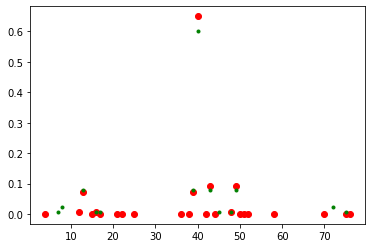

In [66]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-4):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [67]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(0.005516907633768488-0.0022884457462682725j)|2 2 1 2>
(-0.009049847163417772+0.012445966135353785j)|2 2 1 1>
(0.004642750924920474-0.004935570643518338j)|2 2 0 1>
(0.005516907633767985-0.0022884457462683536j)|2 1 2 2>
(-0.003862027304634491-0.005987081124448719j)|2 1 2 1>
(-0.03557643431152928+0.06864554043159542j)|2 1 1 2>
(0.09419701889834375-0.2488054496829727j)|2 1 1 1>
(-0.008170759243150019-0.004718669667750785j)|2 1 1 0>
(-0.00873474501617923-0.006567424368427109j)|2 1 0 2>
(-0.011598481285175568+0.08026827634931043j)|2 1 0 1>
(-0.002339724168440303-0.009937611285952632j)|2 1 0 0>
(-0.008734745016180052-0.006567424368425922j)|2 0 1 2>
(-0.0037917725937050588+0.023364709874362597j)|2 0 1 1>
(0.0025483635891794037-0.002494965066798921j)|2 0 1 0>
(-0.0011529605957534177-0.003914771676856032j)|2 0 0 2>
(-0.003932346286728081+0.011091184376051673j)|2 0 0 1>
(-0.00322816663746953-0.0012096579375234955j)|1 2 2 1>
(-0.0038620273046341457-0.005987081124449447j)|1 2 1 2>
(-0.002807268543

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]


In [177]:
a = np.array(1,2,3)
b = np.array(1,2,3)
print(np.conj(a)@b)

TypeError: array() takes from 1 to 2 positional arguments but 3 were given